# Lets just train a GAN which has all layers turned on but we only pass x through the num of current layers

In [1]:
# All the imports required for this implementation
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.autograd as autograd

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import TensorDataset, ConcatDataset, random_split, DataLoader, Dataset

from torchinfo import summary # Allows us to summarise the params and layers

import numpy as np
import matplotlib.pyplot as plt
import copy
import math

In [100]:
# We can make use of a GPU if you have one on your computer. This works for Nvidia and M series GPU's
if torch.backends.mps.is_available():
    device = torch.device("mps")
    # These 2 lines assign some data on the memory of the device and output it. The output confirms
    # if we have set the intended device
    x = torch.ones(1, device=device)
    print (x)
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = ("cpu")
    x = torch.ones(1, device=device)
    print (x)

tensor([1.], device='cuda:0')


In [3]:
del x

In [7]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_images(images, num_images=16, figsize=(10,10)):
    # Ensure the input is on CPU
    images = images.cpu().detach()
    
    # Normalize images from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    
    # Clamp values to [0, 1] range
    images = torch.clamp(images, 0, 1)
    
    # Make a grid of images
    grid = torchvision.utils.make_grid(images[:num_images], nrow=4)
    
    # Convert to numpy and transpose
    grid = grid.numpy().transpose((1, 2, 0))
    
    # Display the grid
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [108]:
# Load the data and display some images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),  # Resize images to 32x32
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# In the paper batch size changes as the model scales up the images to save memory, however I think with modern
# equipment we can ignore this?
batch_size = 16

# To load the data you must move the images to a folder within the dir they are in
dataset = ImageFolder(root='./celeba_hq_256', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

In [22]:
# Lets define the equalized LR conv and linear layers, from https://github.com/KimRass/PGGAN/blob/main/model.py#L26
class EqualLRLinear(nn.Module):
    def __init__(self, in_features, out_features, c=0.2):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.c = c
        
        self.scale = np.sqrt(c / in_features) # Per layer norm constant?
        
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        
        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)
        
    def forward(self, x):
        x = F.linear(x, weight=self.weight * self.scale, bias=self.bias)
        return x

class EqualLRConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, c=0.2):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.c = c
        
        self.scale = (c / (in_channels * kernel_size[0] * kernel_size[1])) ** 0.5
        
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size[0], kernel_size[1]))
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        
        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)
                
    def forward(self, x):
        x = F.conv2d(x, weight=self.weight * self.scale, bias=self.bias, stride=self.stride, padding=self.padding)
        return x
    

In [ ]:
# Lets create some tooling to assess how our GAN is doing 
# First idea compare the stddev and mean and the overall distribution of the Real and Gen pixels (using hist)
def 


In [115]:
# Let's define a function which can generate the conv block
def d_conv_block(in_channels, out_channels, kernel_size1=None, kernel_size2=None):
    if kernel_size2 is not None:
        block = nn.Sequential(
            Mbatch_stddev(),
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualLRConv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(out_channels),
            #nn.Conv2d(out_channels, out_channels, kernel_size2),
            EqualLRConv2d(out_channels, out_channels, kernel_size2),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(out_channels),
        )
    else:
        block = nn.Sequential(
            #nn.Conv2d(in_channels, in_channels, kernel_size1, padding=(1,1)),
            EqualLRConv2d(in_channels, in_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(in_channels),
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualLRConv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(out_channels),
            # Downsample
            nn.AvgPool2d(kernel_size=(2,2)),
        )
    
    return block

def g_conv_block(in_channels, out_channels, kernel_size1=None, kernel_size2=None, upsample=False):
    if upsample:
        block = nn.Sequential(
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualLRConv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            #nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            LRN(),
            #nn.Conv2d(out_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualLRConv2d(out_channels, out_channels, kernel_size1, padding=(1,1)),
            #nn.InstanceNorm2d(out_channels),
            #nn.LocalResponseNorm(x.size(0), alpha=1, beta=2, k=10e-8),
            nn.LeakyReLU(0.2),
            LRN(),
        )
    else:
        block = nn.Sequential(
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(3,3)),
            EqualLRConv2d(in_channels, out_channels, kernel_size1, padding=(3,3)),
            nn.LeakyReLU(0.2),
            LRN(),
            #nn.Conv2d(out_channels, out_channels, kernel_size2, padding=(1,1)),
            EqualLRConv2d(out_channels, out_channels, kernel_size2, padding=(1,1)),
            #nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            LRN(),
        )
    
    return block

def d_output_layer(input_dim):
    #layer = nn.Linear(input_dim, 1)
    layer = EqualLRLinear(input_dim, 1)
    return layer

def from_to_RGB(in_channels=None, out_channels=None):
    block = nn.Sequential(
        #nn.Conv2d(in_channels, out_channels, kernel_size=(1,1)),
        EqualLRConv2d(in_channels, out_channels, kernel_size=(1,1)),
        nn.LeakyReLU(0.2),
    )
    return block

def upsample(x):
    return nn.ConvTranspose2d(in_channels=channels, out_channels=channels, kernel_size=2, stride=2)

class Mbatch_stddev(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        '''N, _, H, W = x.shape
    
        # First calculate the stddev for each feature in each spatial location over the batch
        # Which means calculate the stddev of each feature map
        featuremap_stddevs = torch.std(x, dim=0, unbiased=False)
        # Then average these estimates over all features and spatial locations to arrive at a single value
        mean_stddev = torch.mean(featuremap_stddevs)
        stddev_featuremap = mean_stddev * torch.ones((N, 1, H, W), device=x.device)

        x = torch.cat((x, stddev_featuremap), dim=1)

        return x'''
        b, _, h, w = x.shape
        # "We compute the standard deviation for each feature in each spatial location over the minibatch.
        # We then average these estimates over all features and spatial locations to arrive at a single value.
        # We replicate the value and concatenate it to all spatial locations and over the minibatch,
        # yielding one additional (constant) feature map."
        feat_map = x.std(dim=0, keepdim=True).mean(dim=(1, 2, 3), keepdim=True)
        x = torch.cat([x, feat_map.repeat(b, 1, h, w)], dim=1)
        return x

class LRN(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(LRN, self).__init__()
        self.epsilon = epsilon
    
    def forward(self, x):
        #square_sum = torch.pow(x, 2).sum(dim=1, keepdim=True)  # Sum across all channels
        #norm_factor = torch.sqrt(square_sum / x.size(1) + self.epsilon)  # Divide by N (number of channels)
        #return x / norm_factor  # Normalize
        x = x / torch.sqrt((x ** 2).mean(dim=1, keepdim=True)+ self.epsilon)
        return x

        

In [327]:
'''class Generator_32(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(4,4), kernel_size2=(3,3)).to(device)
        self.up1 = upsample(512).to(device)
        self.block2 = g_conv_block(in_channels=512, out_channels=256, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        self.up2 = upsample(256).to(device)
        self.block3 = g_conv_block(in_channels=256, out_channels=128, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        self.up3 = upsample(128).to(device)
        self.block4 = g_conv_block(in_channels=128, out_channels=64, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        
        self.to_rgb1 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        self.to_rgb2 = from_to_RGB(in_channels=256, out_channels=3).to(device)
        self.to_rgb3 = from_to_RGB(in_channels=128, out_channels=3).to(device)
        self.to_rgb4 = from_to_RGB(in_channels=64, out_channels=3).to(device)
        
        self.act = nn.Tanh()
        
        self.blocks = [self.block1, self.block2, self.block3, self.block4]
        self.ups = [self.up1, self.up2, self.up3]
        self.to_rgbs = [self.to_rgb1, self.to_rgb2, self.to_rgb3, self.to_rgb4]
        
    def forward(self, x, alpha=1, layer_num=0):
        for i in range(layer_num):
            x = self.blocks[i](x)
            if i < layer_num - 1:
                x = self.ups[i](x)
            if i == layer_num - 2:
                res_x = torch.clone(x)
            
        out = self.to_rgbs[layer_num-1](x)
        
        if layer_num > 1 and alpha < 1:
            prev_rgb = self.to_rgbs[layer_num-2](res_x)
            
            # Interpolate between the two outputs
            out = (1 - alpha) * prev_rgb + alpha * out
        
        out = self.act(out)
        
        return out
    
g_32 = Generator_32()
g_32 = g_32.to(device)'''

In [335]:
class Generator_32(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = g_conv_block(in_channels=128, out_channels=256, kernel_size1=(4,4), kernel_size2=(3,3)).to(device)
        self.up1 = upsample(256).to(device)
        self.block2 = g_conv_block(in_channels=256, out_channels=128, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        self.up2 = upsample(128).to(device)
        self.block3 = g_conv_block(in_channels=128, out_channels=64, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        self.up3 = upsample(64).to(device)
        self.block4 = g_conv_block(in_channels=64, out_channels=32, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        
        self.to_rgb1 = from_to_RGB(in_channels=256, out_channels=3).to(device)
        self.to_rgb2 = from_to_RGB(in_channels=128, out_channels=3).to(device)
        self.to_rgb3 = from_to_RGB(in_channels=64, out_channels=3).to(device)
        self.to_rgb4 = from_to_RGB(in_channels=32, out_channels=3).to(device)
        
        self.tanh = nn.Tanh()
        
        self.blocks = [self.block1, self.block2, self.block3, self.block4]
        self.ups = [self.up1, self.up2, self.up3]
        self.to_rgbs = [self.to_rgb1, self.to_rgb2, self.to_rgb3, self.to_rgb4]
        
    def forward(self, x, alpha=1, layer_num=0):
        for i in range(layer_num):
            x = self.blocks[i](x)
            if i < layer_num - 1:
                x = self.ups[i](x)
            if i == layer_num - 2:
                res_x = torch.clone(x)
            
        out = self.to_rgbs[layer_num-1](x)
        
        if layer_num > 1 and alpha < 1:
            prev_rgb = self.to_rgbs[layer_num-2](res_x)
            
            # Interpolate between the two outputs
            out = (1 - alpha) * prev_rgb + alpha * out
        
        out = self.tanh(out)
        
        return out
    
g_32 = Generator_32()
g_32 = g_32.to(device)

In [286]:
g_32

Generator_32(
  (block1): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LRN()
    (4): LeakyReLU(negative_slope=0.2)
  )
  (up1): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
  (block2): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LRN()
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LRN()
    (5): LeakyReLU(negative_slope=0.2)
  )
  (up2): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (block3): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LRN()
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LRN()
    (5): LeakyReLU(negative_slope=

In [328]:
g_in = torch.randn((1, 512, 1, 1), device=device)

# For 4x4 resolution (first stage)
out = g_32(g_in, alpha=0, layer_num=1)

# For 8x8 resolution with alpha=0.5
#out = g_32(g_in, alpha=0.5, layer_num=2)

# For 16x16 resolution
#out = g_32(g_in, alpha=0.5, layer_num=3)

# For full 32x32 resolution
#out = g_32(g_in, alpha=0.5, layer_num=4)

print(out.shape)

torch.Size([1, 3, 4, 4])


In [336]:
class Discriminator_32(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block4 = d_conv_block(in_channels=64, out_channels=128, kernel_size1=(3,3)).to(device)
        self.block3 = d_conv_block(in_channels=128, out_channels=256, kernel_size1=(3,3)).to(device)
        self.block2 = d_conv_block(in_channels=256, out_channels=512, kernel_size1=(3,3)).to(device)
        self.block1 = d_conv_block(in_channels=513, out_channels=512, kernel_size1=(3,3), kernel_size2=(4,4)).to(device)
        
        self.down = nn.AvgPool2d(kernel_size=(2,2)).to(device)  # This isnt used for the layers but the res connection
        
        self.from_rgb4 = from_to_RGB(in_channels=3, out_channels=64).to(device)
        self.from_rgb3 = from_to_RGB(in_channels=3, out_channels=128).to(device)
        self.from_rgb2 = from_to_RGB(in_channels=3, out_channels=256).to(device)
        self.from_rgb1 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        
        self.FC1 = nn.Identity()
        
        self.blocks = [self.block1, self.block2, self.block3, self.block4]
        self.from_rgbs = [self.from_rgb1, self.from_rgb2, self.from_rgb3, self.from_rgb4]
    
    def forward(self, x, alpha=1, layer_num=0):
        in_x = torch.clone(x)
        x = self.from_rgbs[layer_num-1](x)
        
        for i in reversed(range(layer_num)):
            x = self.blocks[i](x)
            if i == layer_num-1 and alpha < 1 and layer_num > 1:
                # Fade in the new layer
                downscaled = self.down(in_x)
                from_rgb = self.from_rgbs[layer_num-2](downscaled)
                x = (alpha * x) + ((1 - alpha) * from_rgb)
        
        # Last FC layer
        x = x.view(x.size(0), -1) # Reshape the output, i.e. flatten it 
        self.FC1 = d_output_layer(x.size(1)).to(x.device)
        x = self.FC1(x)
        
        return x
        
d_32 = Discriminator_32() 
d_32 = d_32.to(device)

In [249]:
d_32

Discriminator_32(
  (block4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (block3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (block2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (block1)

In [270]:
d_in = torch.randn(32, 3, 8, 8).to(device)

# For 4x4 resolution (first stage)
#out = d_32(d_in, alpha=0.5, layer_num=1)

# For 8x8 resolution with alpha=0.5
out = d_32(d_in, alpha=0.5, layer_num=2)

#For 16x16 resolution
#out = d_32(d_in, alpha=0.5, layer_num=3)

# For full 32x32 resolution
#out = d_32(d_in, alpha=0.5, layer_num=4)

print(out)

tensor([[0.0309],
        [0.0275],
        [0.0310],
        [0.0219],
        [0.0311],
        [0.0288],
        [0.0335],
        [0.0186],
        [0.0266],
        [0.0250],
        [0.0217],
        [0.0390],
        [0.0379],
        [0.0221],
        [0.0259],
        [0.0168],
        [0.0216],
        [0.0256],
        [0.0246],
        [0.0393],
        [0.0204],
        [0.0131],
        [0.0265],
        [0.0215],
        [0.0166],
        [0.0221],
        [0.0183],
        [0.0435],
        [0.0257],
        [0.0270],
        [0.0260],
        [0.0143]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [94]:
class WGAN_GP_Loss(nn.Module):
    def __init__(self, lambda_gp=10, epsilon_drift=0.001):
        super().__init__()
        self.lambda_gp = lambda_gp
        self.epsilon_drift = epsilon_drift

    def compute_gradient_penalty(self, discriminator, real_samples, fake_samples, alpha, layer_num):
        batch_size = real_samples.size(0)
        epsilon = torch.rand(batch_size, 1, 1, 1).to(real_samples.device)
        interpolates = (epsilon * real_samples + ((1 - epsilon) * fake_samples.detach())).requires_grad_(True)
        d_interpolates = discriminator(interpolates, alpha, layer_num)
        fake = torch.ones(batch_size, 1).to(real_samples.device)
        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(batch_size, -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def forward(self, discriminator, real_imgs, fake_imgs, alpha, layer_num):
        real_validity = discriminator(real_imgs, alpha, layer_num)
        fake_validity = discriminator(fake_imgs, alpha, layer_num)
        
        gradient_penalty = self.compute_gradient_penalty(discriminator, real_imgs, fake_imgs, alpha, layer_num)
        
        # Add drift penalty
        drift_penalty = self.epsilon_drift * torch.mean(real_validity**2)
        
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + self.lambda_gp * gradient_penalty + drift_penalty
        g_loss = -torch.mean(fake_validity)
        
        return d_loss, g_loss

In [95]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [120]:
# Lets build a training loop using just BCELoss and see what happens
# For intial experiment I will use BCELoss however the actual paper uses: https://arxiv.org/abs/1704.00028
#criterion = nn.BCEWithLogitsLoss()
criterion = WGAN_GP_Loss()

d_32 = Discriminator_32() 
d_32.apply(weights_init)
d_32 = d_32.to(device)

g_32 = Generator_32() 
g_32.apply(weights_init)
g_32 = g_32.to(device)


# Intialise two optimisers
optim_D = torch.optim.Adam(d_32.parameters(), lr=0.001, betas=(0, 0.99), eps=10**(-8))
optim_G = torch.optim.Adam(g_32.parameters(), lr=0.001, betas=(0, 0.99), eps=10**(-8))

latent_dim = (batch_size, 512, 1, 1)

Training layer: 1


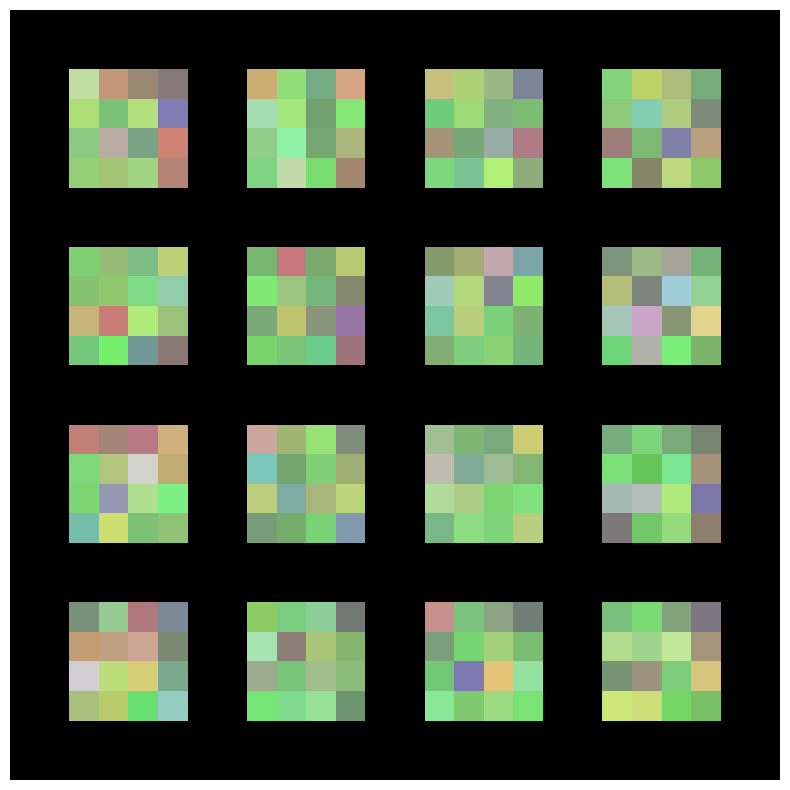

Layer 1: Loss_D: 5.624458312988281, Loss_G: -0.052761487662792206


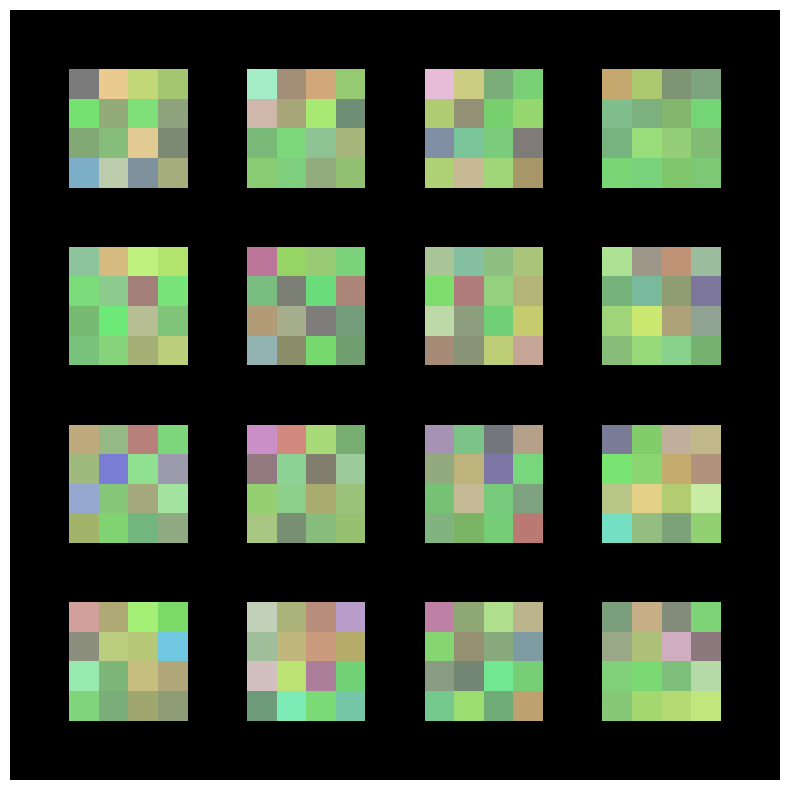

Layer 1: Loss_D: 0.3198176324367523, Loss_G: 0.39419013261795044


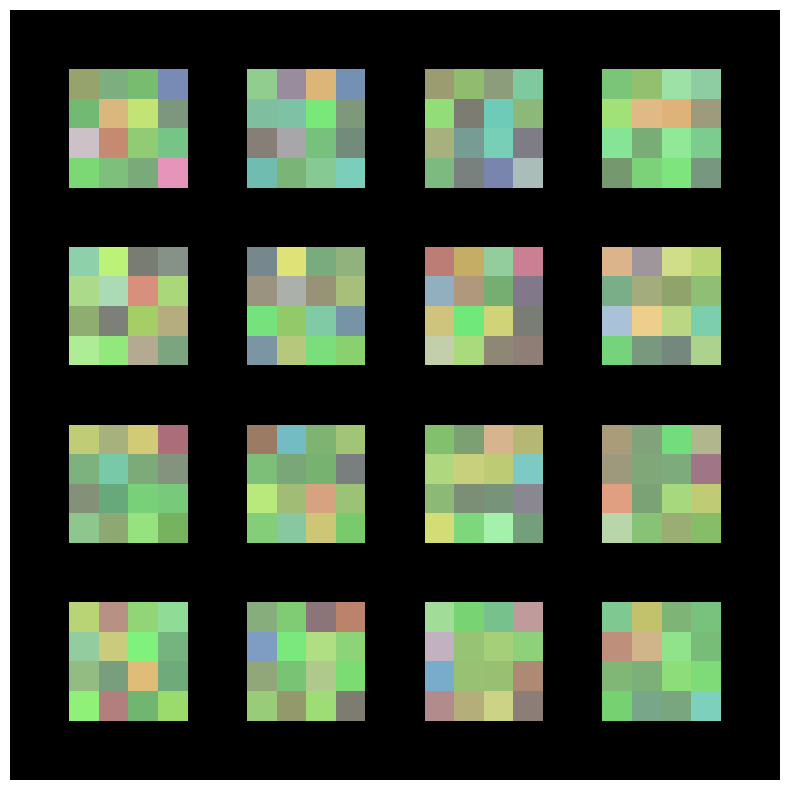

Layer 1: Loss_D: 1.5185983180999756, Loss_G: -0.05103112757205963


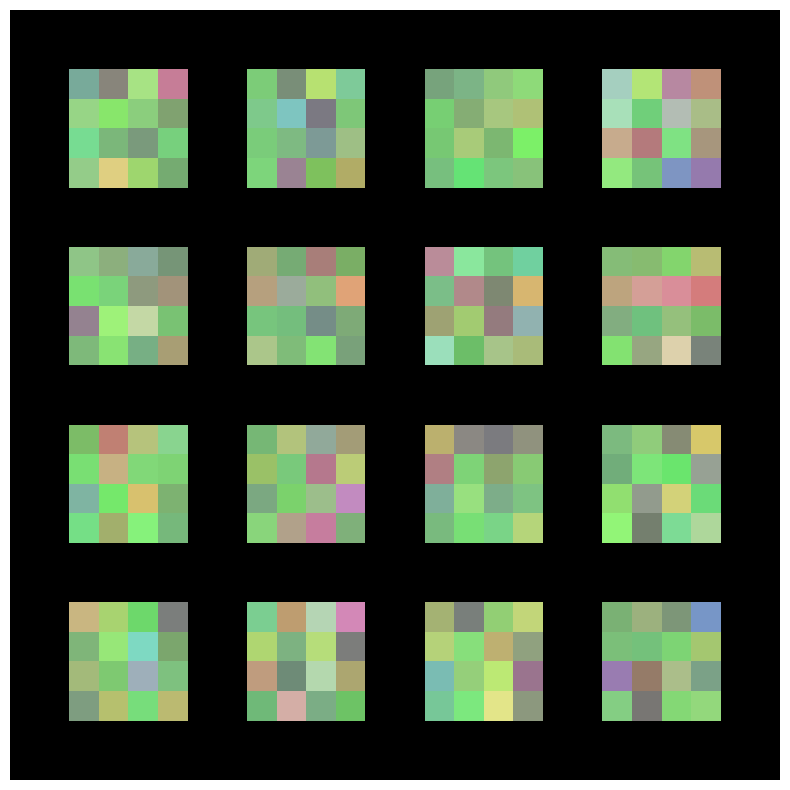

Layer 1: Loss_D: 0.6686487197875977, Loss_G: 0.22909444570541382


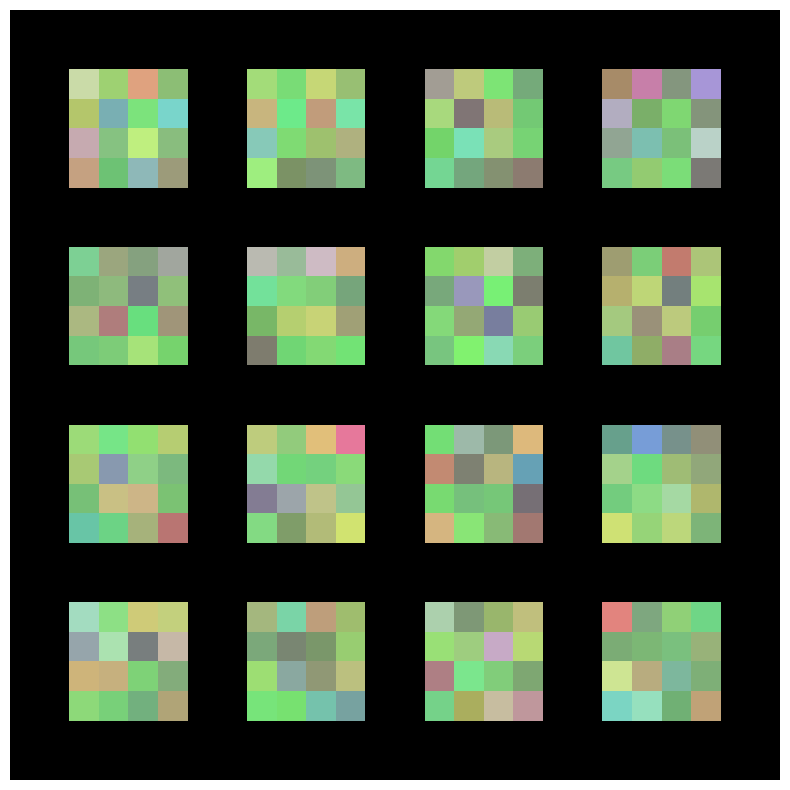

Layer 1: Loss_D: -0.2777847349643707, Loss_G: 0.00982712209224701


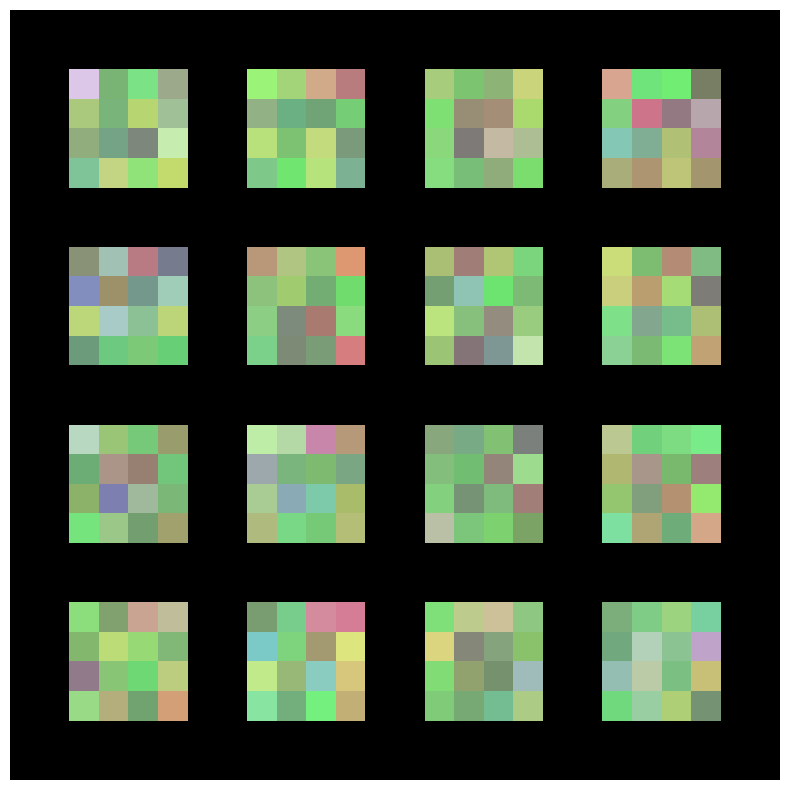

Layer 1: Loss_D: -0.192831352353096, Loss_G: -0.15208636224269867


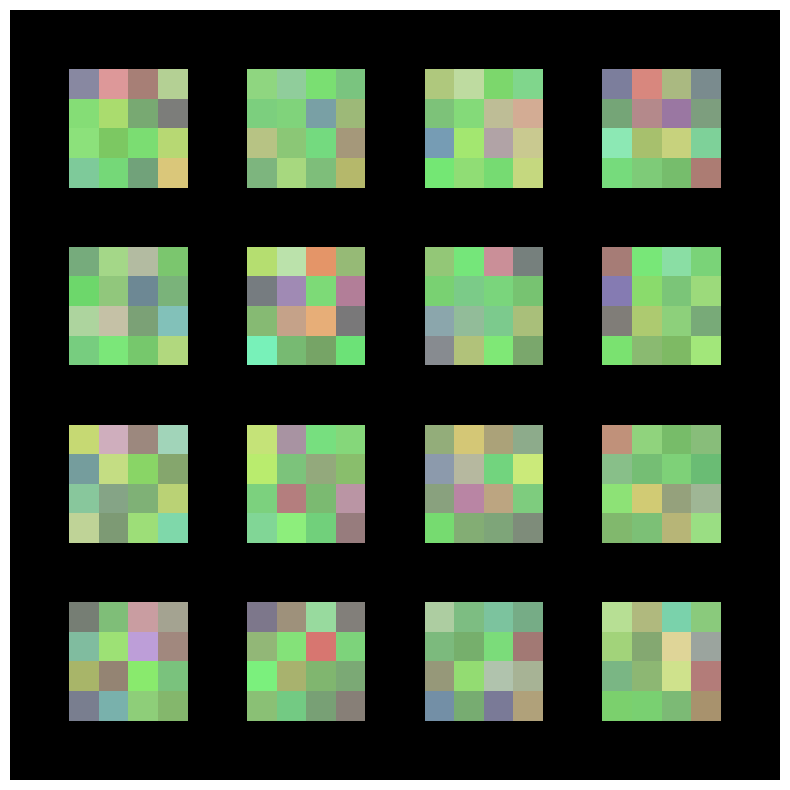

Layer 1: Loss_D: -0.11283079534769058, Loss_G: 0.3297216594219208


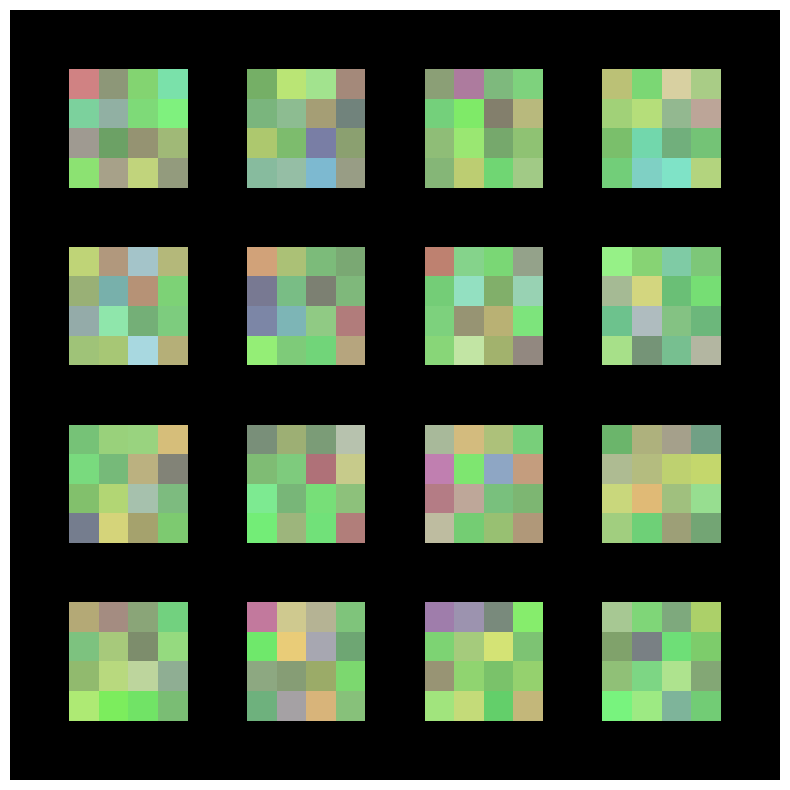

Layer 1: Loss_D: 0.8354544639587402, Loss_G: -0.158720463514328


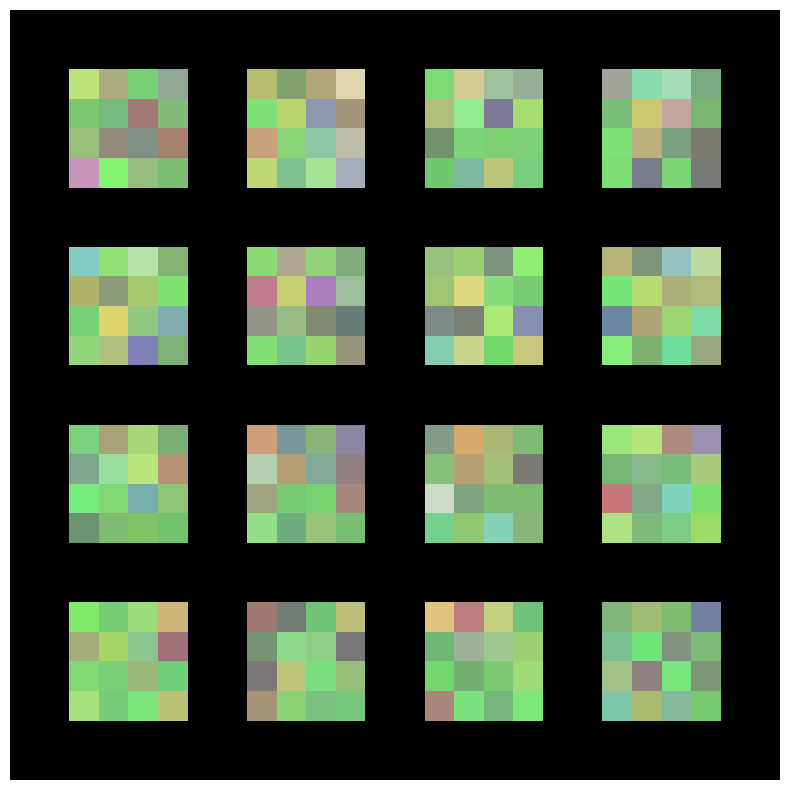

Layer 1: Loss_D: 1.5421860218048096, Loss_G: -0.33255499601364136


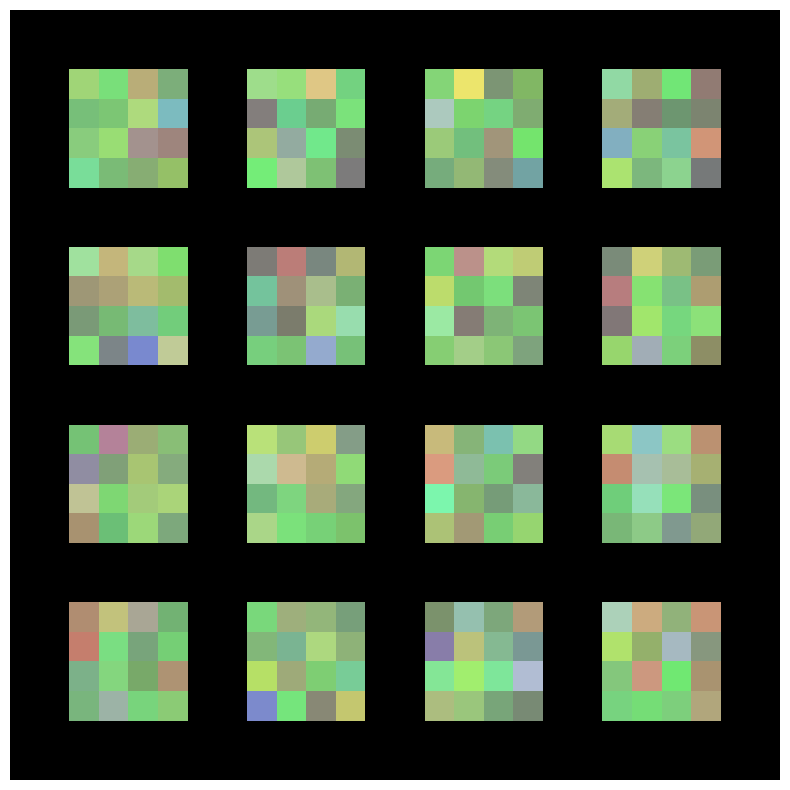

Layer 1: Loss_D: 1.011144757270813, Loss_G: -0.23148861527442932


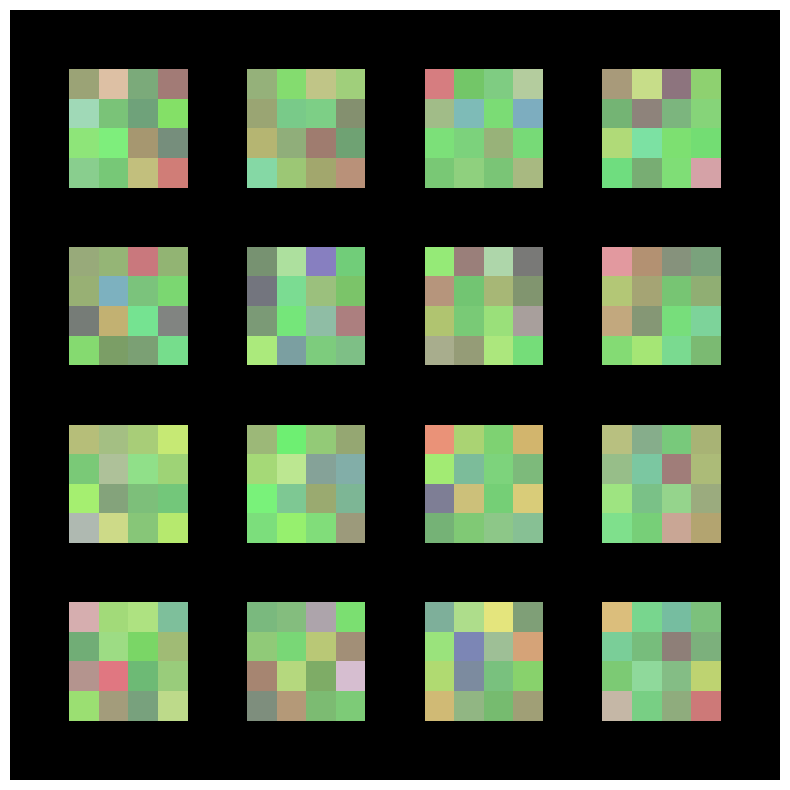

Layer 1: Loss_D: 0.27825209498405457, Loss_G: -0.15771207213401794


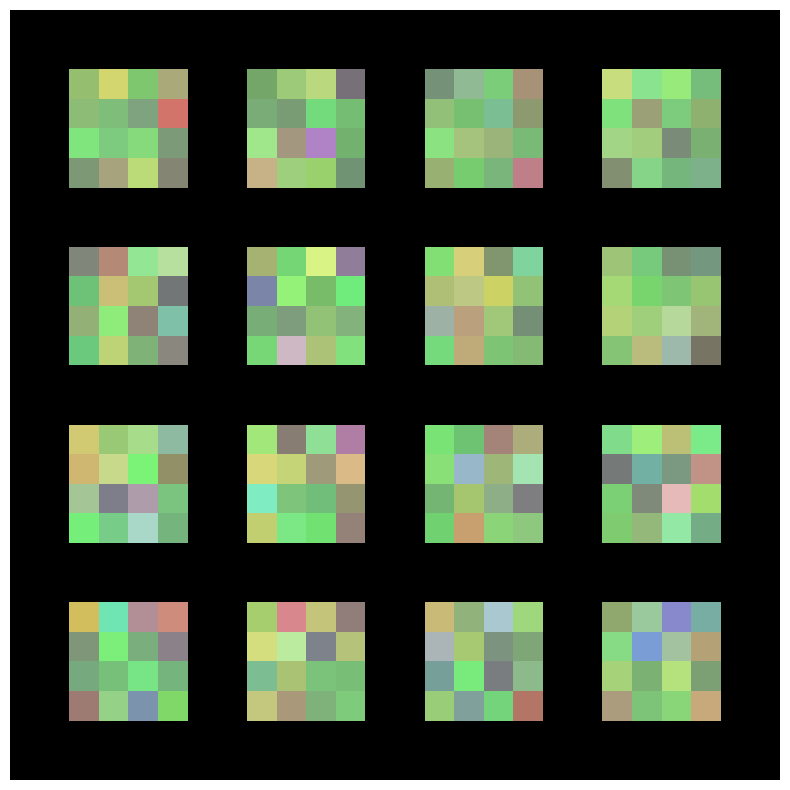

Layer 1: Loss_D: 1.0328621864318848, Loss_G: -0.30908018350601196


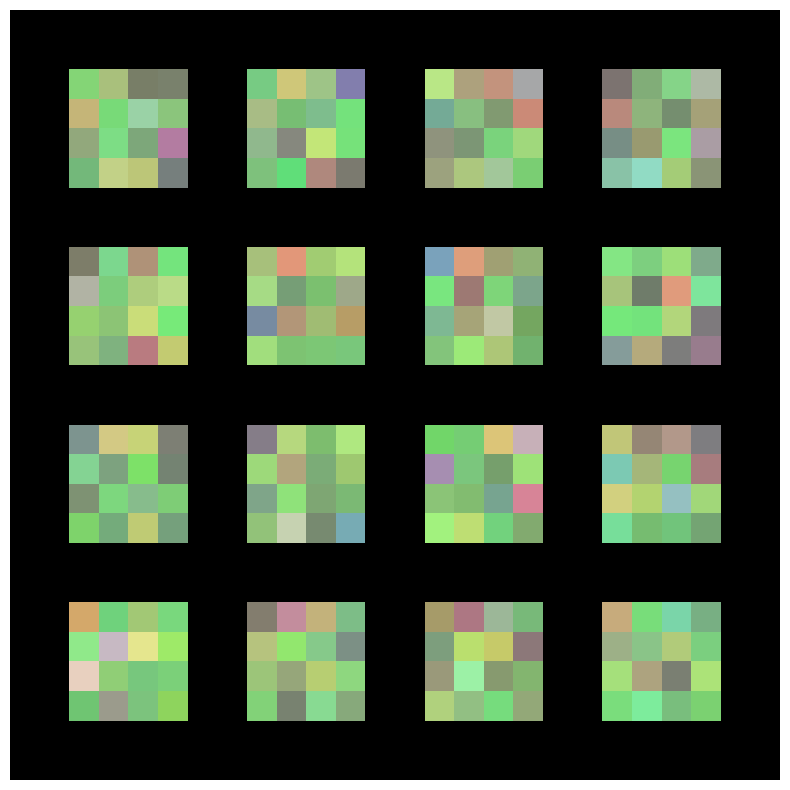

Layer 1: Loss_D: -0.7727019190788269, Loss_G: -0.45547255873680115


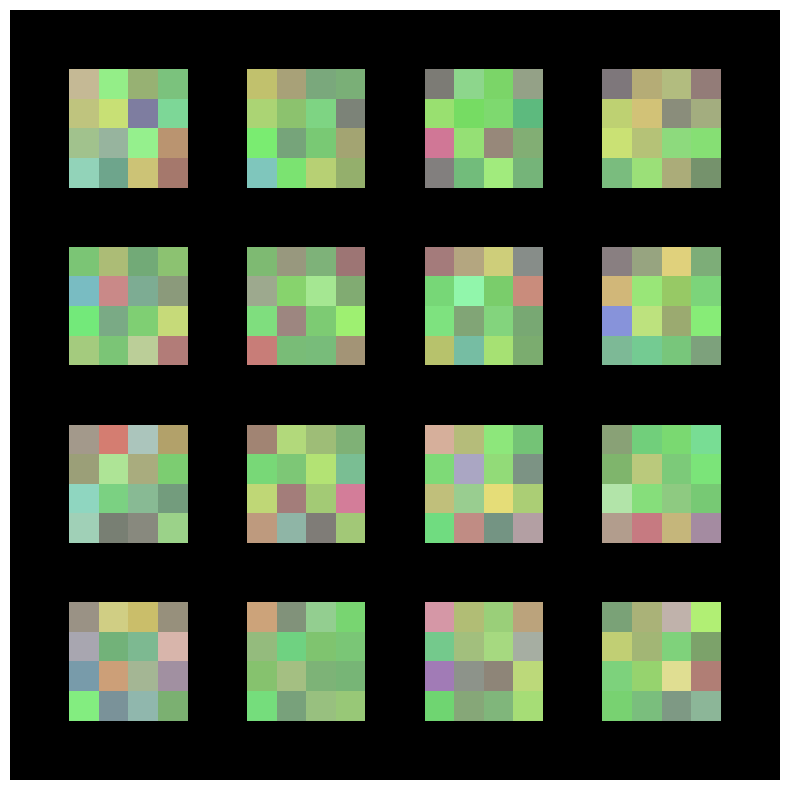

Layer 1: Loss_D: 1.229662299156189, Loss_G: 0.7342286109924316


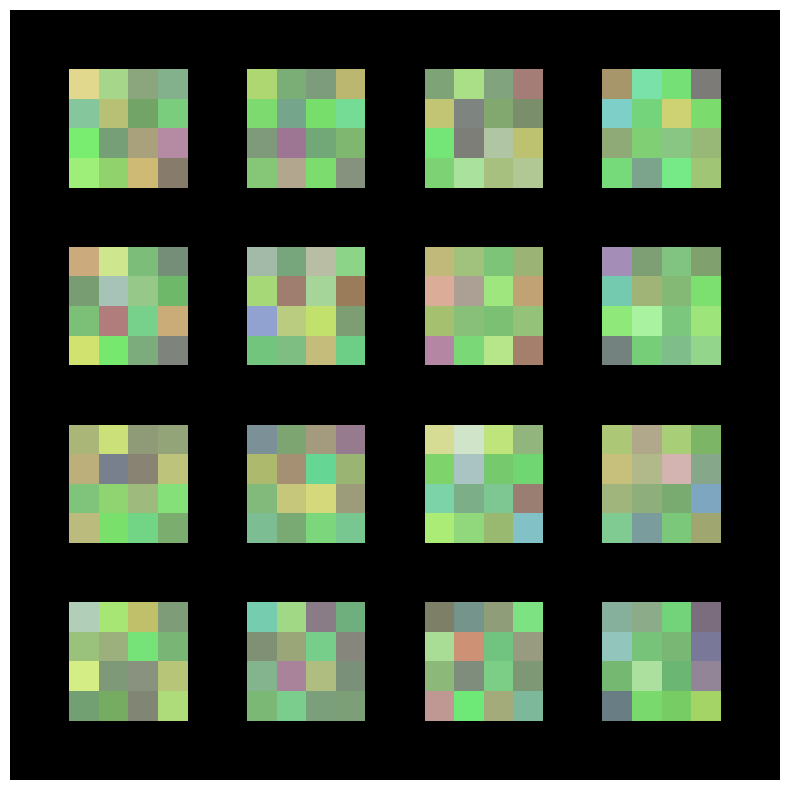

Layer 1: Loss_D: -0.2874300479888916, Loss_G: 0.7264449596405029


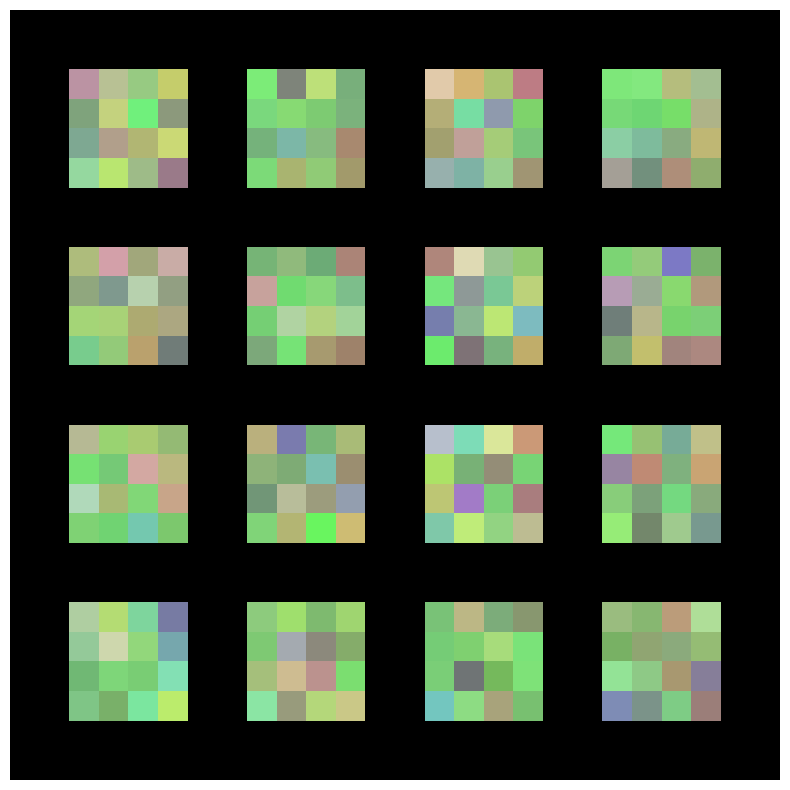

Layer 1: Loss_D: -0.4148904085159302, Loss_G: -0.6102442741394043


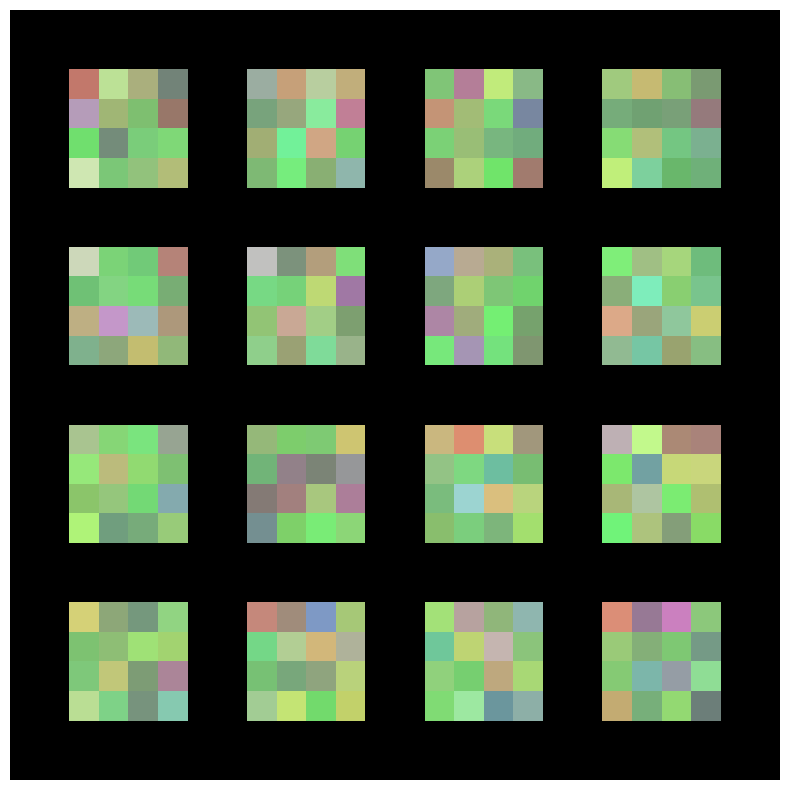

Layer 1: Loss_D: -1.3259177207946777, Loss_G: 0.5030919313430786


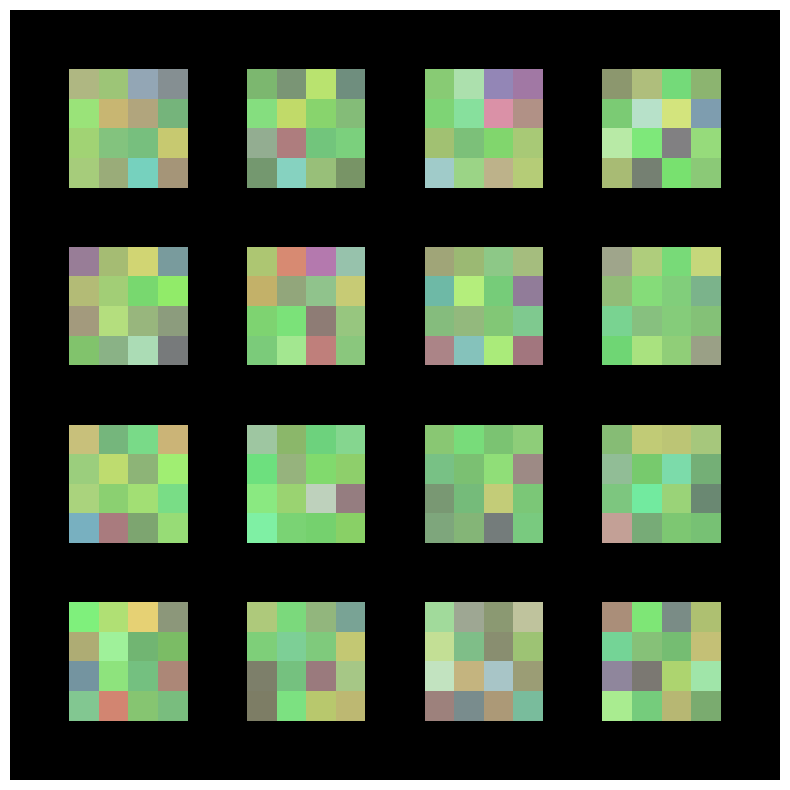

Layer 1: Loss_D: 0.8600776791572571, Loss_G: 0.25769829750061035


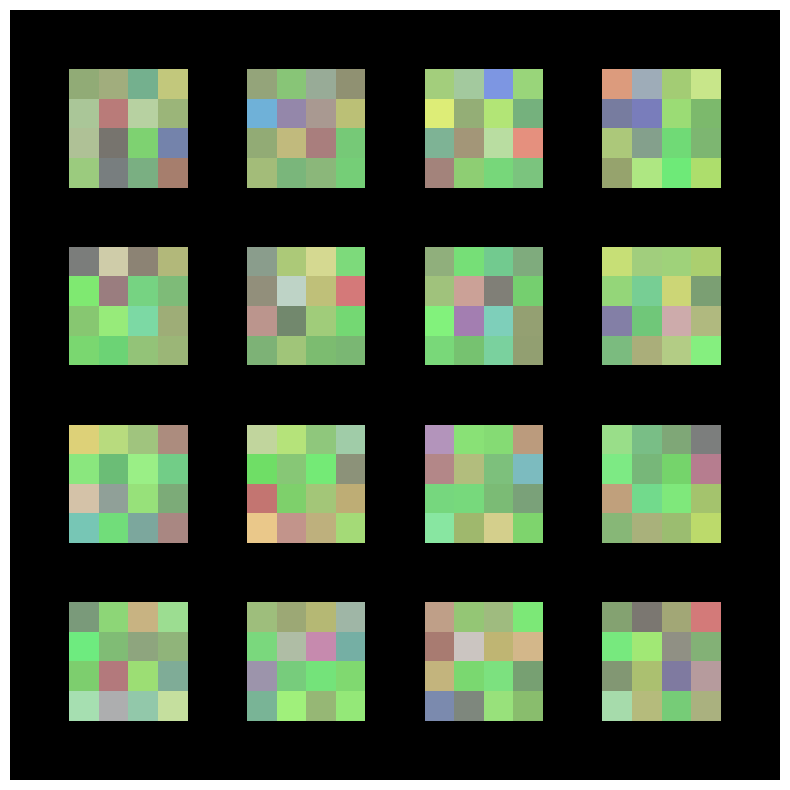

Layer 1: Loss_D: 0.8515400886535645, Loss_G: -0.4301876127719879


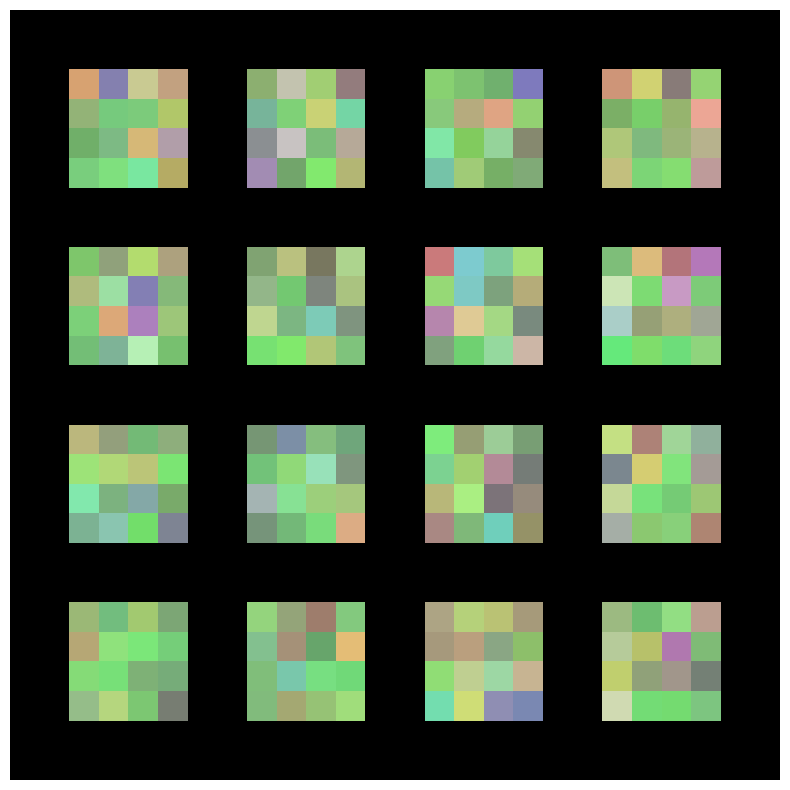

Layer 1: Loss_D: 0.3450574278831482, Loss_G: -0.38806790113449097


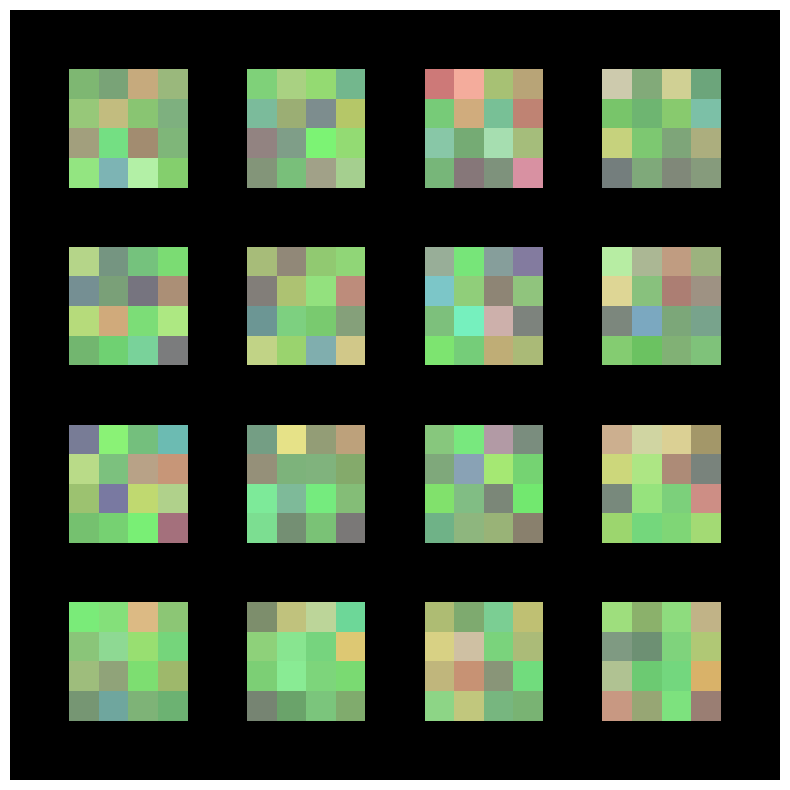

Layer 1: Loss_D: 0.4545324444770813, Loss_G: -0.6709626913070679


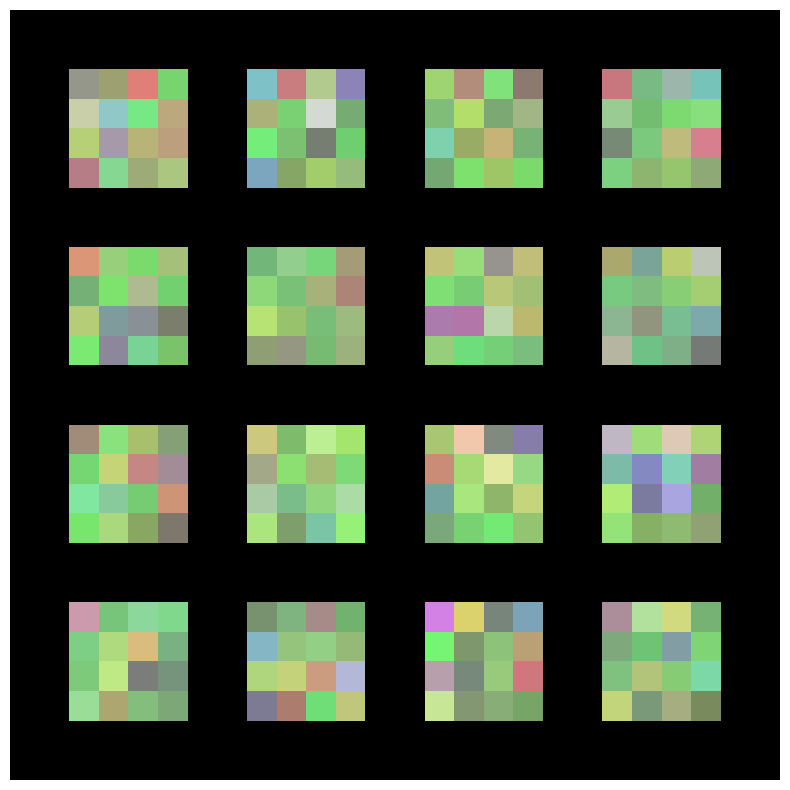

Layer 1: Loss_D: 0.6947101950645447, Loss_G: -0.3782716691493988


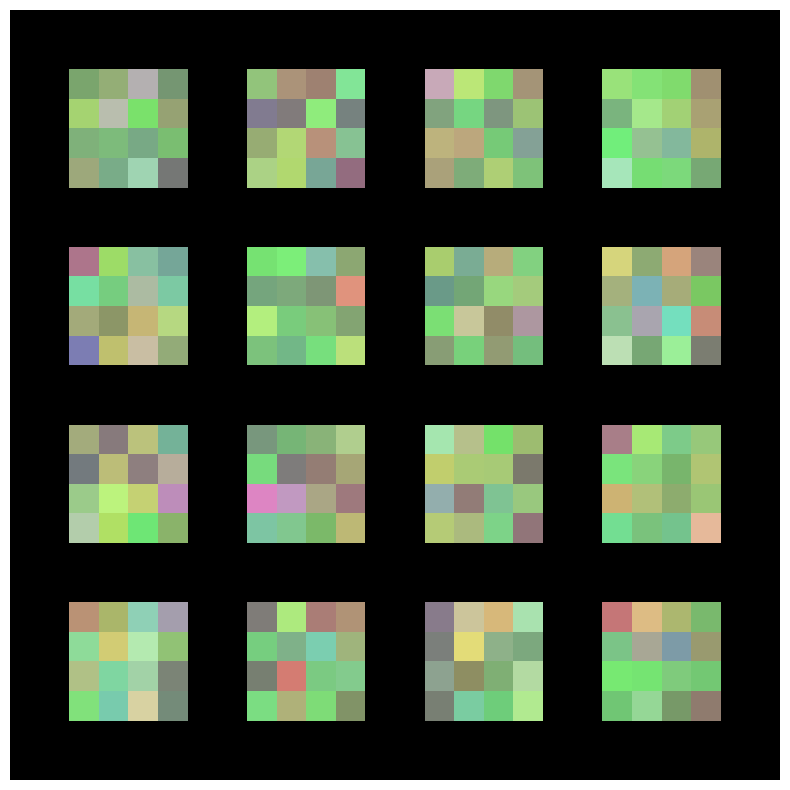

Layer 1: Loss_D: -0.17913030087947845, Loss_G: 0.30583521723747253


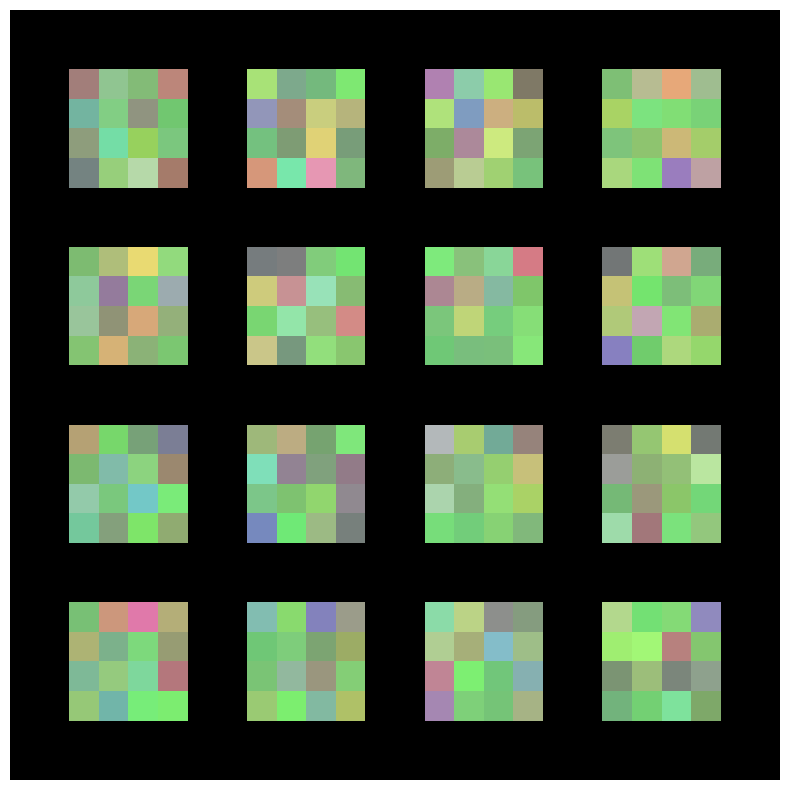

Layer 1: Loss_D: -0.6815897822380066, Loss_G: 0.26546987891197205


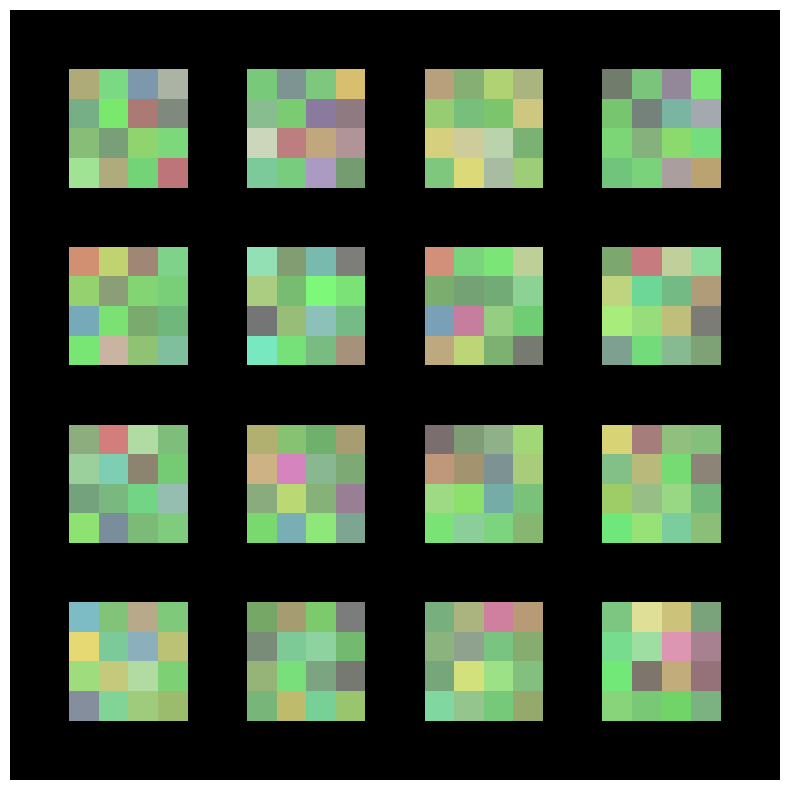

Layer 1: Loss_D: -0.3341277837753296, Loss_G: -0.22132182121276855


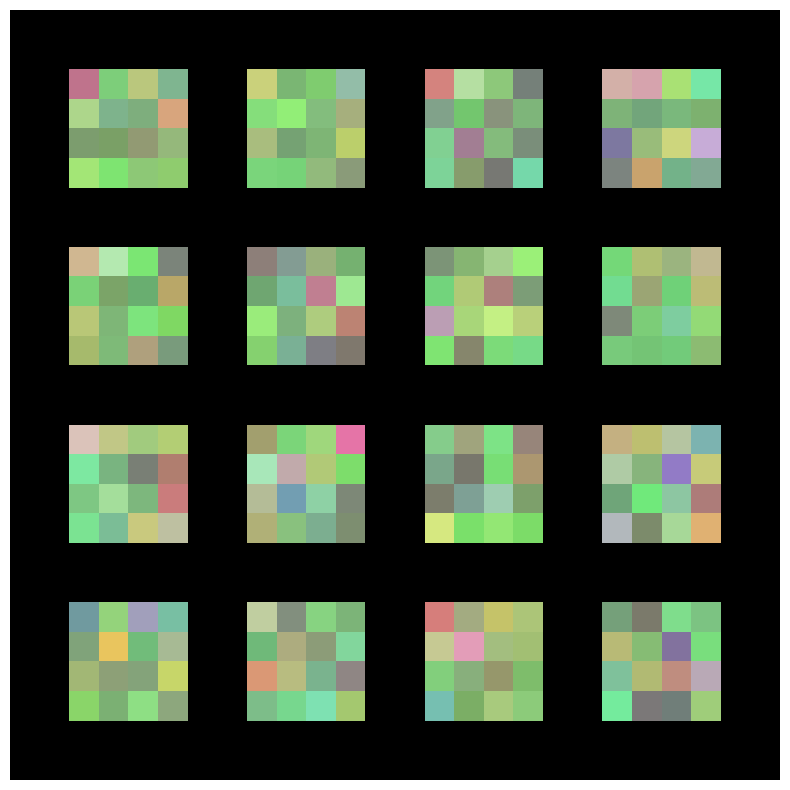

Layer 1: Loss_D: 0.3909132182598114, Loss_G: 0.5411376953125


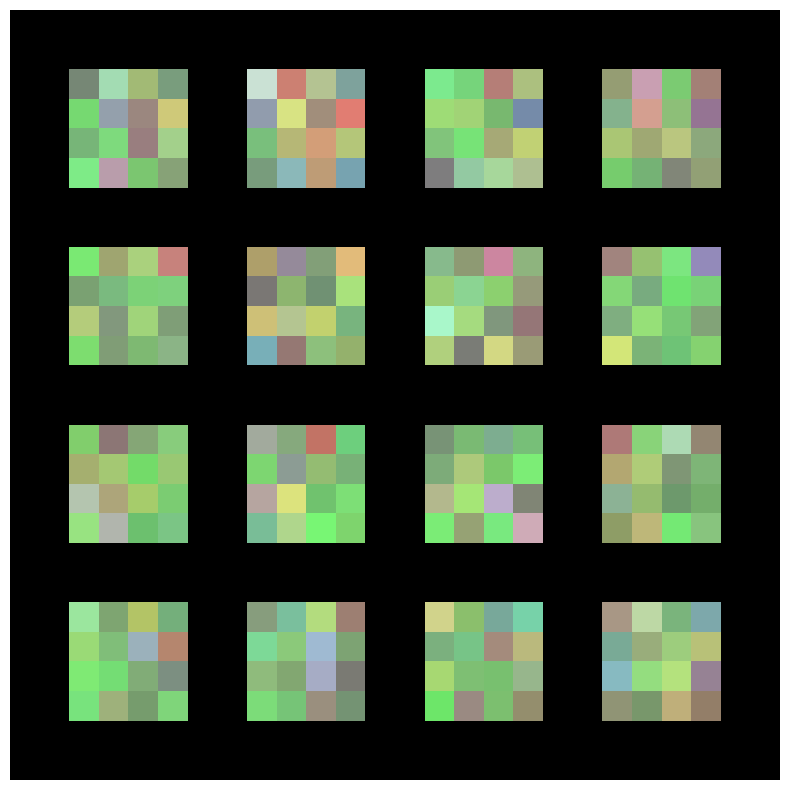

Layer 1: Loss_D: 1.95412278175354, Loss_G: 0.35532814264297485


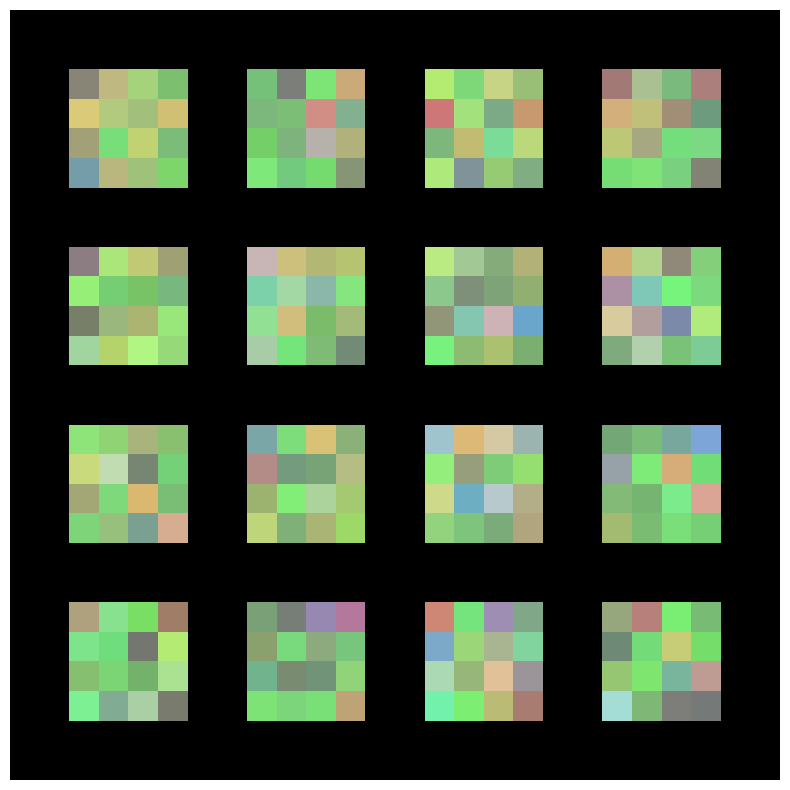

Layer 1: Loss_D: 1.8393241167068481, Loss_G: 0.6085759401321411


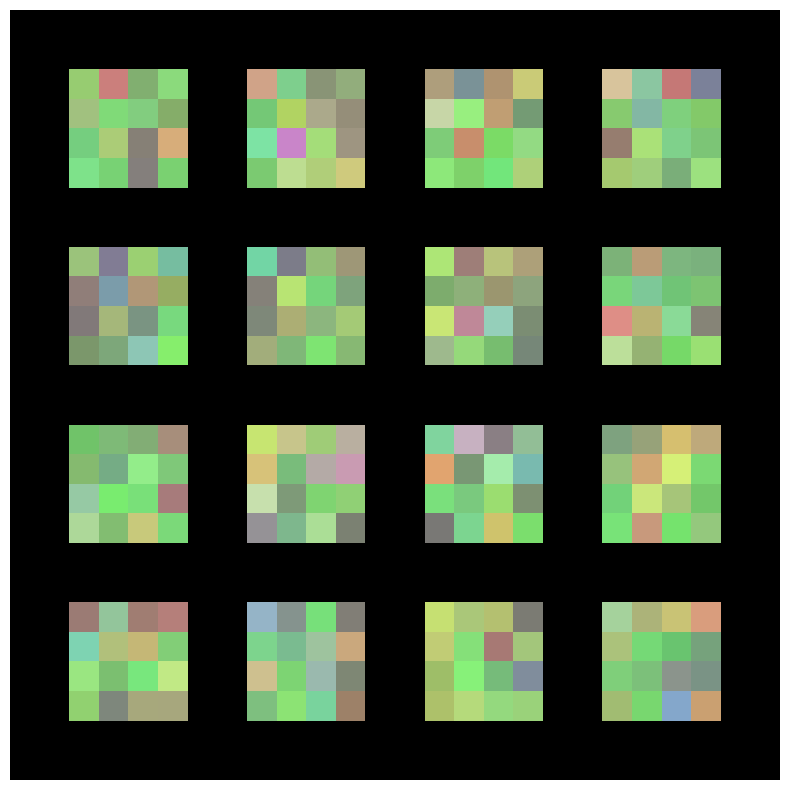

Layer 1: Loss_D: 0.9604734778404236, Loss_G: 0.5711783766746521


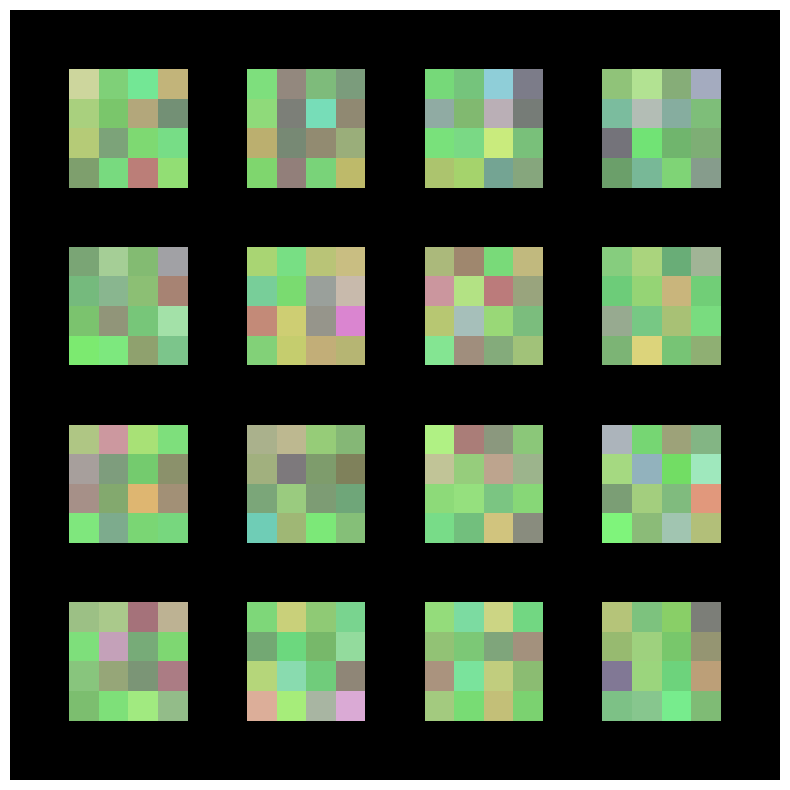

Layer 1: Loss_D: 0.411042183637619, Loss_G: -0.34918004274368286


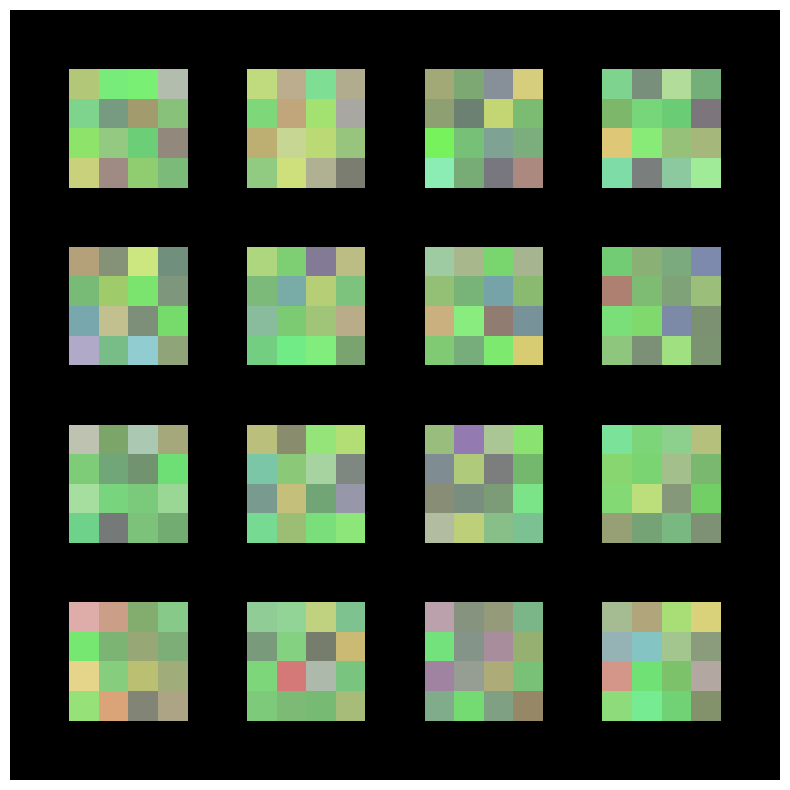

Layer 1: Loss_D: -0.18028713762760162, Loss_G: -0.8963968753814697


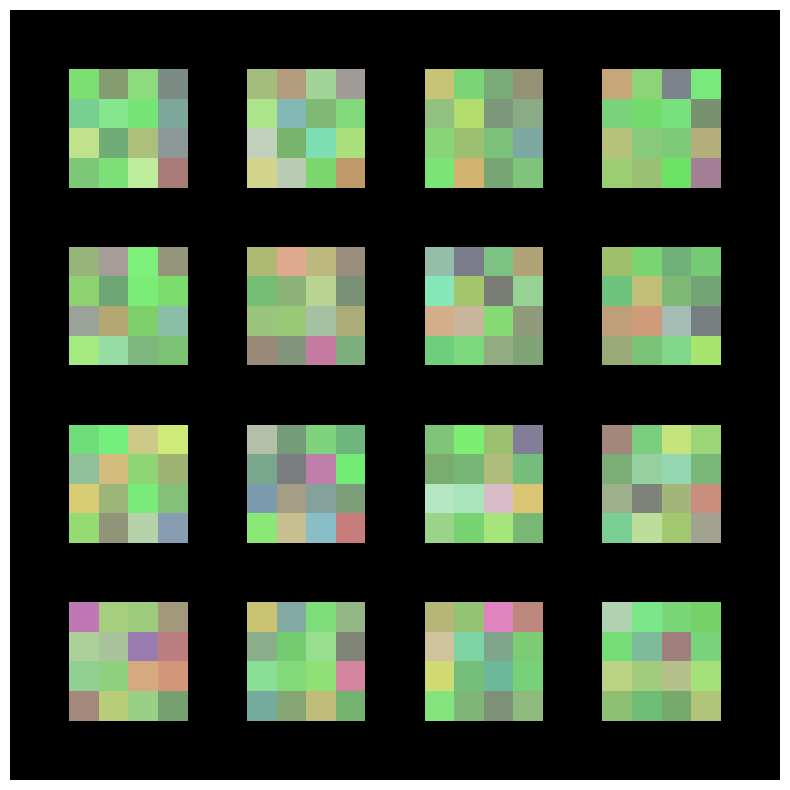

Layer 1: Loss_D: -0.8822168707847595, Loss_G: 0.20755691826343536


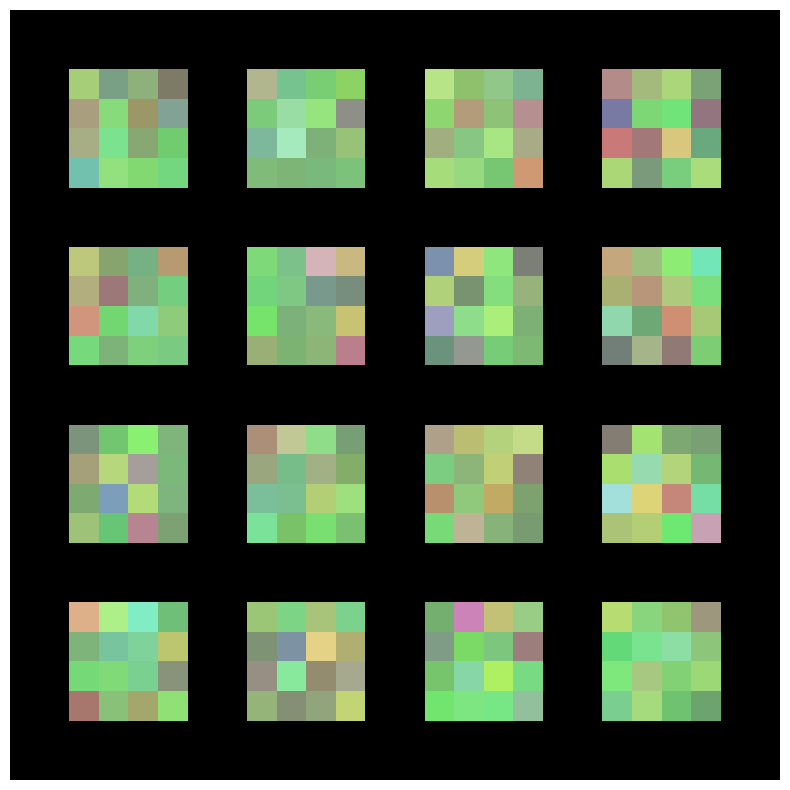

Layer 1: Loss_D: 2.2878332138061523, Loss_G: -1.2725374698638916


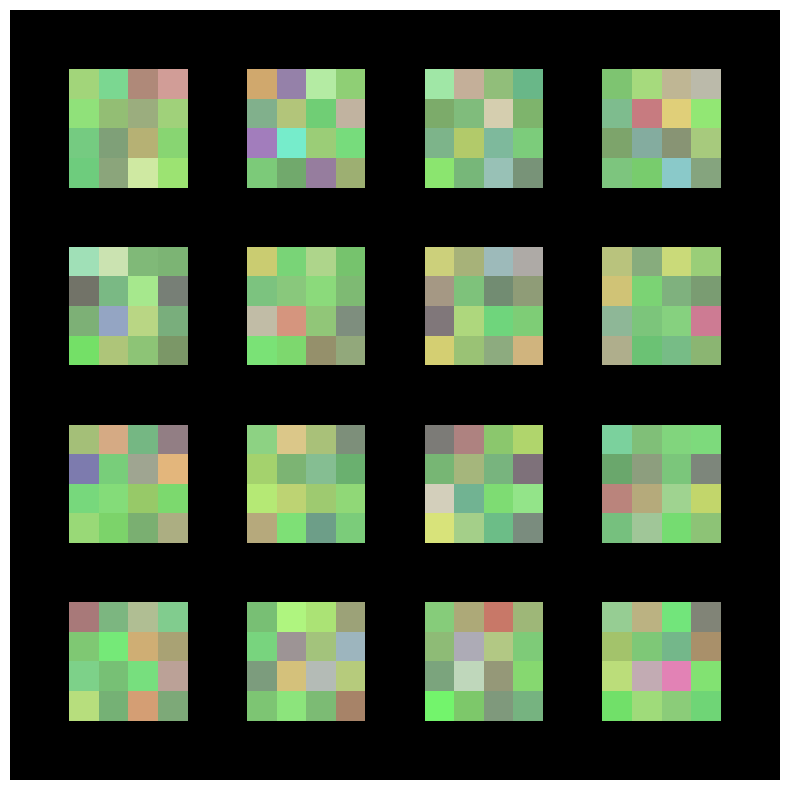

Layer 1: Loss_D: 0.7412763833999634, Loss_G: -0.17369535565376282


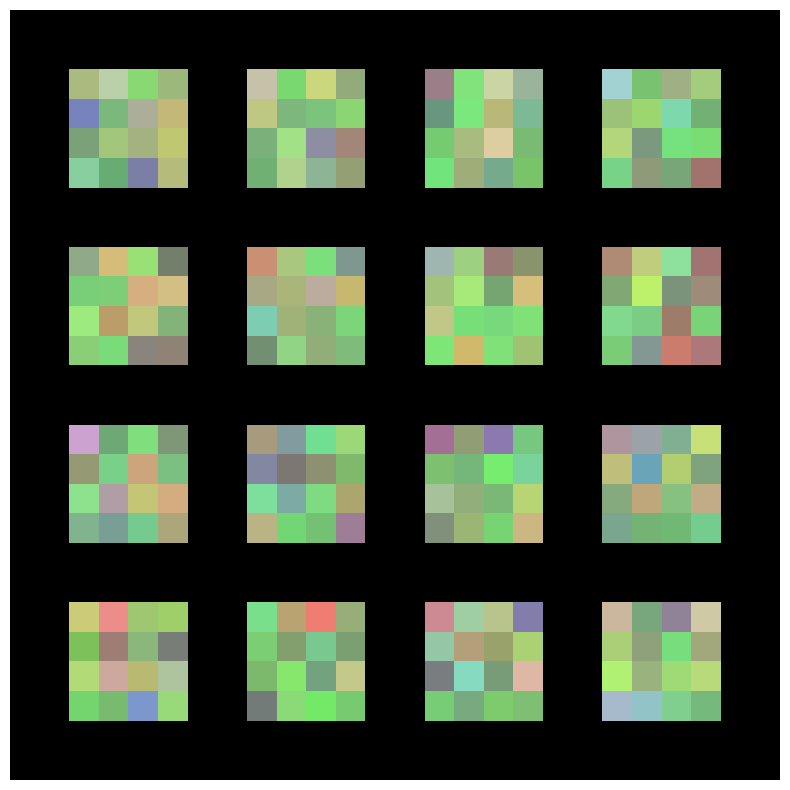

Layer 1: Loss_D: 0.1579245924949646, Loss_G: 0.8524770736694336


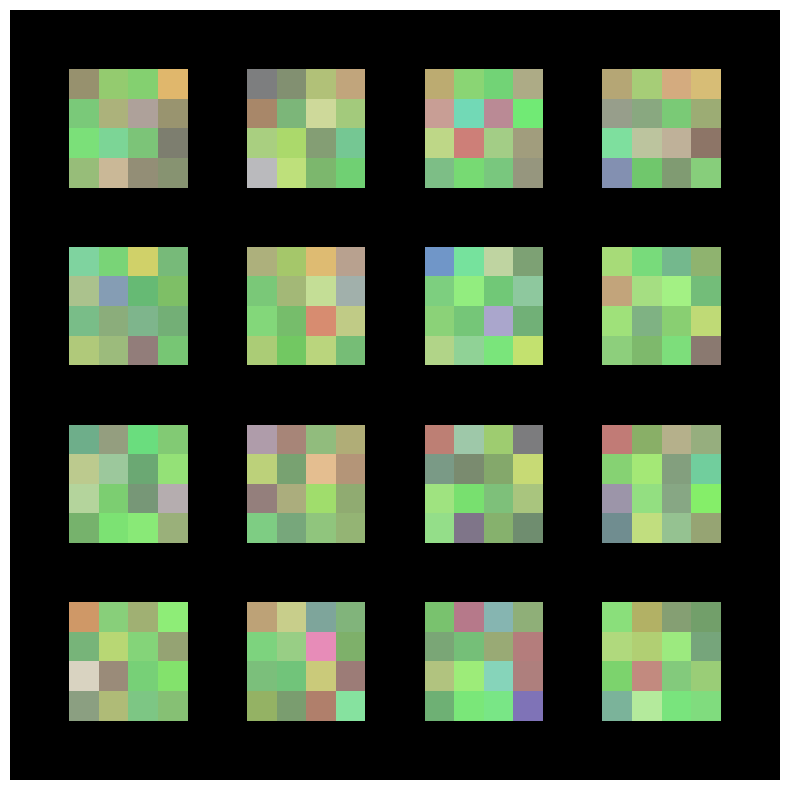

Layer 1: Loss_D: 1.1251816749572754, Loss_G: -0.3041089177131653


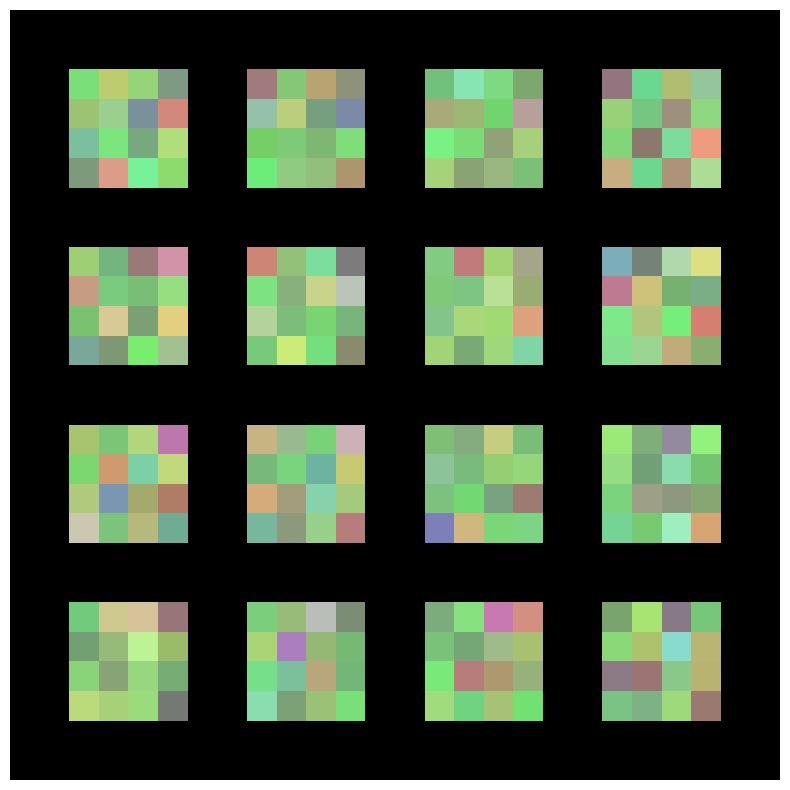

Layer 1: Loss_D: 1.9462904930114746, Loss_G: 0.06416893750429153


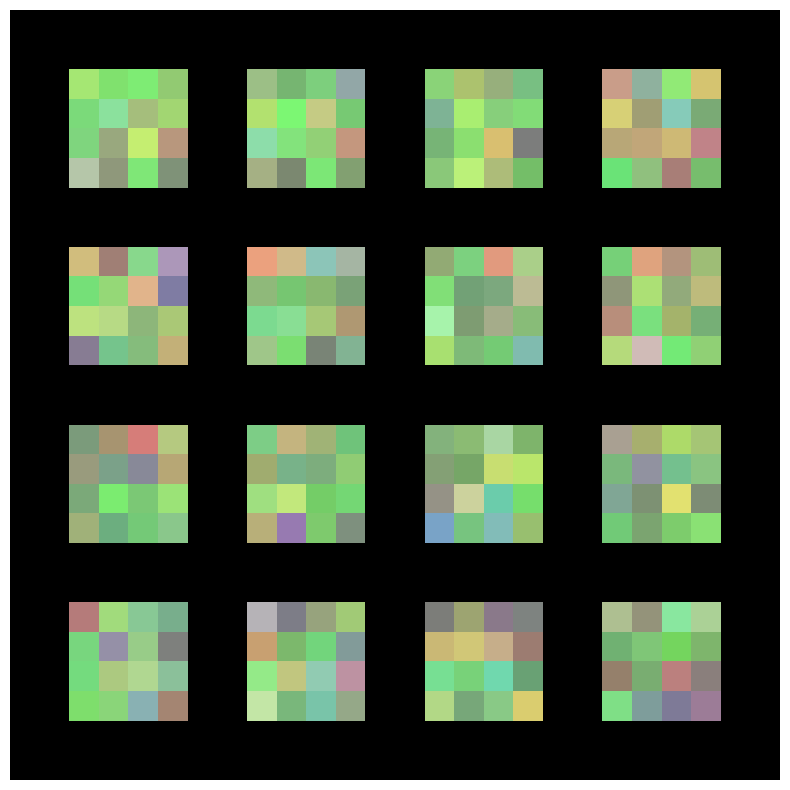

Layer 1: Loss_D: -0.15578593313694, Loss_G: -0.5081163048744202


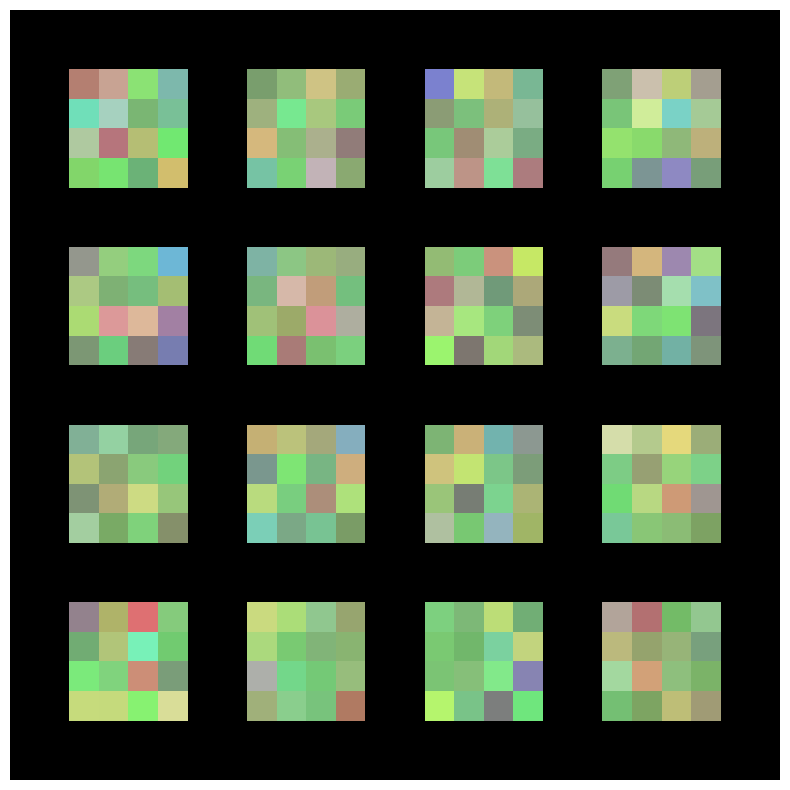

Layer 1: Loss_D: -2.557633638381958, Loss_G: 0.1853221356868744


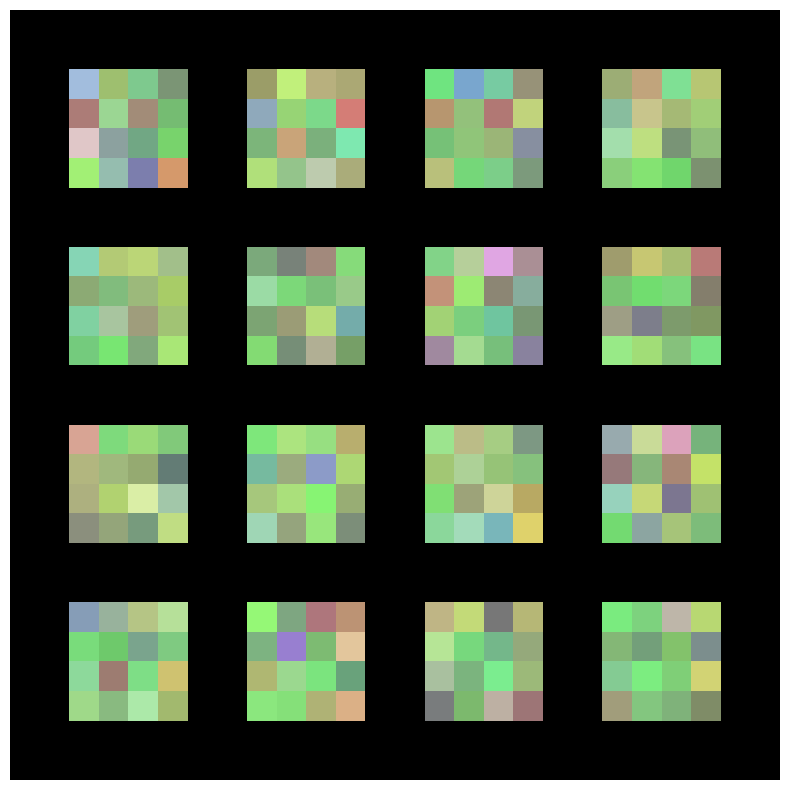

Layer 1: Loss_D: 0.30952921509742737, Loss_G: 0.40468430519104004


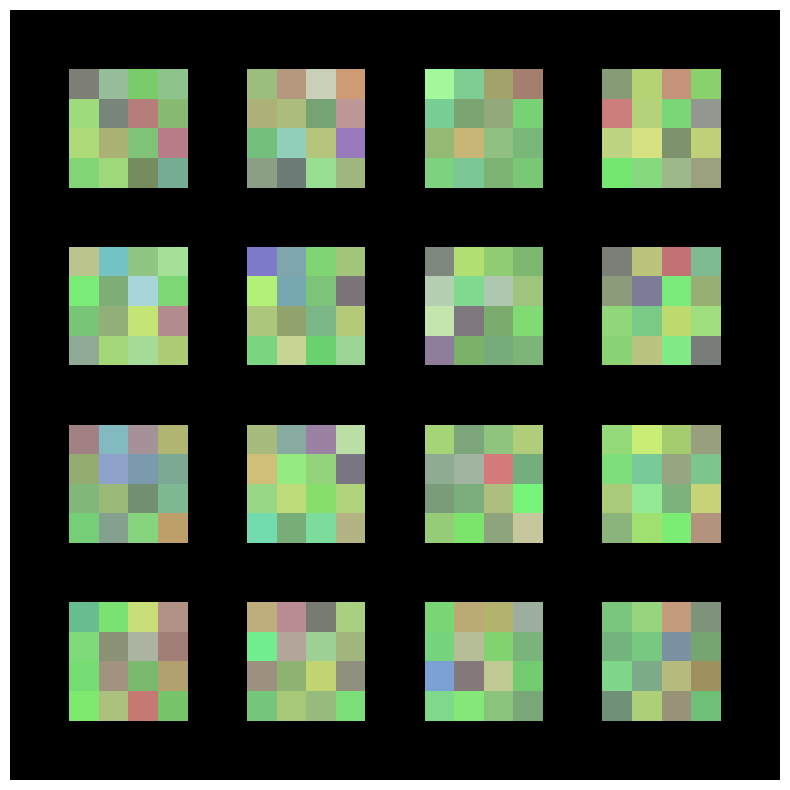

Layer 1: Loss_D: 0.4667019248008728, Loss_G: -0.671894371509552


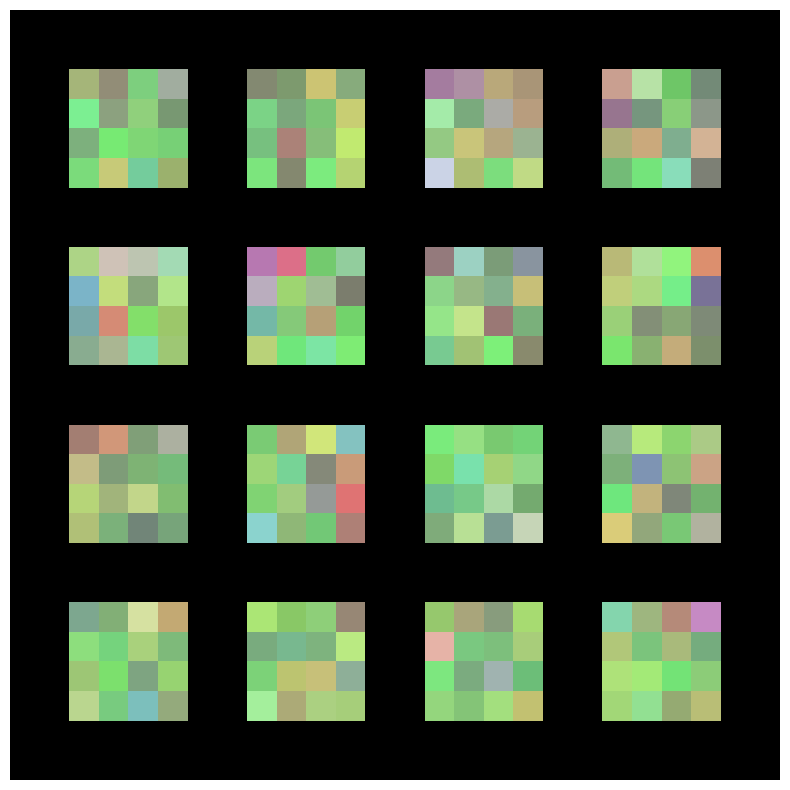

Layer 1: Loss_D: -1.1743395328521729, Loss_G: 0.2748291790485382


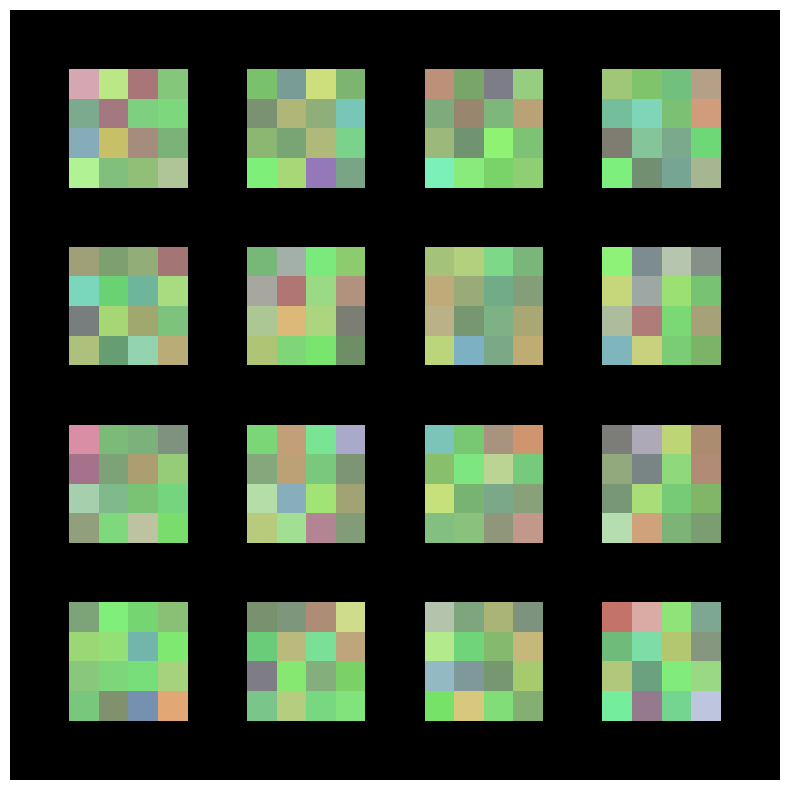

Layer 1: Loss_D: -1.261854648590088, Loss_G: -0.2631983160972595


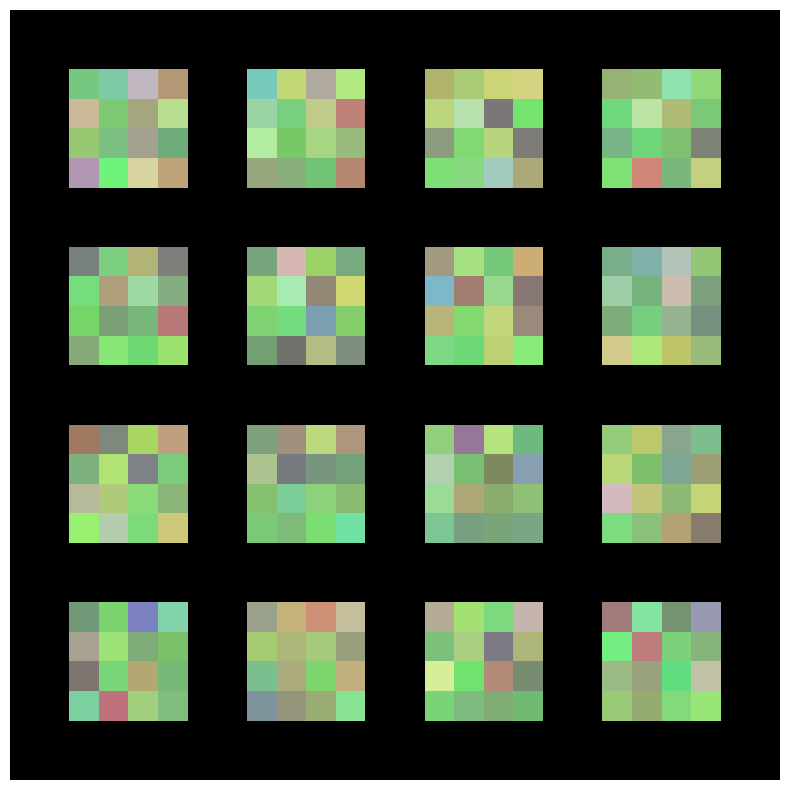

Layer 1: Loss_D: 0.7298712730407715, Loss_G: -0.3040359914302826


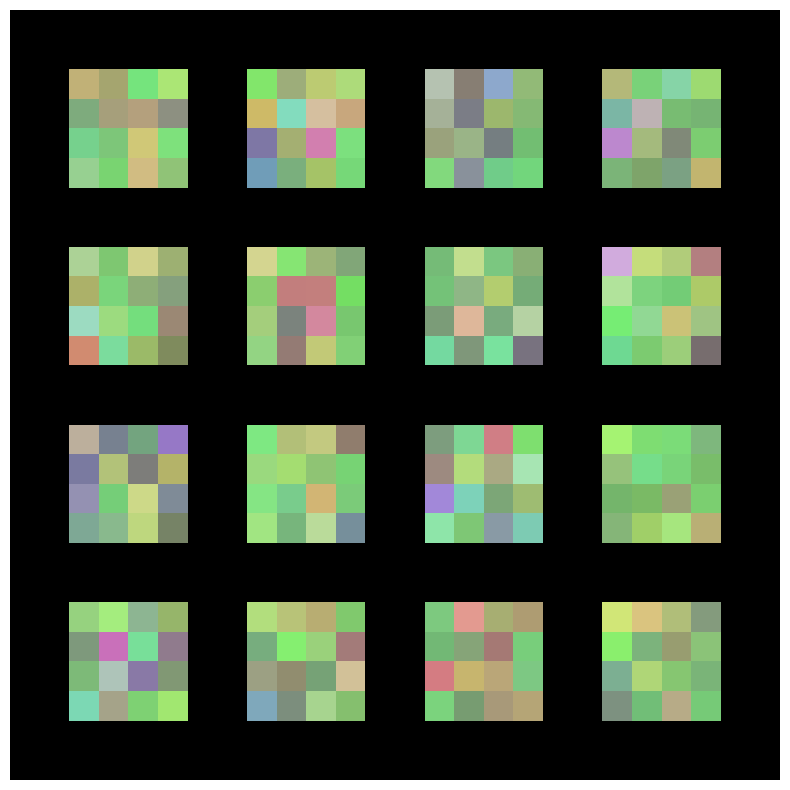

Layer 1: Loss_D: 0.9606621861457825, Loss_G: -0.21375972032546997


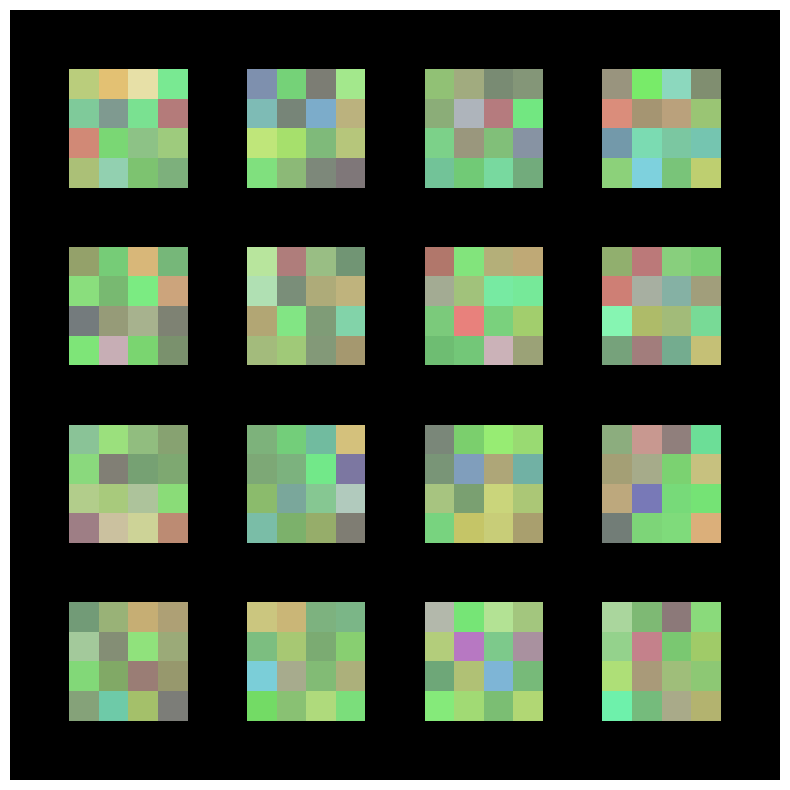

Layer 1: Loss_D: 0.030553067103028297, Loss_G: -0.6823750734329224


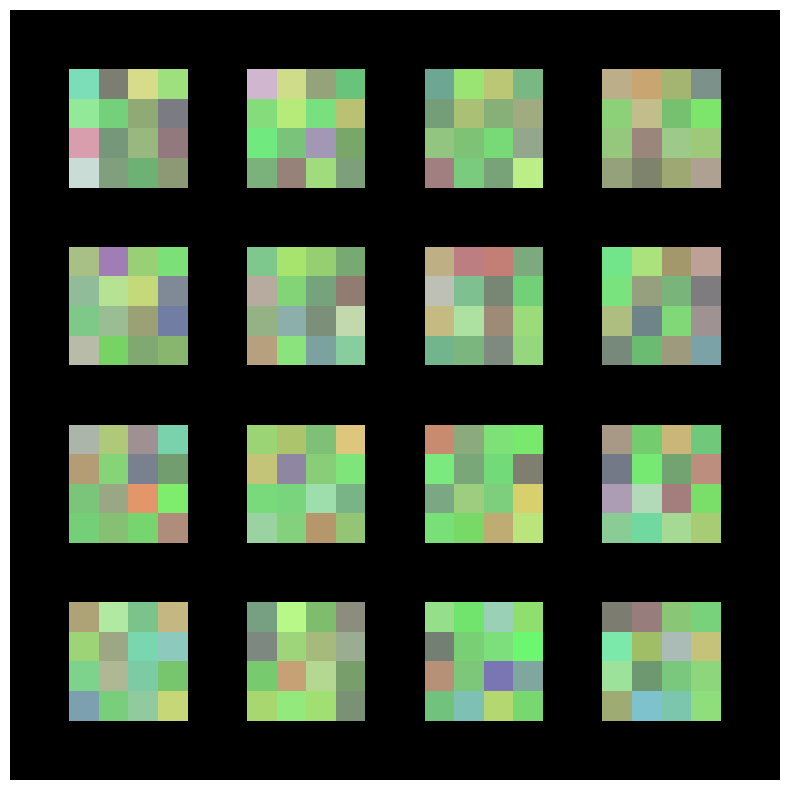

Layer 1: Loss_D: -0.17678992450237274, Loss_G: -1.390170693397522


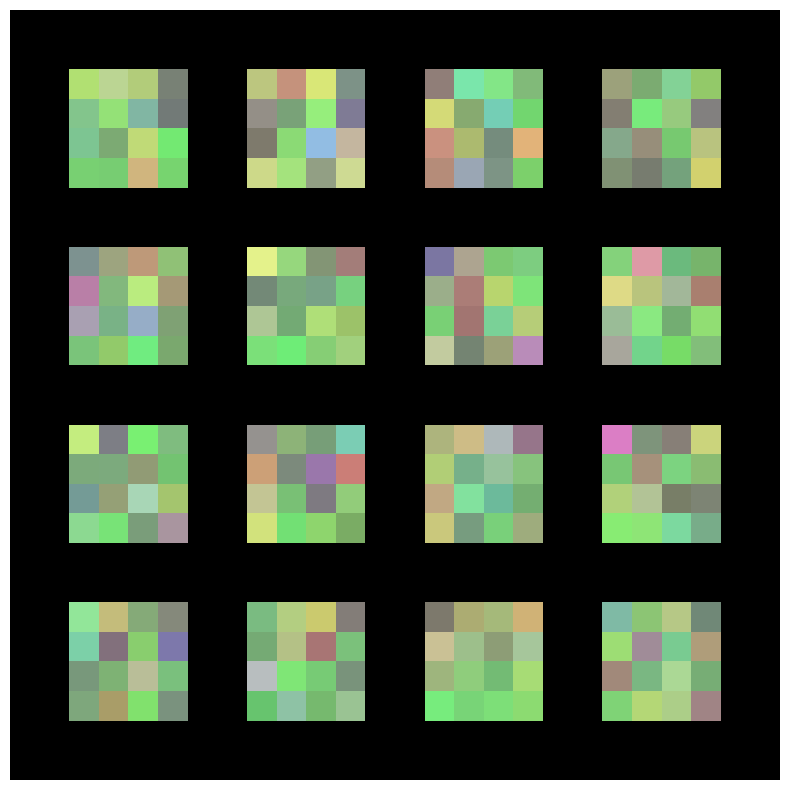

Layer 1: Loss_D: 1.1456260681152344, Loss_G: 0.07299059629440308


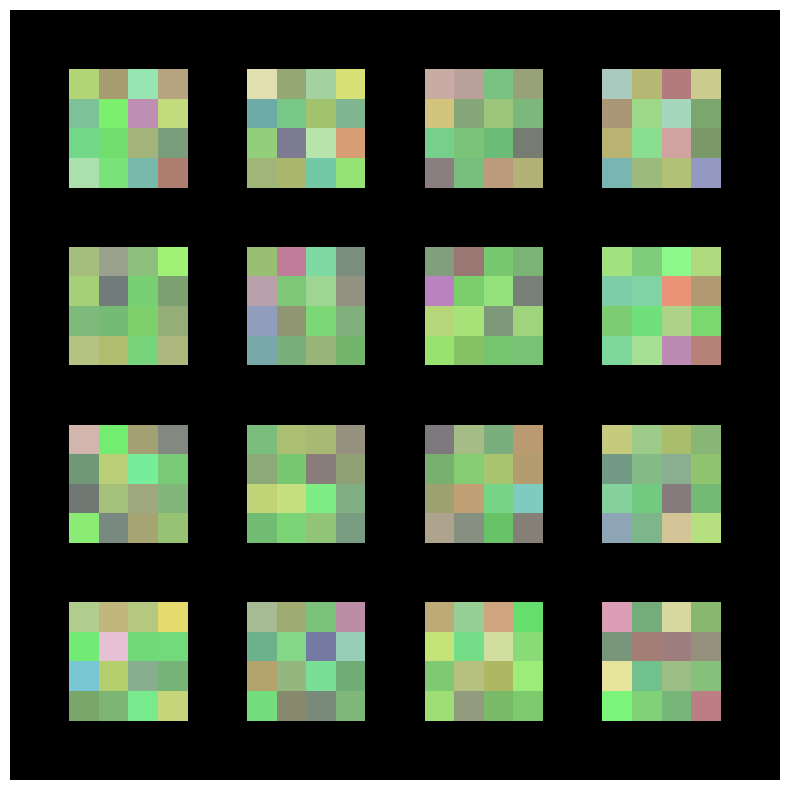

Layer 1: Loss_D: -0.07902096956968307, Loss_G: 0.20483621954917908


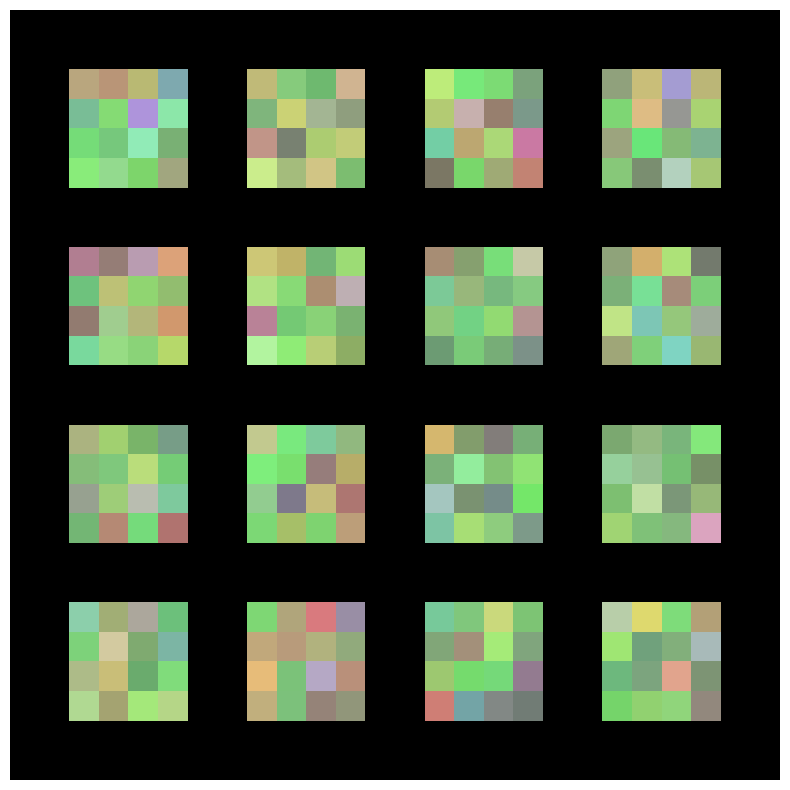

Layer 1: Loss_D: 0.6551831960678101, Loss_G: -0.6495025157928467


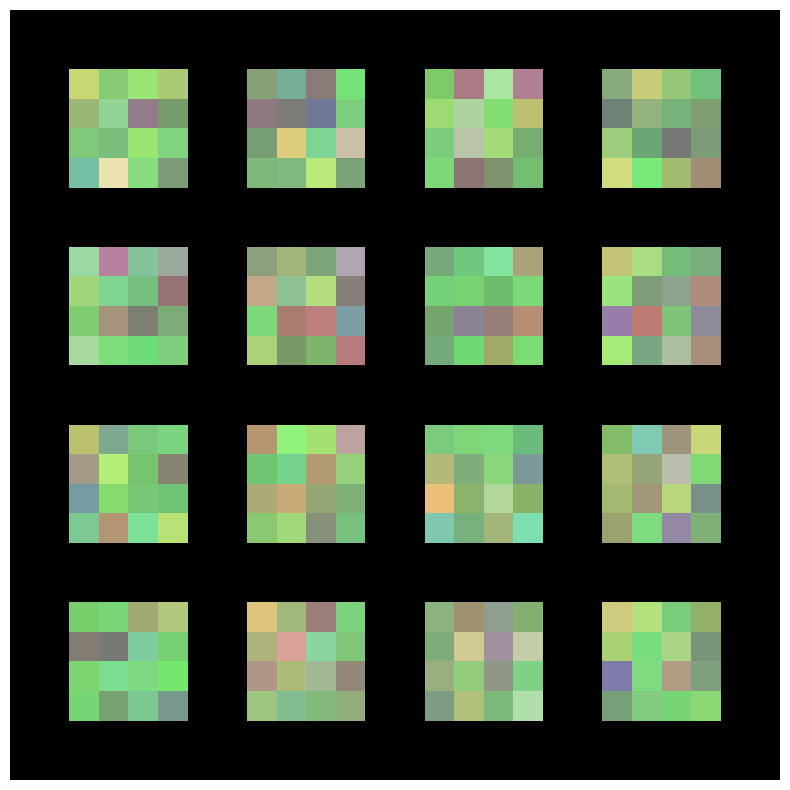

Layer 1: Loss_D: 0.6905176043510437, Loss_G: -0.4789191484451294


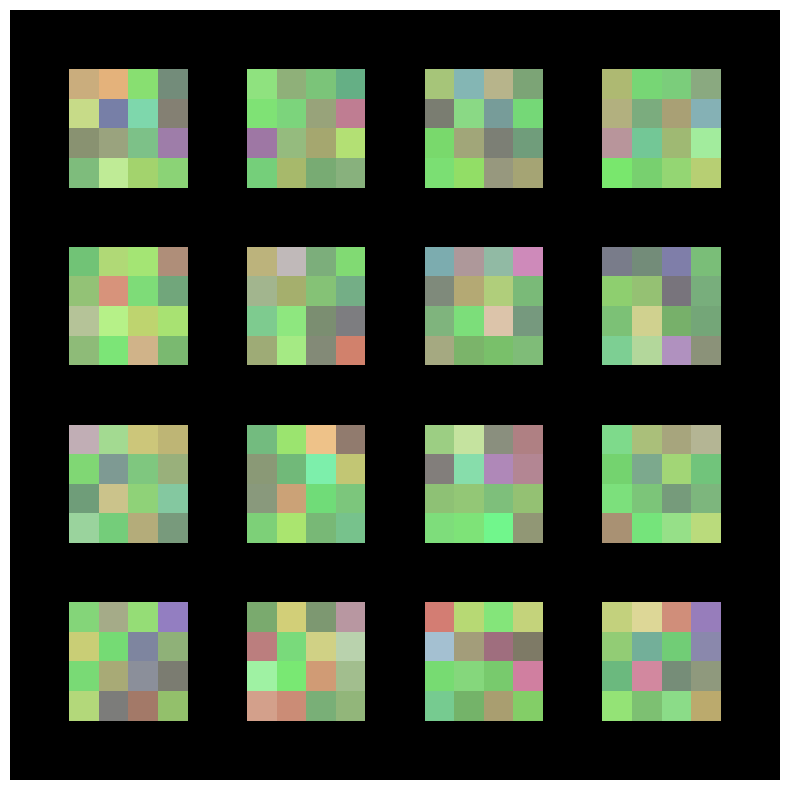

Layer 1: Loss_D: 1.7509435415267944, Loss_G: -0.6086185574531555


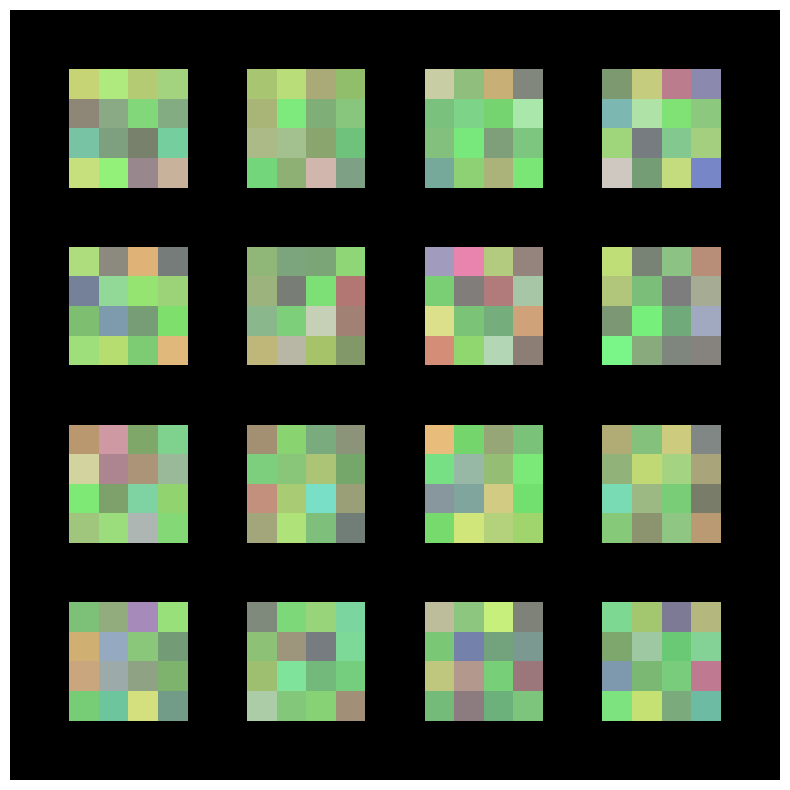

Layer 1: Loss_D: 1.7431211471557617, Loss_G: -0.6937412619590759


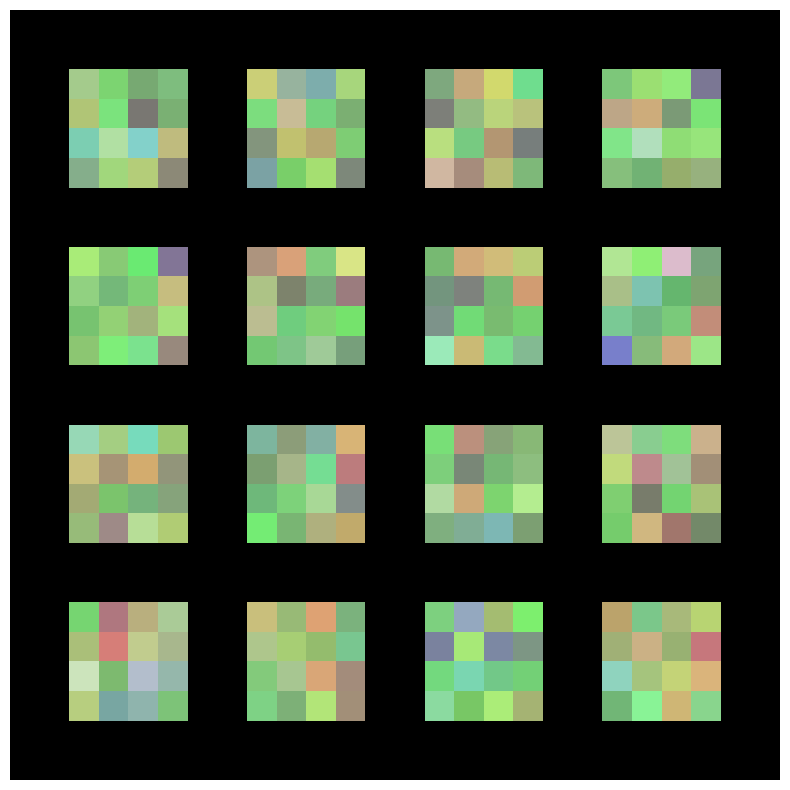

Layer 1: Loss_D: -0.4548419713973999, Loss_G: -0.8453079462051392


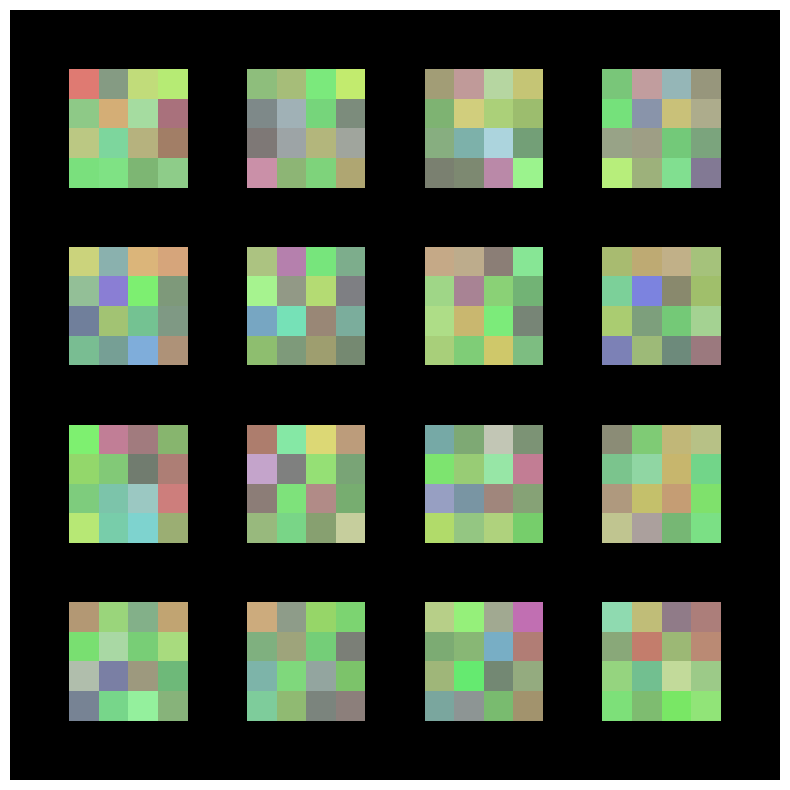

Layer 1: Loss_D: -1.4779607057571411, Loss_G: -0.6001555919647217


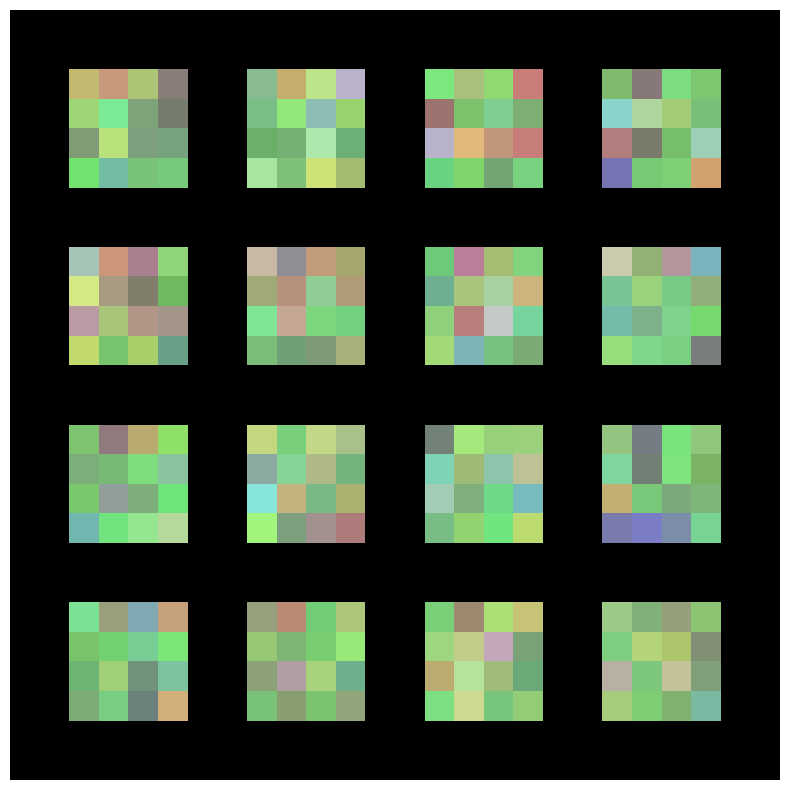

Layer 1: Loss_D: -0.6572390794754028, Loss_G: 1.5420639514923096


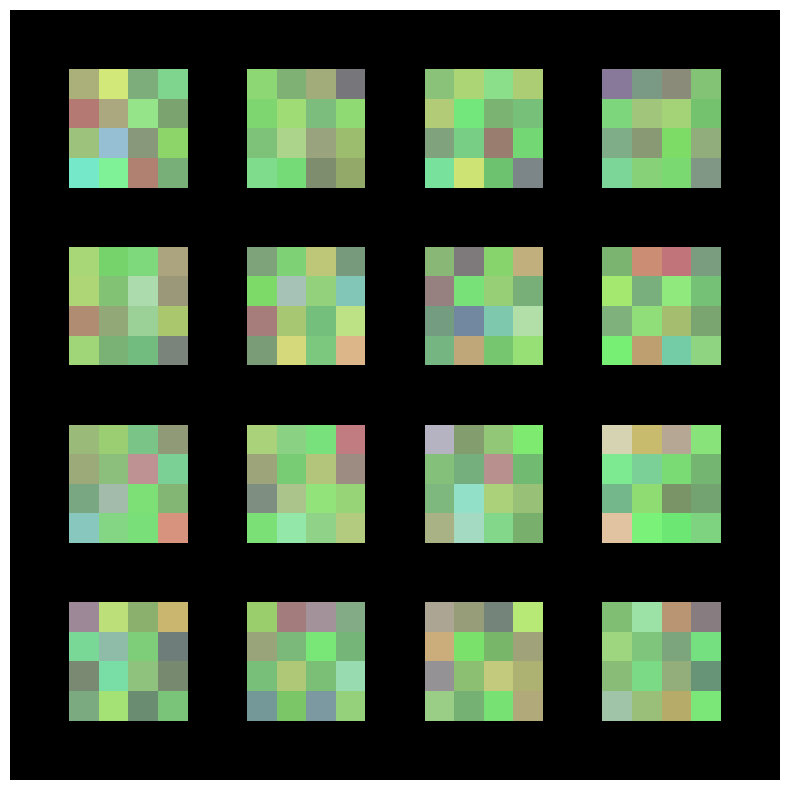

Layer 1: Loss_D: 1.1492342948913574, Loss_G: 0.04548104479908943


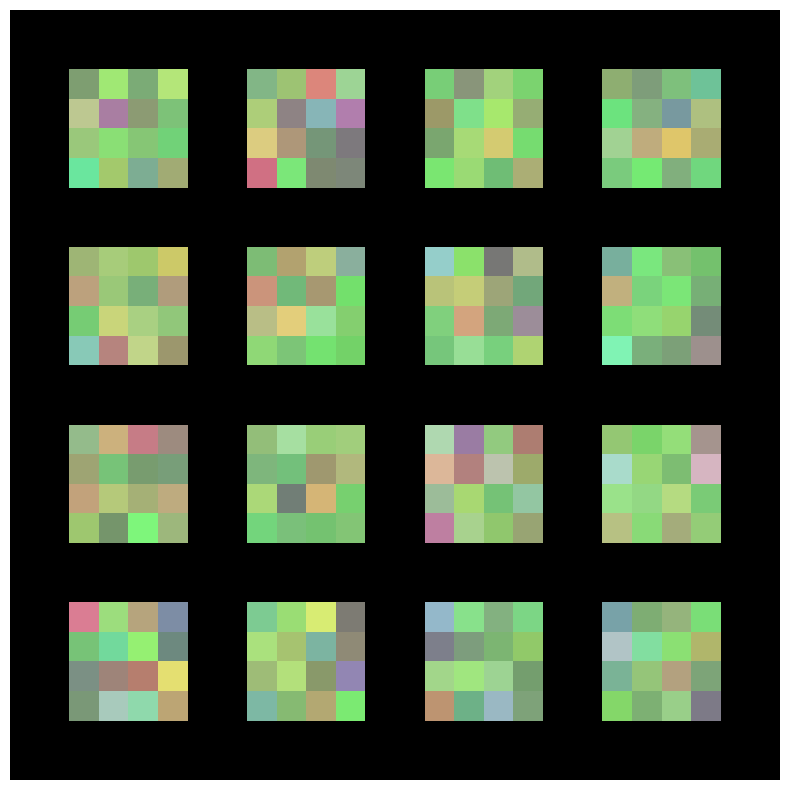

Layer 1: Loss_D: 0.275875985622406, Loss_G: -2.5491251945495605


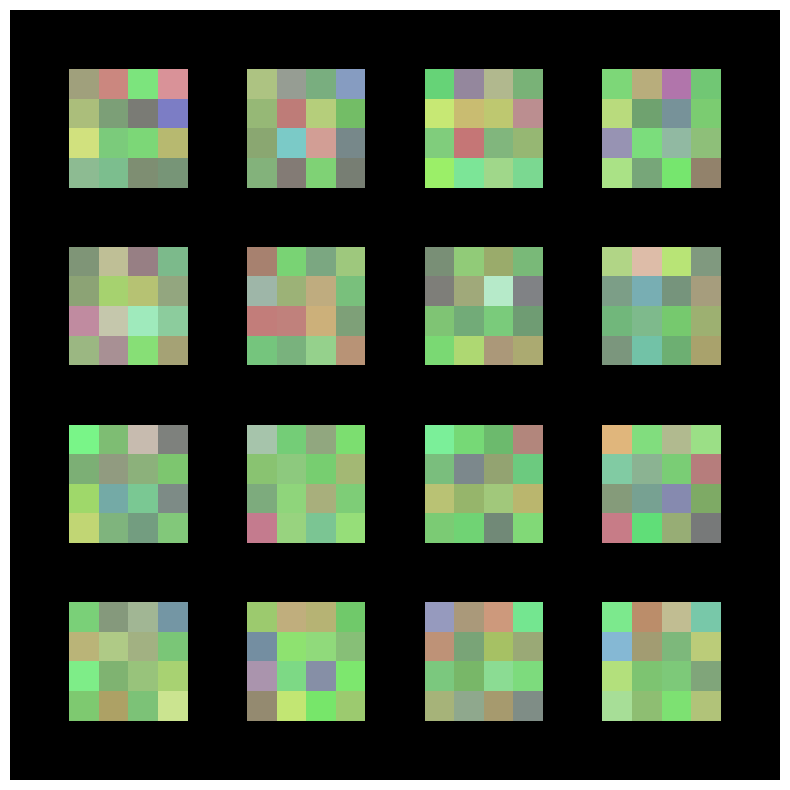

Layer 1: Loss_D: 0.3818286061286926, Loss_G: -1.2298102378845215


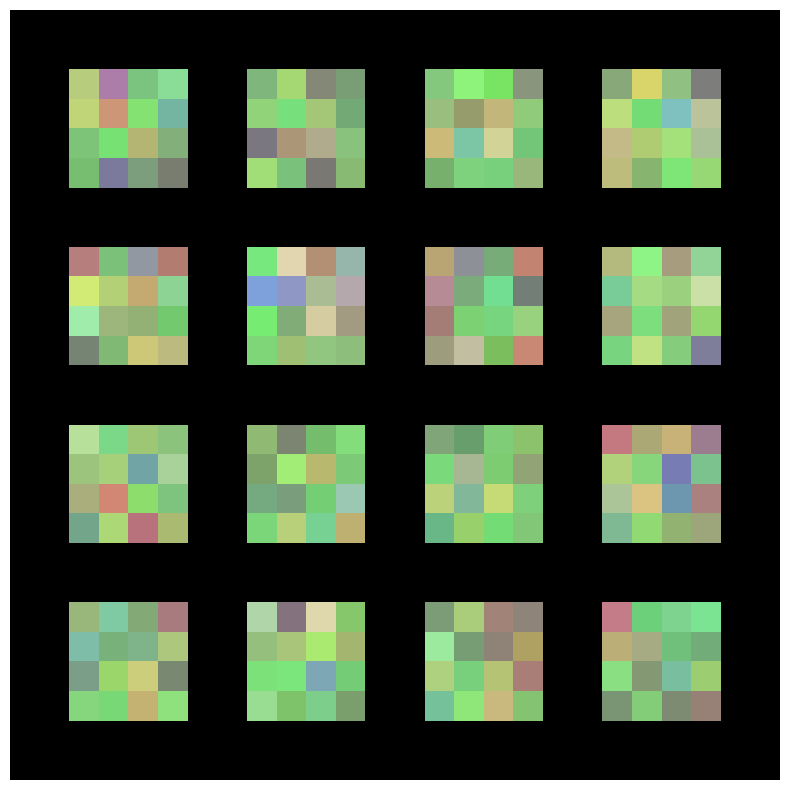

Layer 1: Loss_D: 0.024999411776661873, Loss_G: -1.1199772357940674


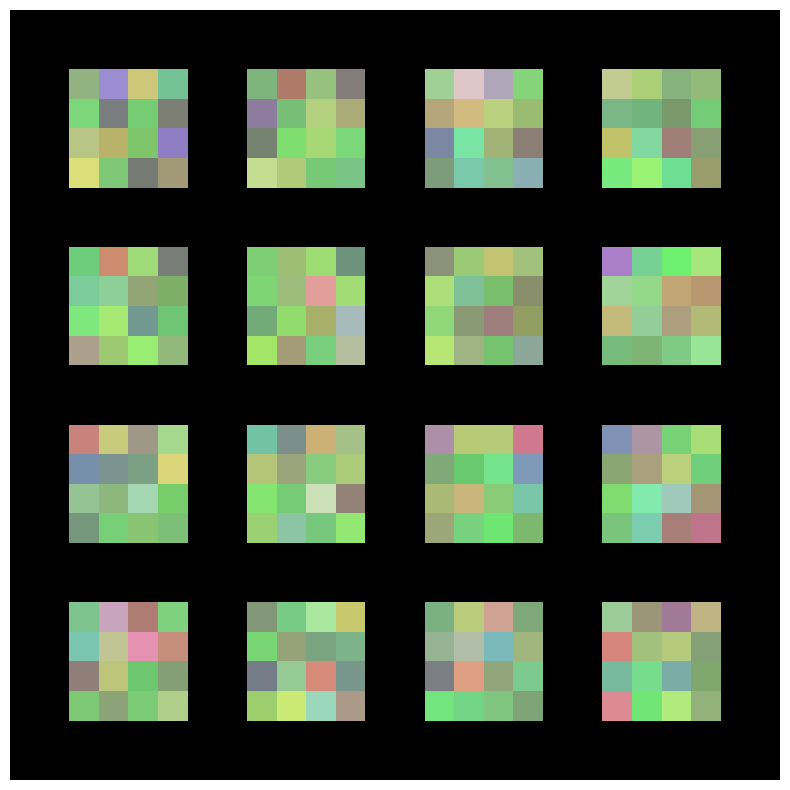

Layer 1: Loss_D: 0.12465759366750717, Loss_G: 0.7126121520996094


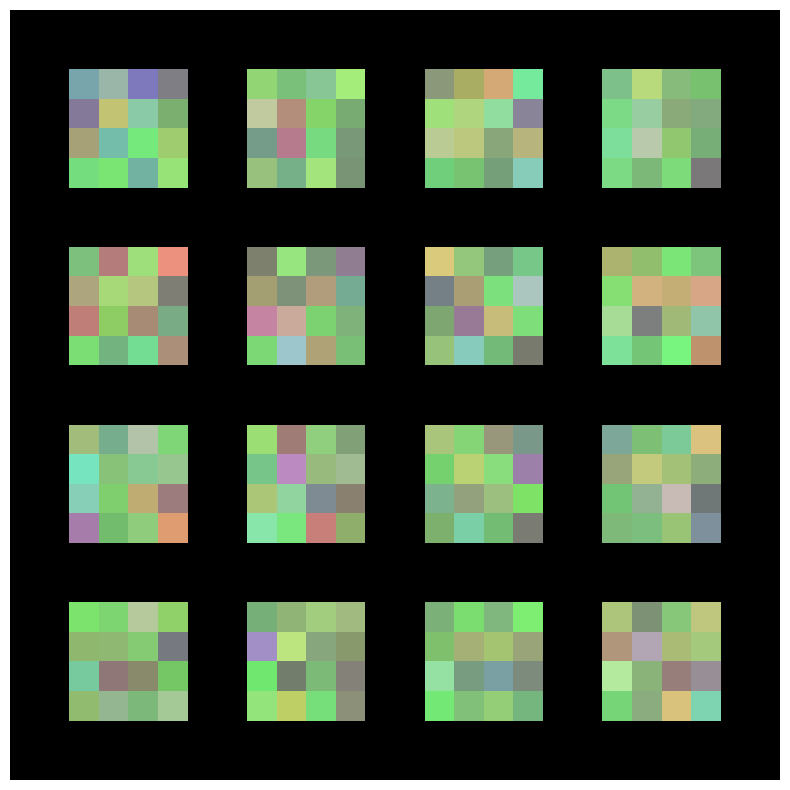

Layer 1: Loss_D: 0.007379806134849787, Loss_G: -0.6803559064865112


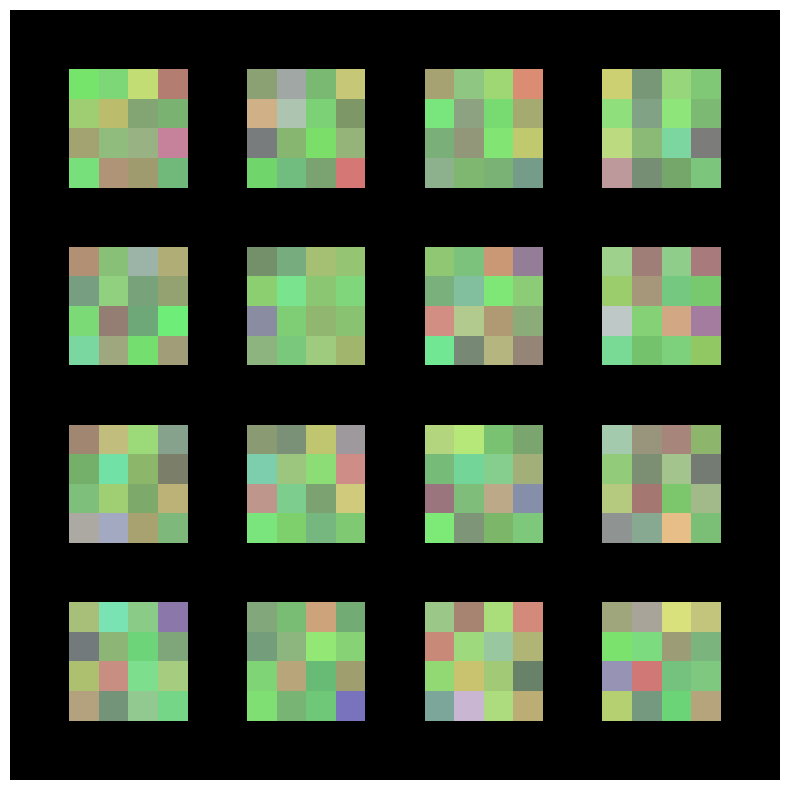

Layer 1: Loss_D: -0.028199322521686554, Loss_G: 0.19439861178398132


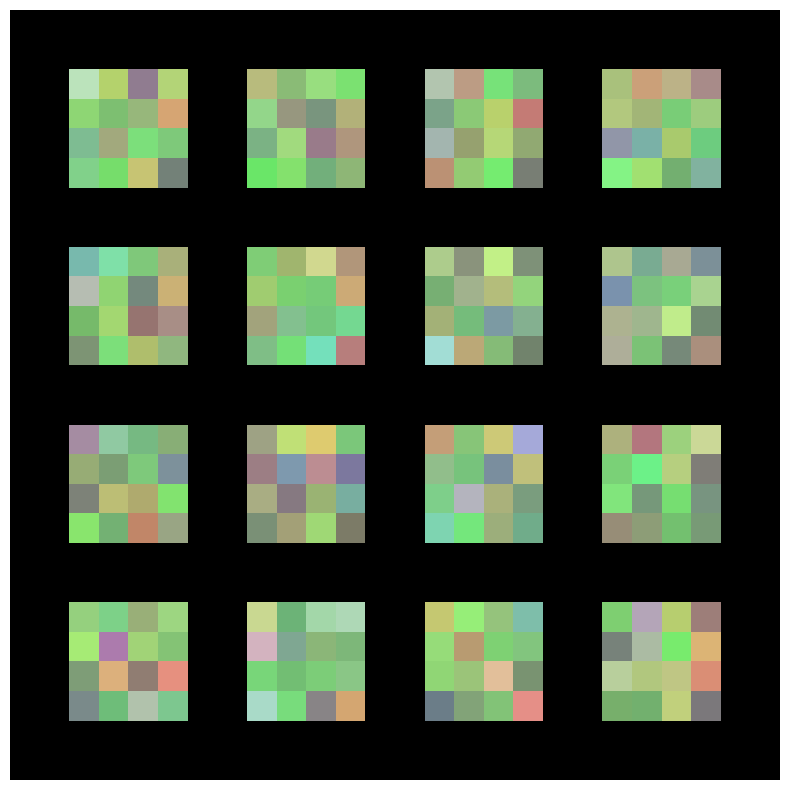

Layer 1: Loss_D: -0.5846463441848755, Loss_G: -0.19565440714359283


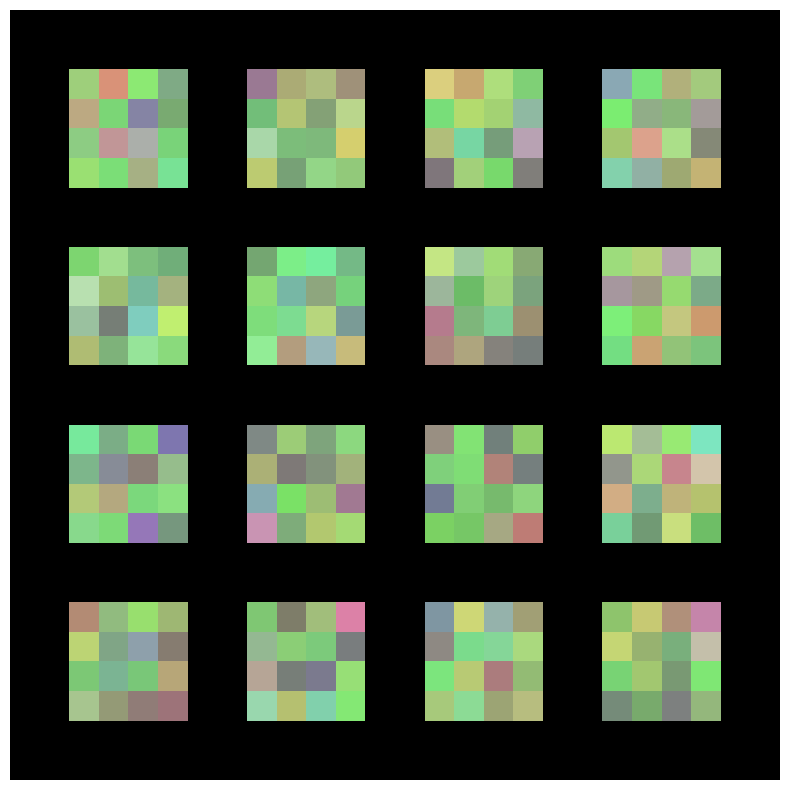

Layer 1: Loss_D: 0.5408735275268555, Loss_G: -0.25572365522384644


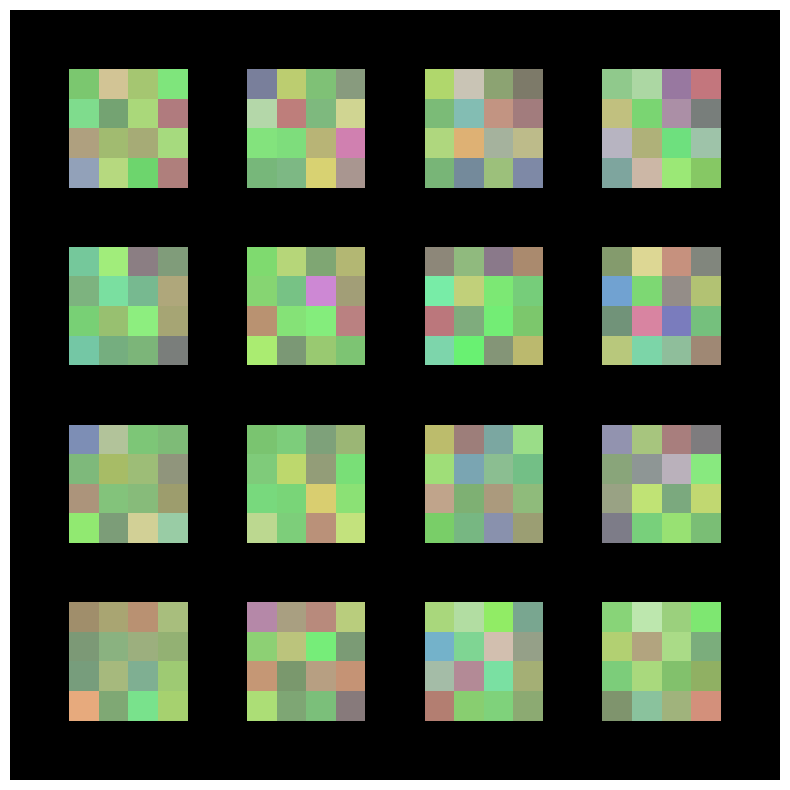

Layer 1: Loss_D: -1.2713851928710938, Loss_G: -0.020184960216283798


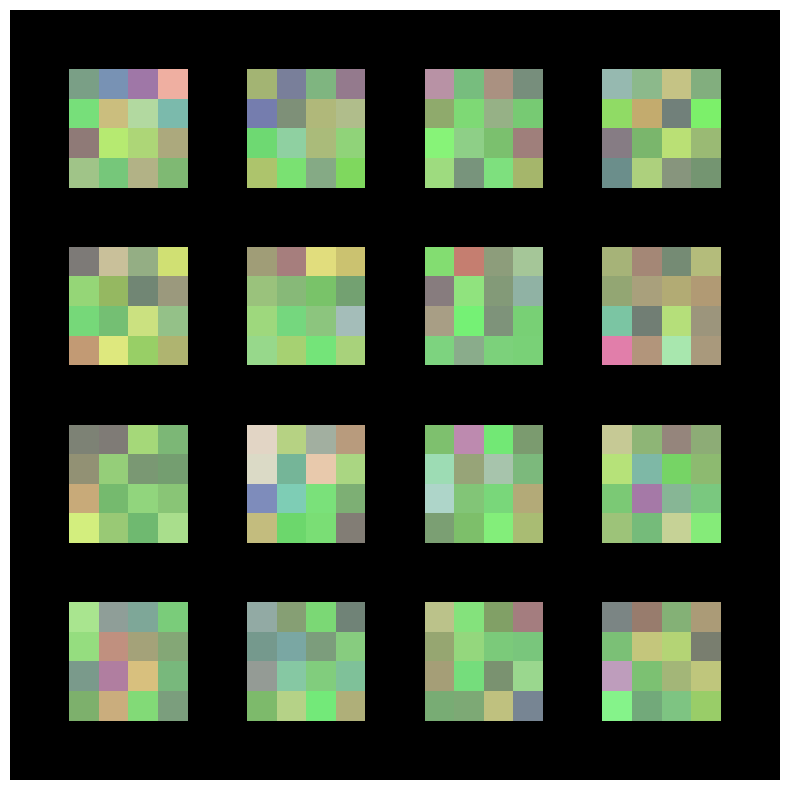

Layer 1: Loss_D: -0.706074595451355, Loss_G: 0.5936417579650879


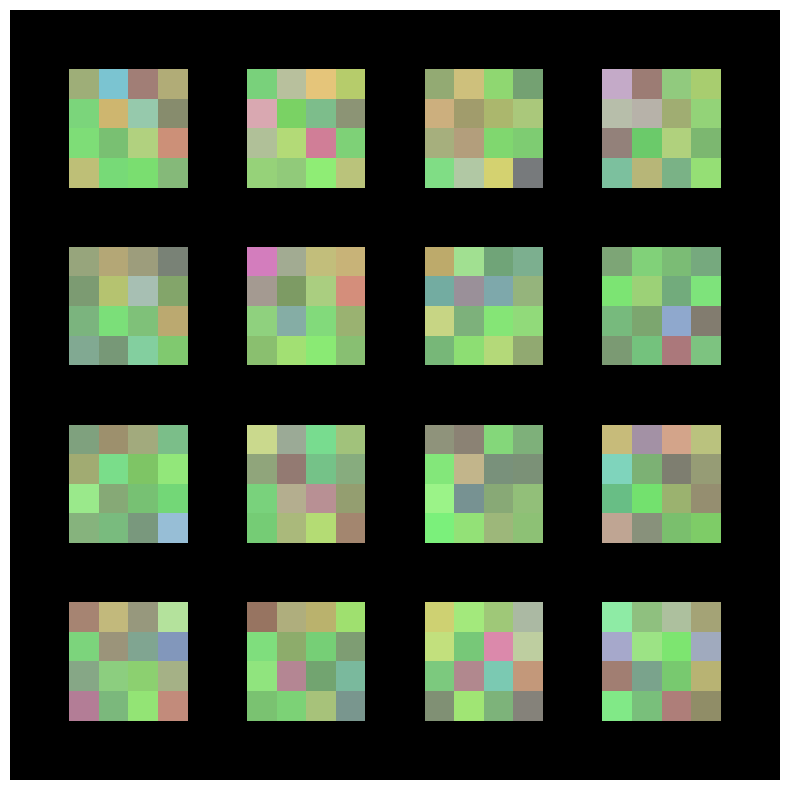

Layer 1: Loss_D: 0.513183057308197, Loss_G: -1.292510747909546


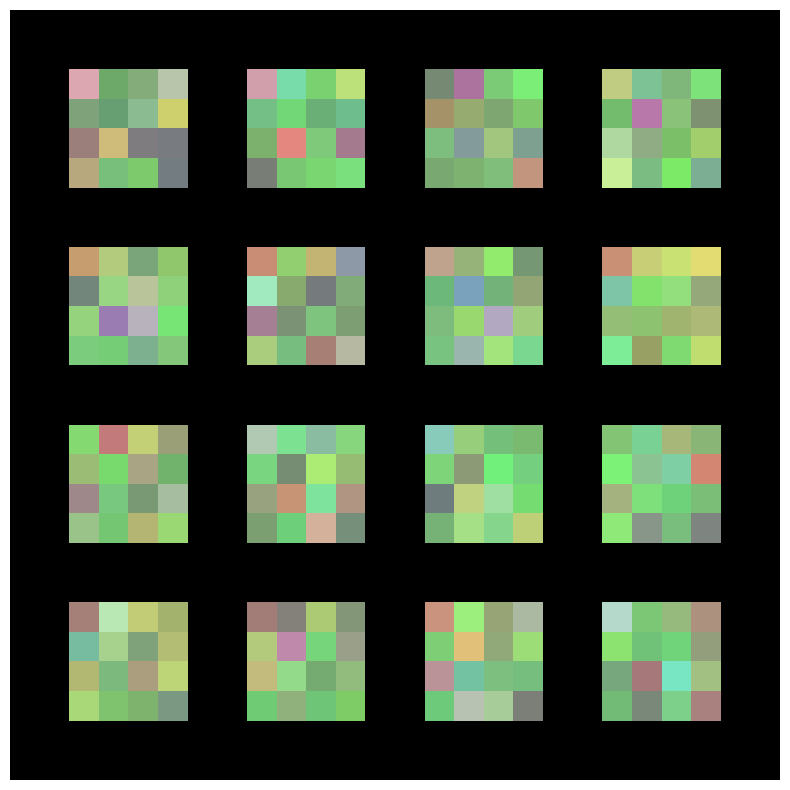

Layer 1: Loss_D: 1.1305958032608032, Loss_G: 0.5870952606201172


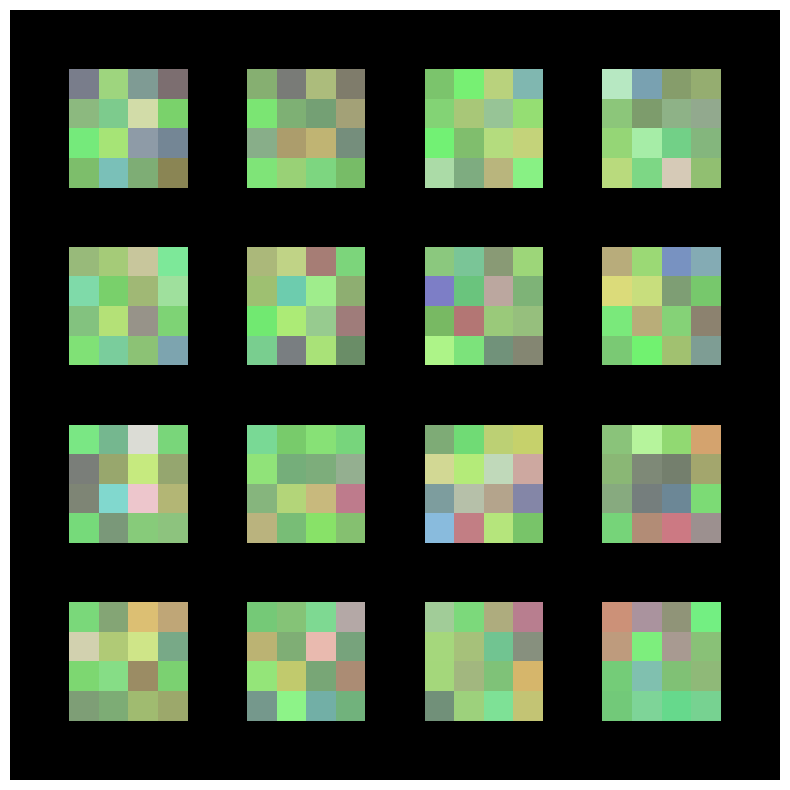

Layer 1: Loss_D: -0.46872425079345703, Loss_G: 0.5355833768844604


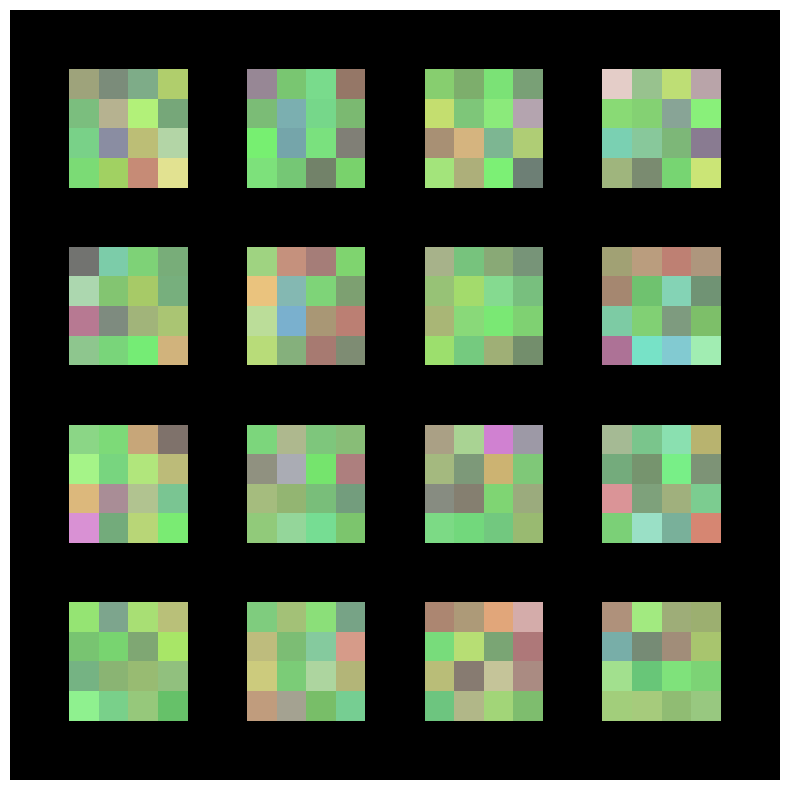

Layer 1: Loss_D: -2.4805562496185303, Loss_G: -1.4301657676696777


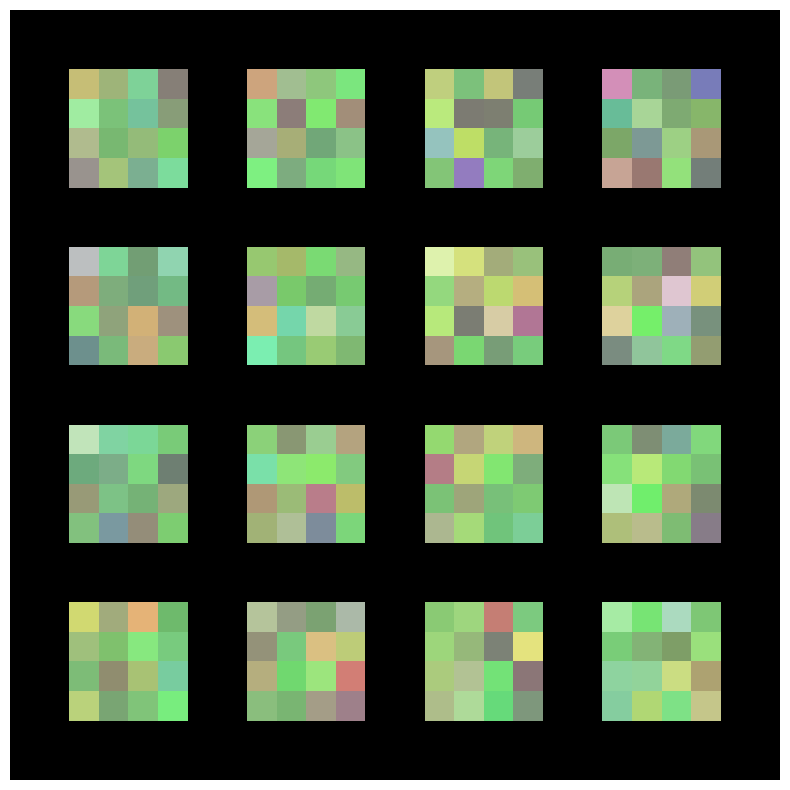

Layer 1: Loss_D: 1.6753699779510498, Loss_G: -1.2304519414901733


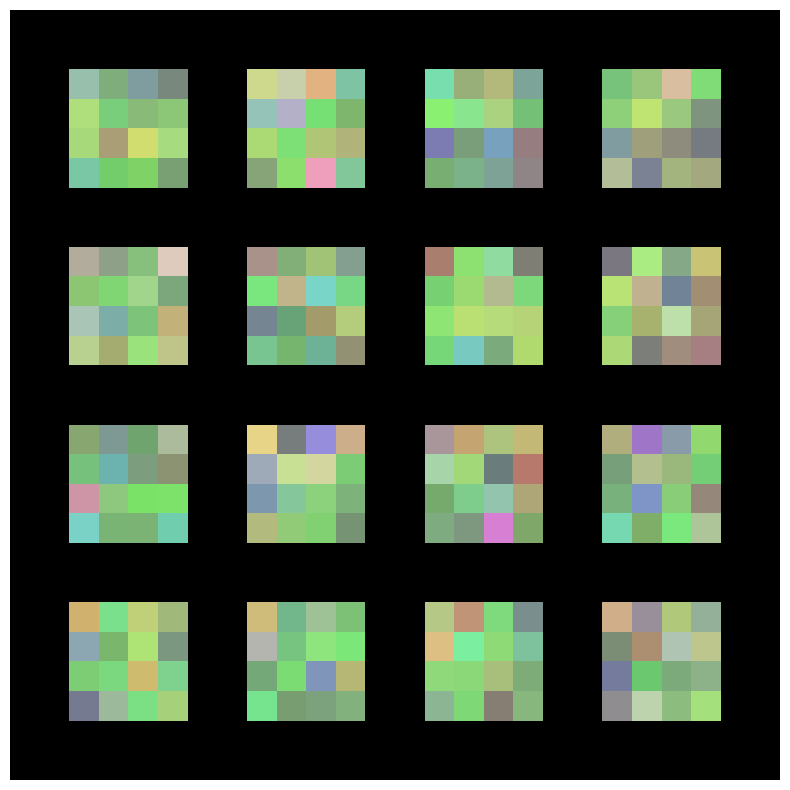

Layer 1: Loss_D: -0.41684380173683167, Loss_G: 1.423760175704956


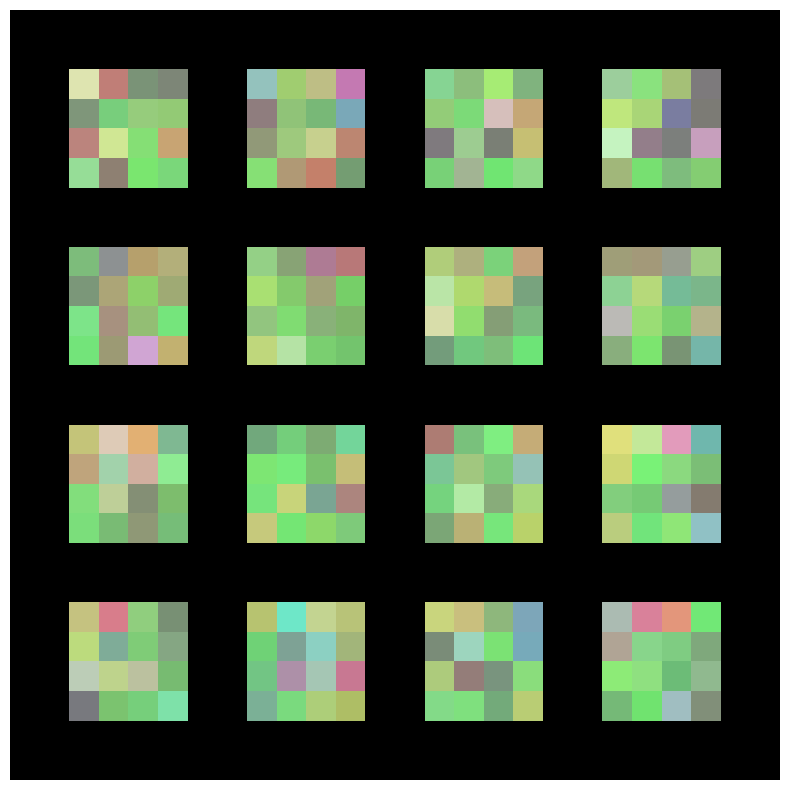

Layer 1: Loss_D: 1.3954615592956543, Loss_G: -0.8184208273887634


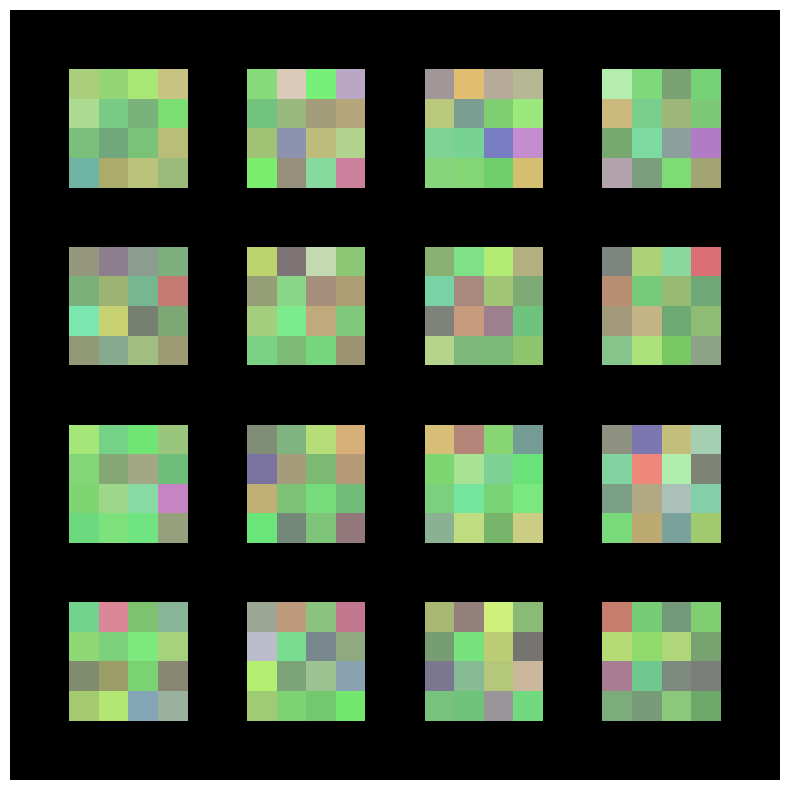

Layer 1: Loss_D: 0.761821448802948, Loss_G: -1.6454057693481445


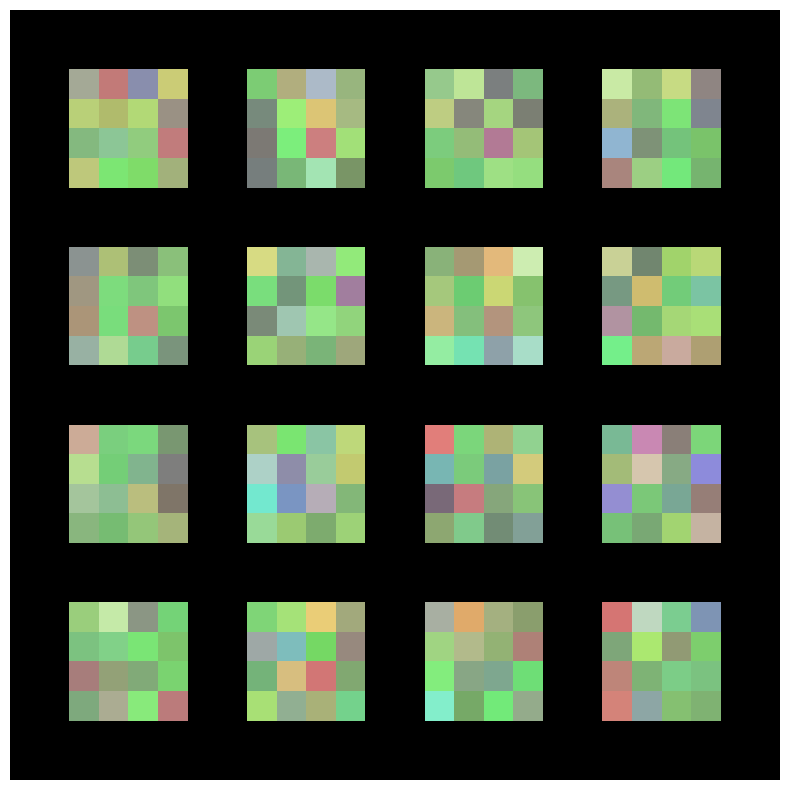

Layer 1: Loss_D: 0.15820029377937317, Loss_G: -0.6674034595489502


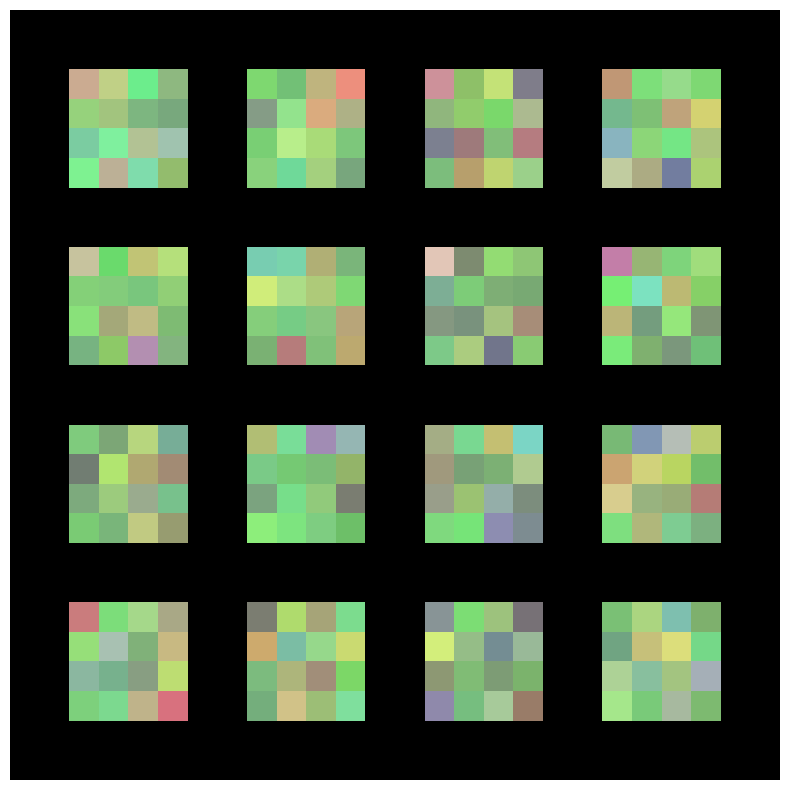

Layer 1: Loss_D: -1.2269660234451294, Loss_G: -0.898208737373352


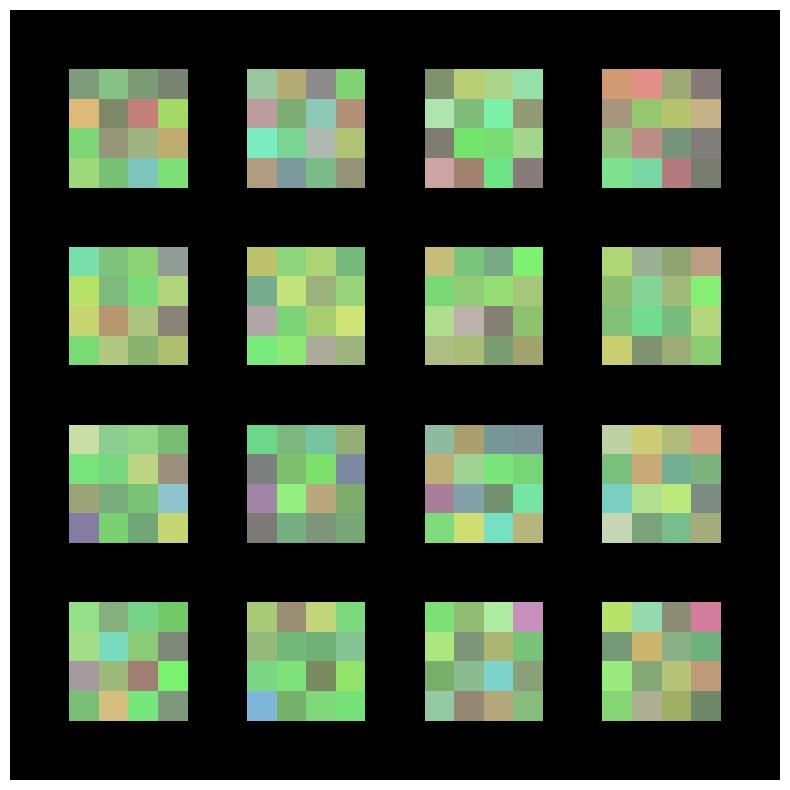

Layer 1: Loss_D: 0.6301856637001038, Loss_G: 0.3550637364387512


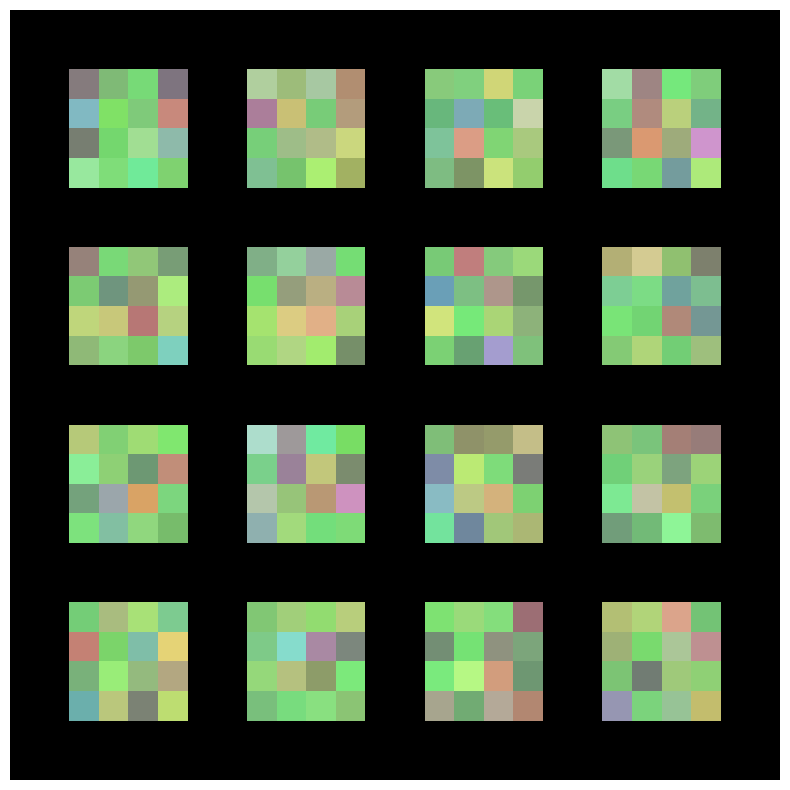

Layer 1: Loss_D: -0.8347092270851135, Loss_G: -0.3724920153617859


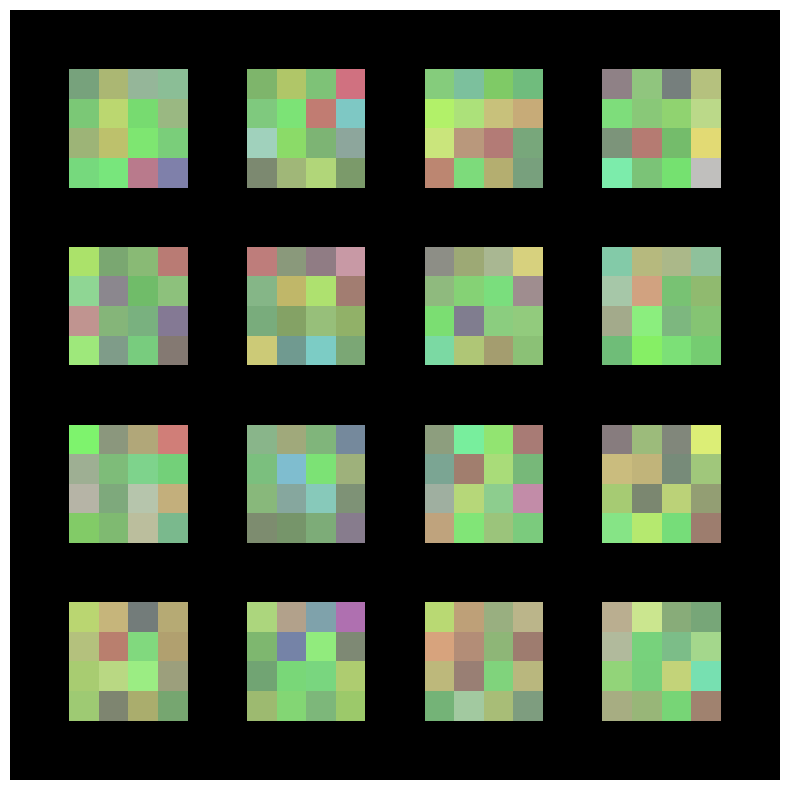

Layer 1: Loss_D: -0.021886562928557396, Loss_G: 0.19167742133140564


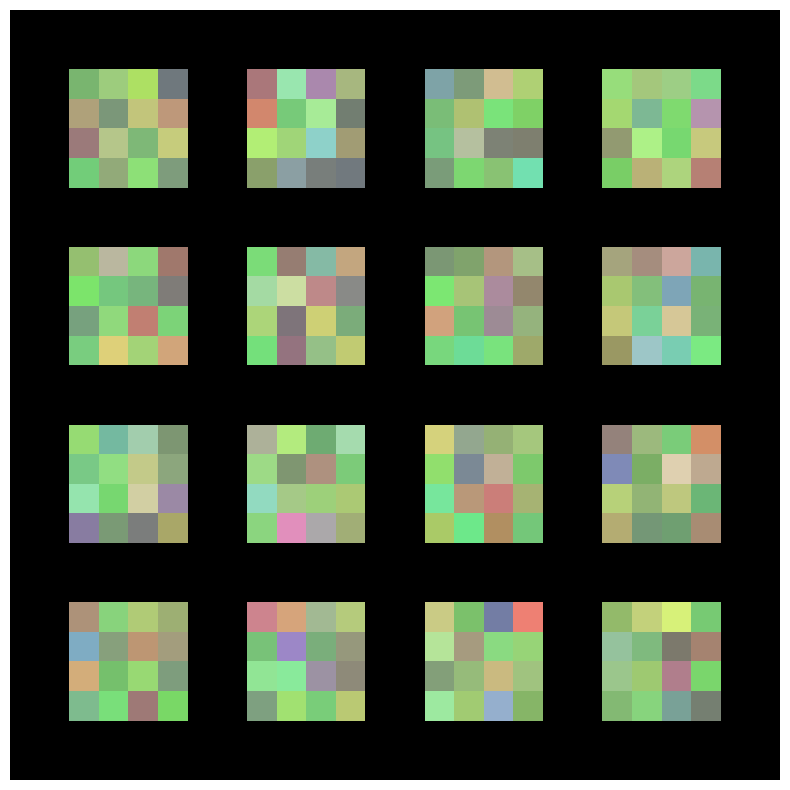

Layer 1: Loss_D: 0.7447782754898071, Loss_G: 0.9000644683837891


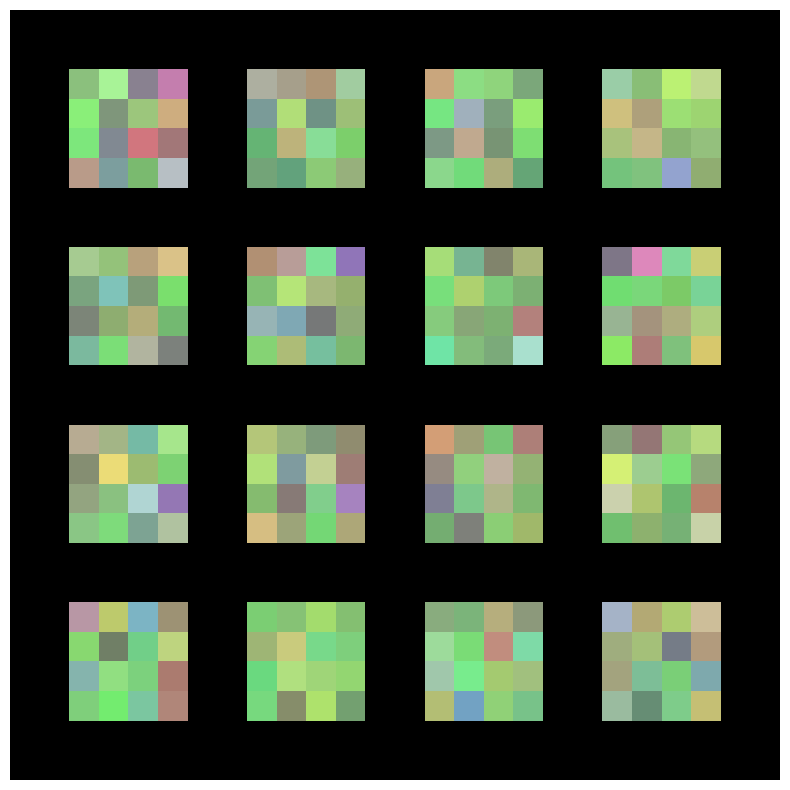

Layer 1: Loss_D: 1.6182518005371094, Loss_G: -0.7483086585998535


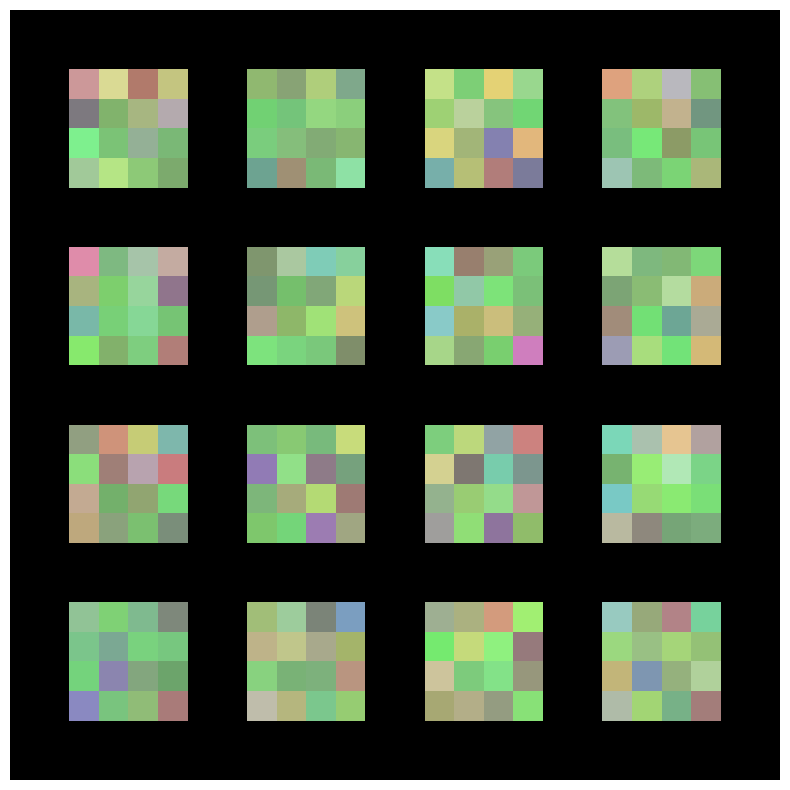

Layer 1: Loss_D: -0.036661963909864426, Loss_G: -0.7586644887924194


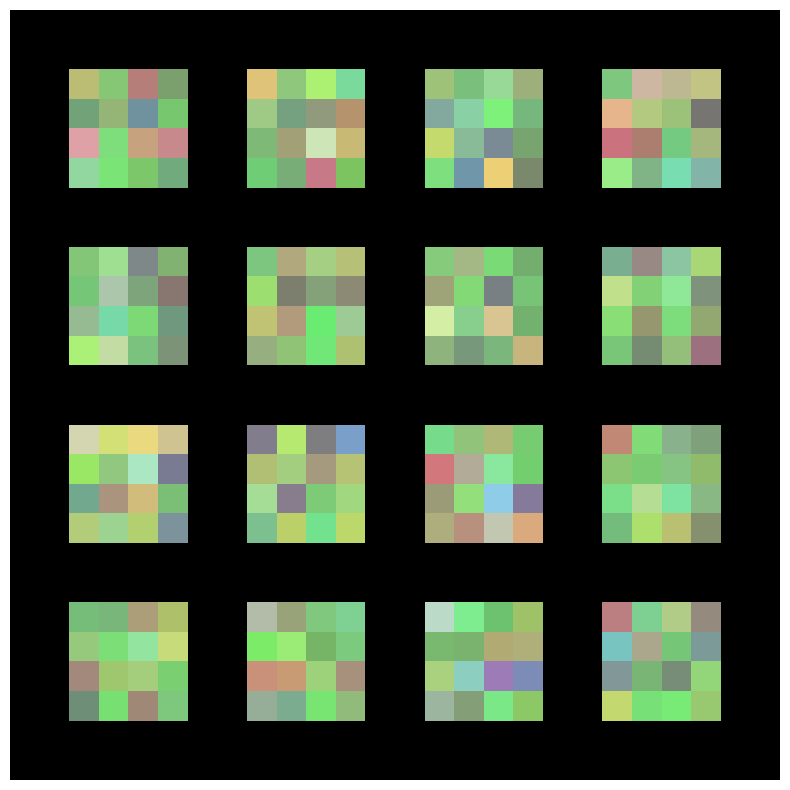

Layer 1: Loss_D: 0.2845330536365509, Loss_G: 0.5915780067443848


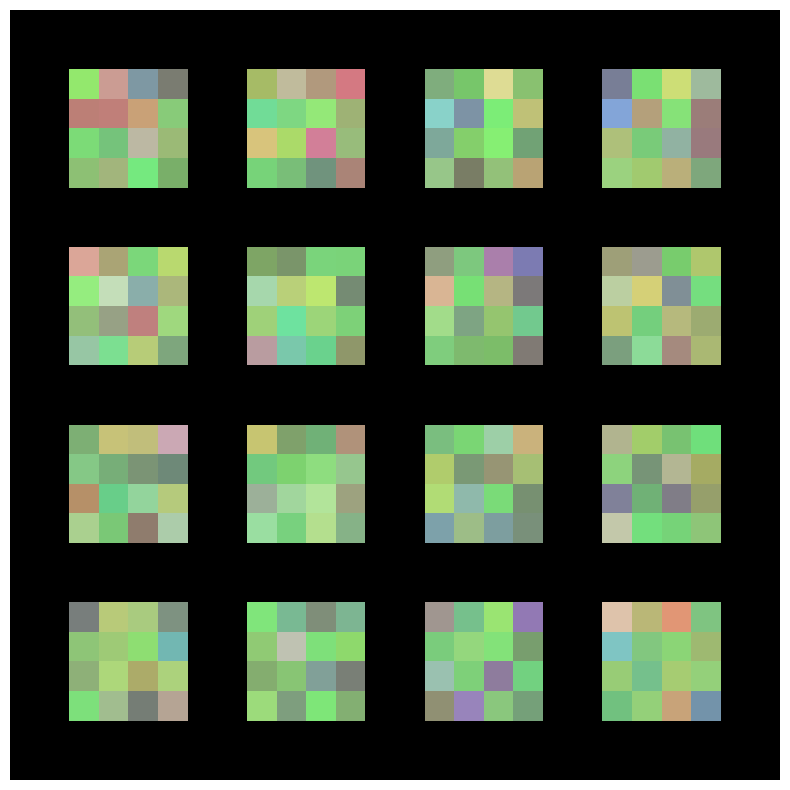

Layer 1: Loss_D: 0.3988345265388489, Loss_G: 0.32705456018447876


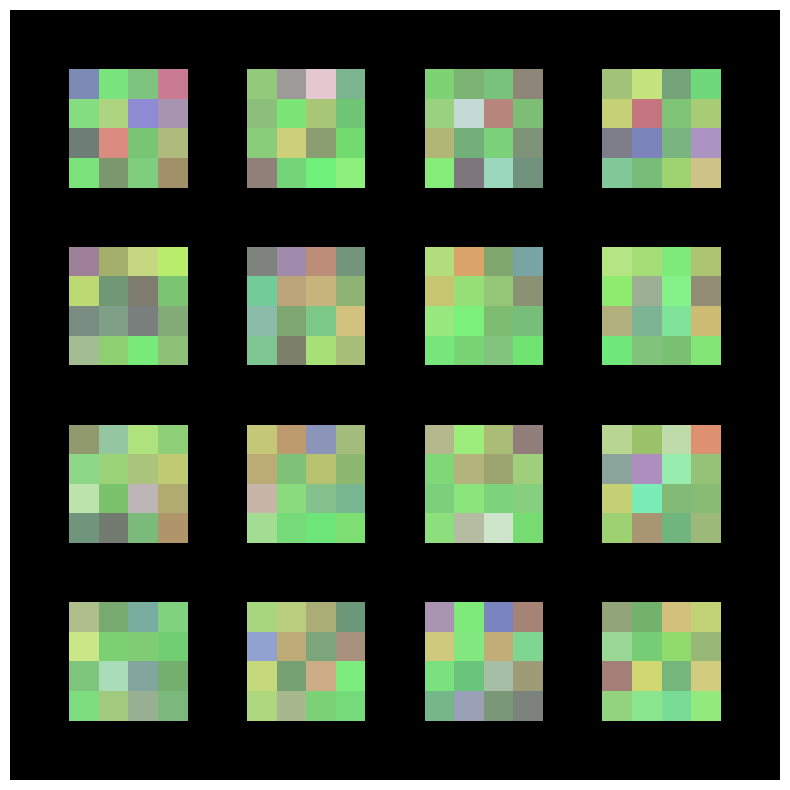

Layer 1: Loss_D: 0.8533564805984497, Loss_G: -0.014100109227001667


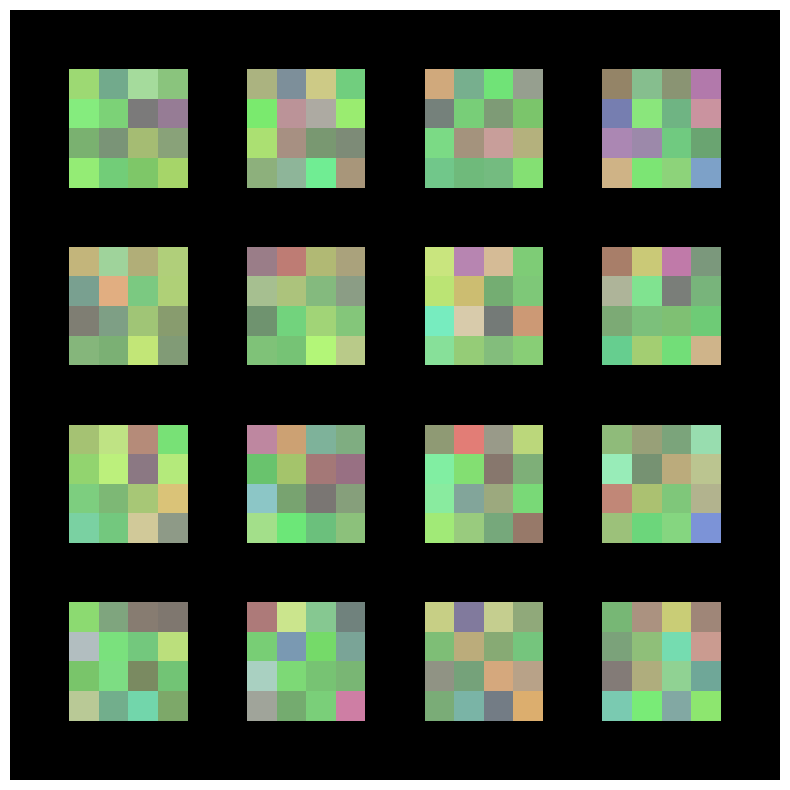

Layer 1: Loss_D: 0.5267117619514465, Loss_G: -0.434528112411499


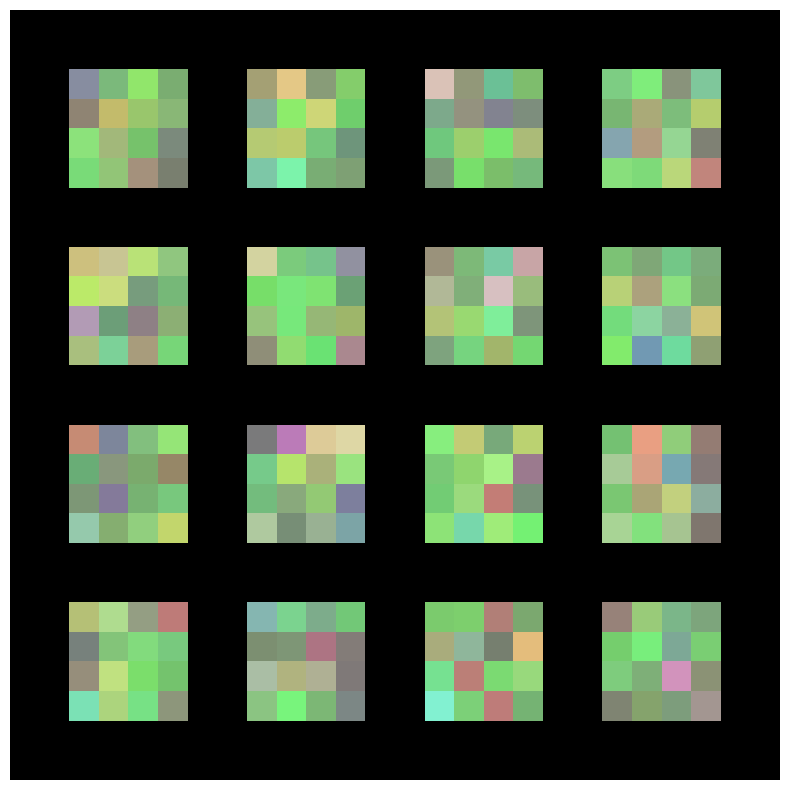

Layer 1: Loss_D: 1.041275143623352, Loss_G: -0.45990413427352905


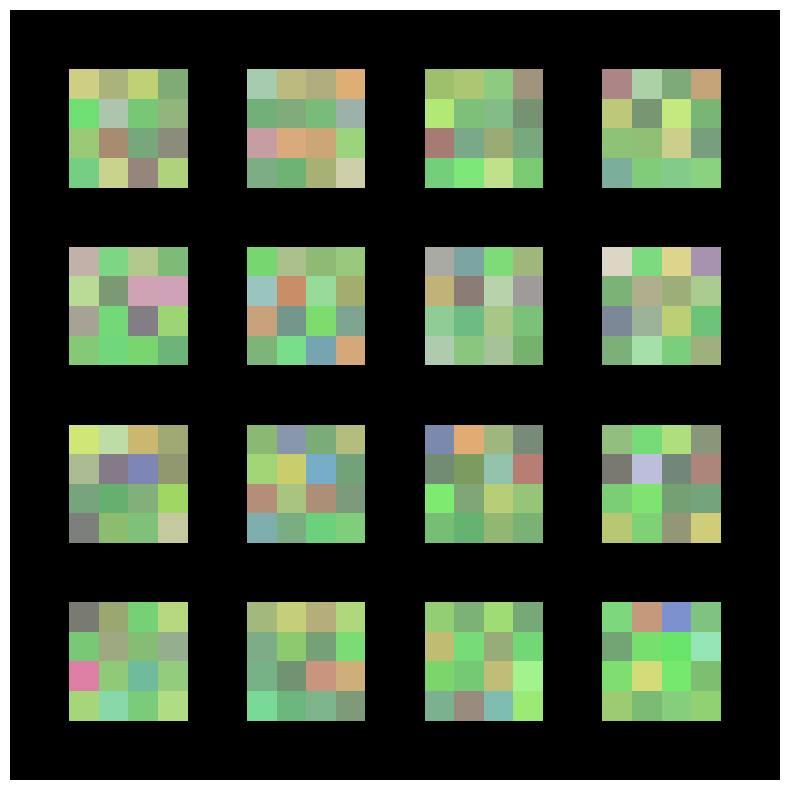

Layer 1: Loss_D: 0.9621279835700989, Loss_G: -1.2174253463745117


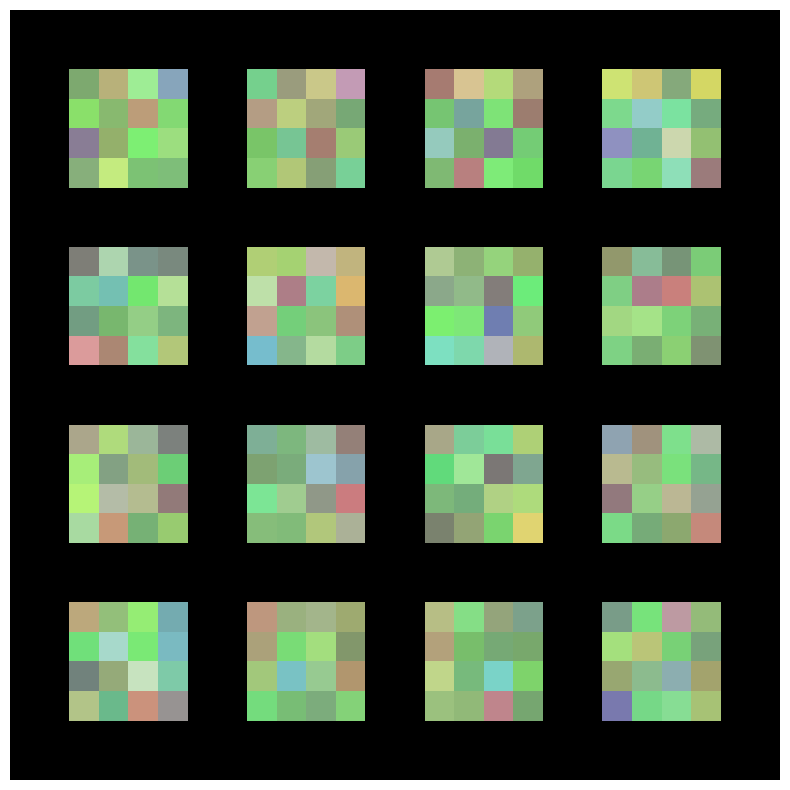

Layer 1: Loss_D: 0.015726571902632713, Loss_G: 2.069033622741699


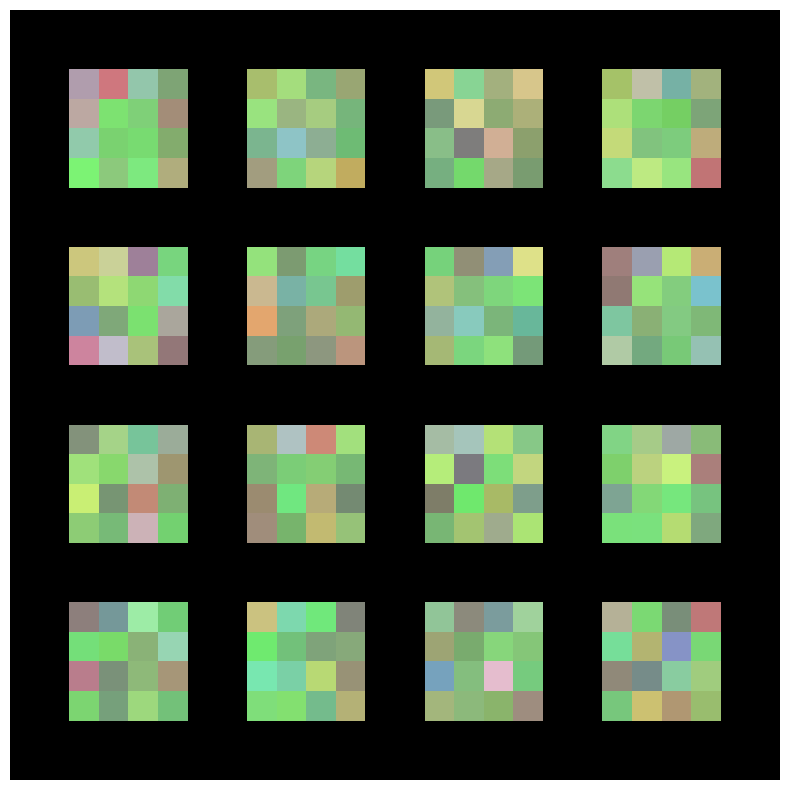

Layer 1: Loss_D: 1.1317130327224731, Loss_G: 0.17923887073993683


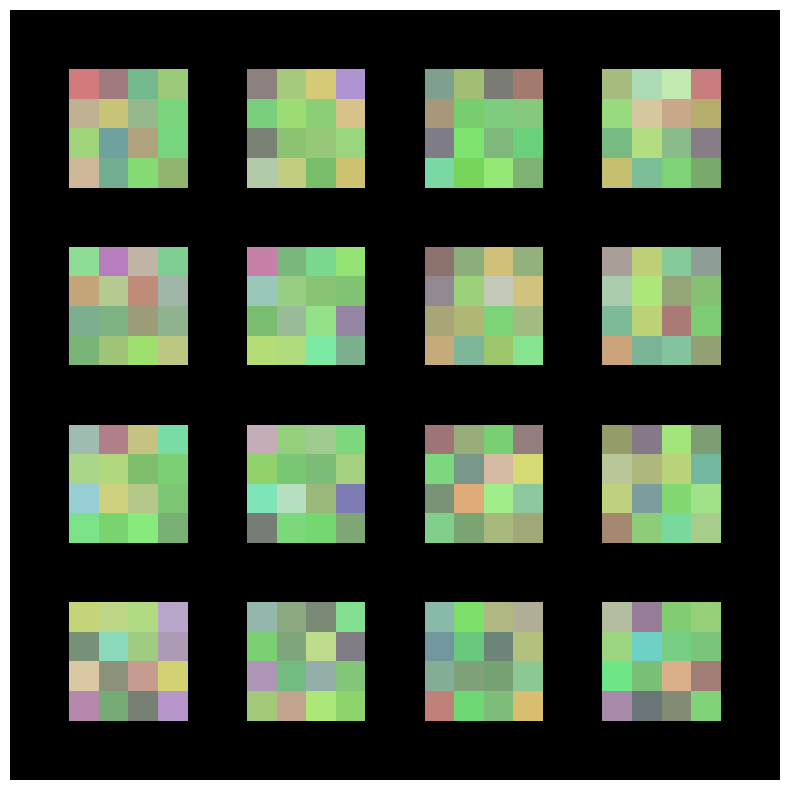

Layer 1: Loss_D: 0.5614404678344727, Loss_G: -0.07571638375520706


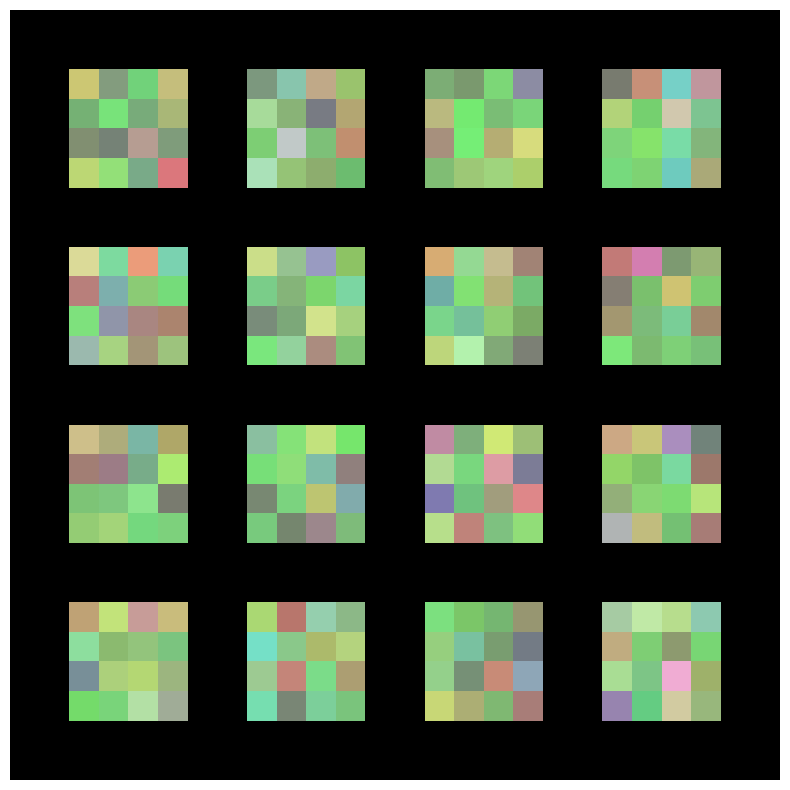

Layer 1: Loss_D: -0.8217840790748596, Loss_G: 1.0344665050506592


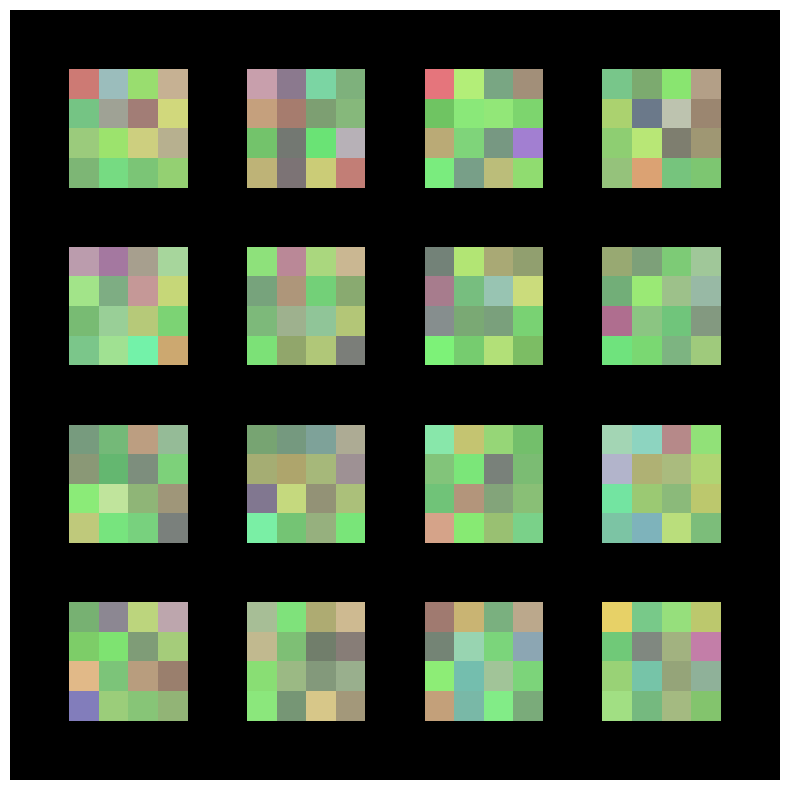

Layer 1: Loss_D: -0.8485559225082397, Loss_G: -0.42011040449142456


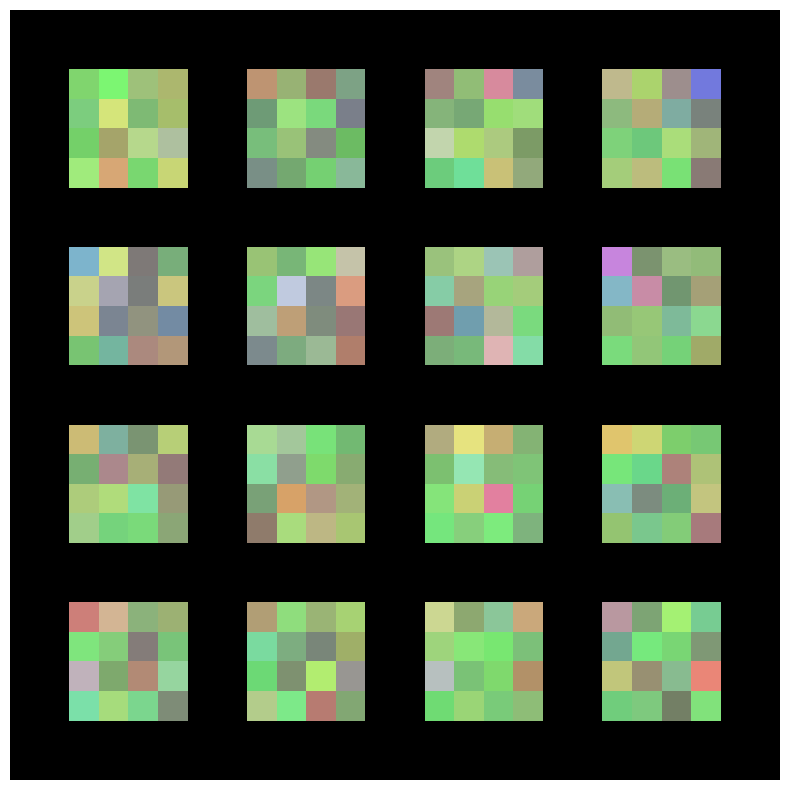

Layer 1: Loss_D: 0.622619092464447, Loss_G: -0.8556030988693237


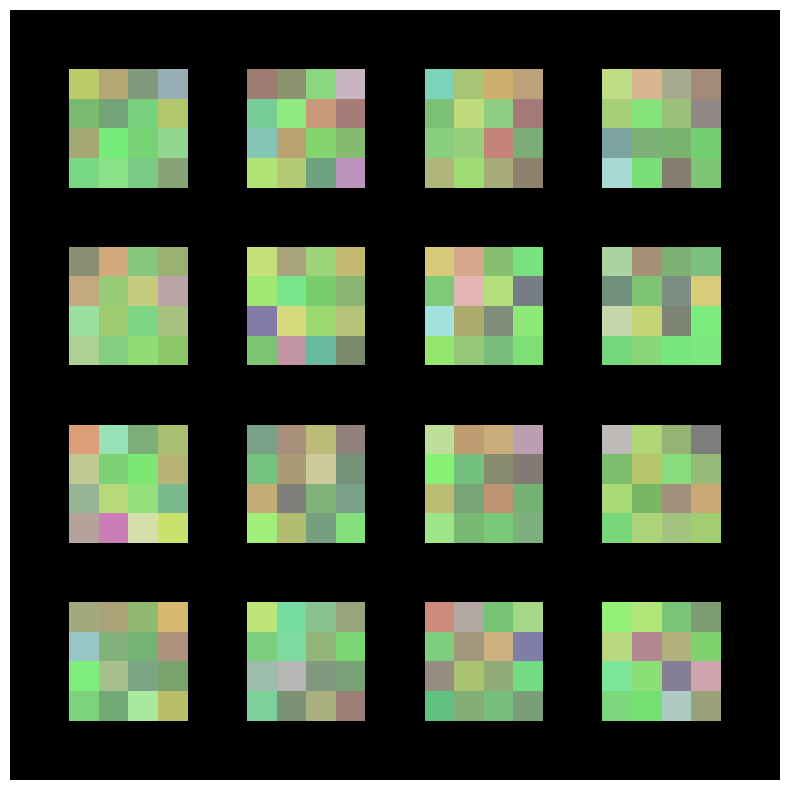

Layer 1: Loss_D: 0.8466899394989014, Loss_G: -0.08242780715227127


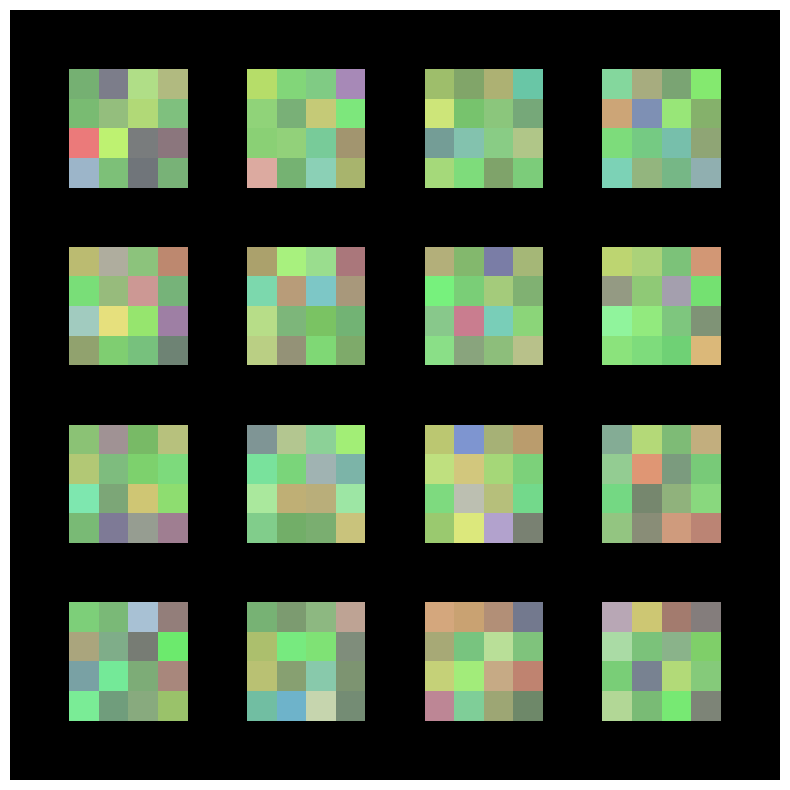

Layer 1: Loss_D: -0.12139968574047089, Loss_G: 0.2342783659696579


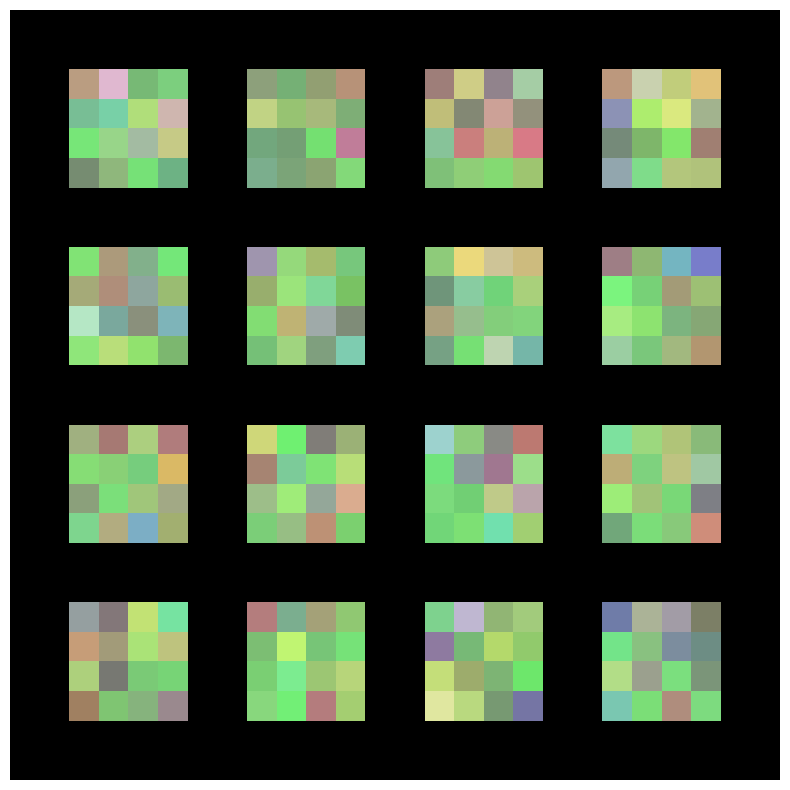

Layer 1: Loss_D: -0.8453933000564575, Loss_G: 0.6582496166229248


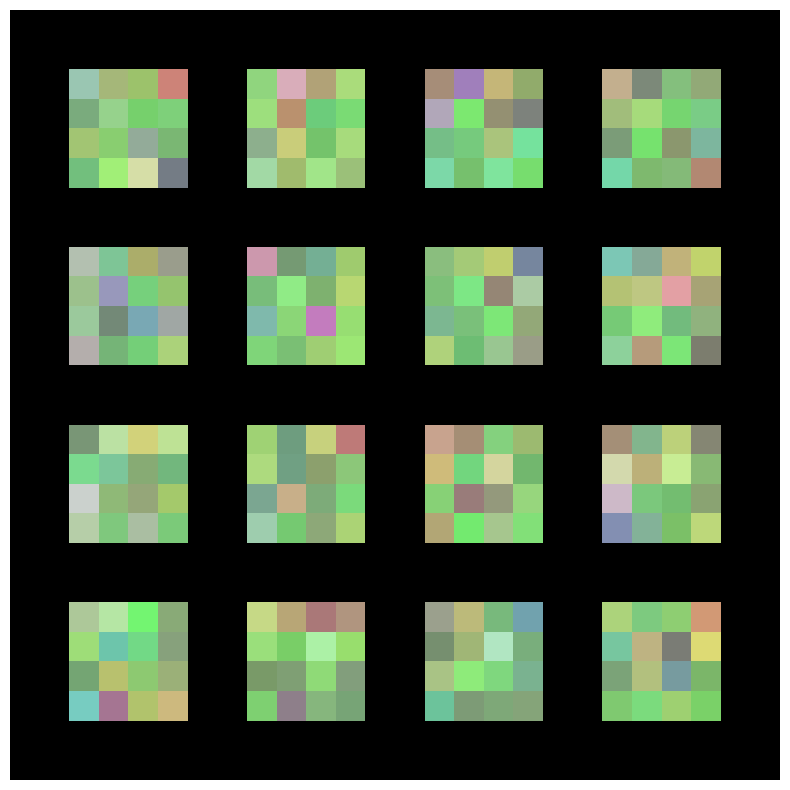

Layer 1: Loss_D: 0.47920042276382446, Loss_G: 0.29877614974975586


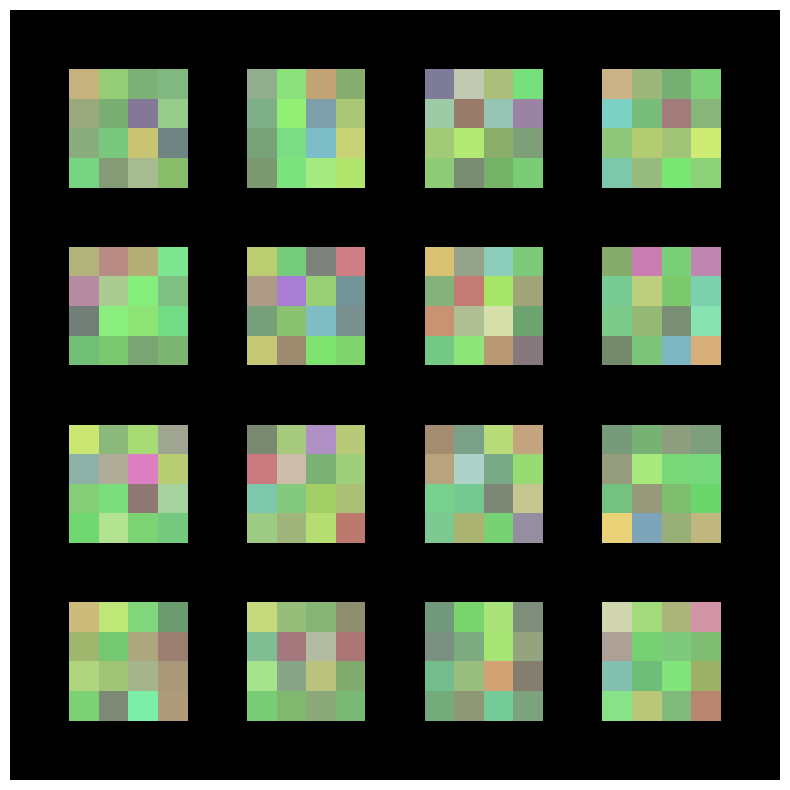

Layer 1: Loss_D: 1.2708841562271118, Loss_G: -0.6420966386795044
Alpha after grow: 1.0
FINAL | Layer 1: Loss_D: 0.8848524689674377, Loss_G: 0.2200455665588379


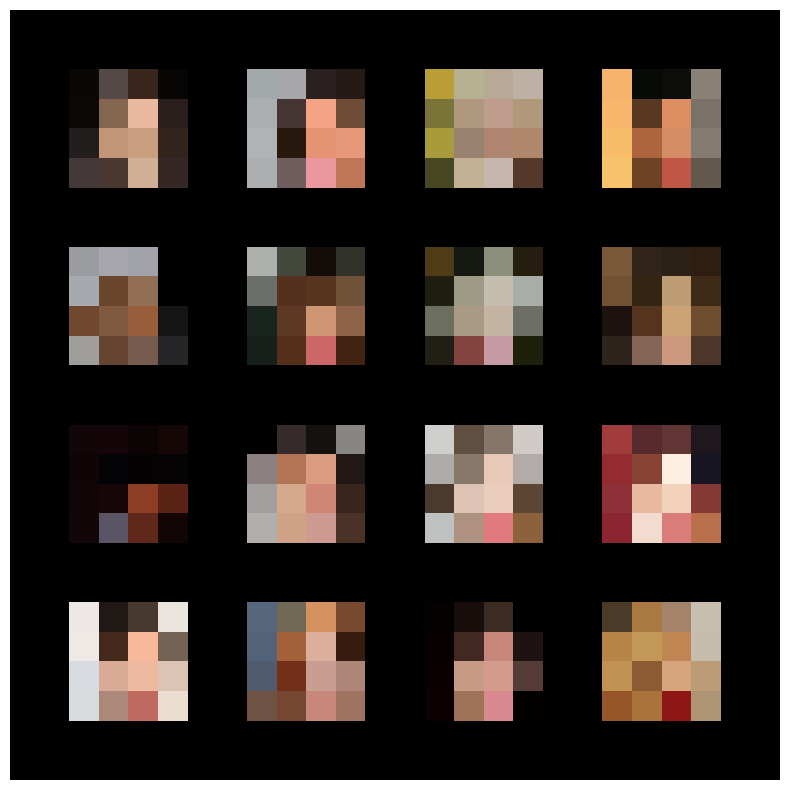

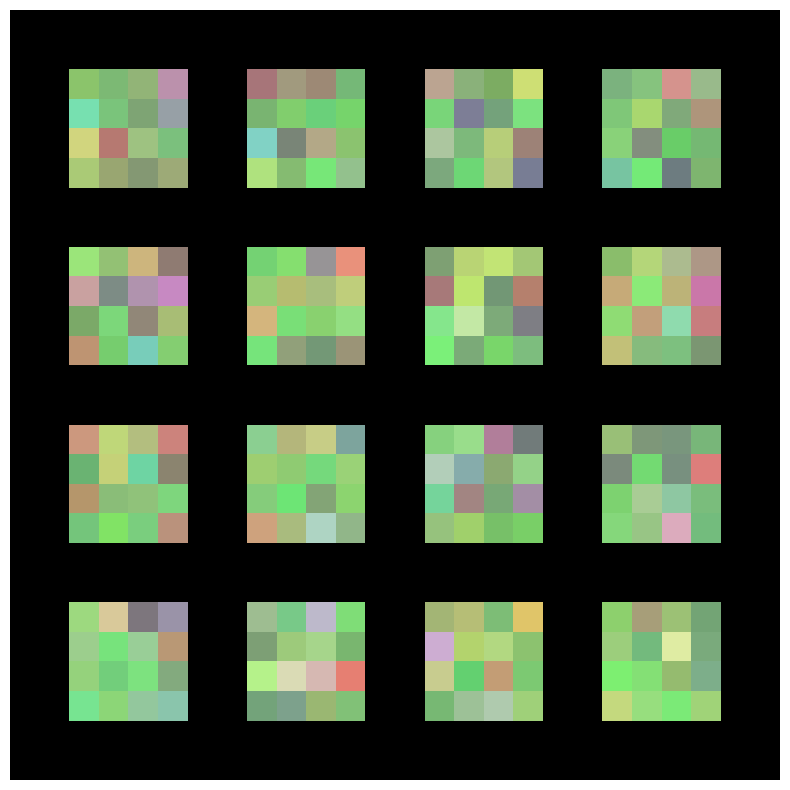

Training layer: 2


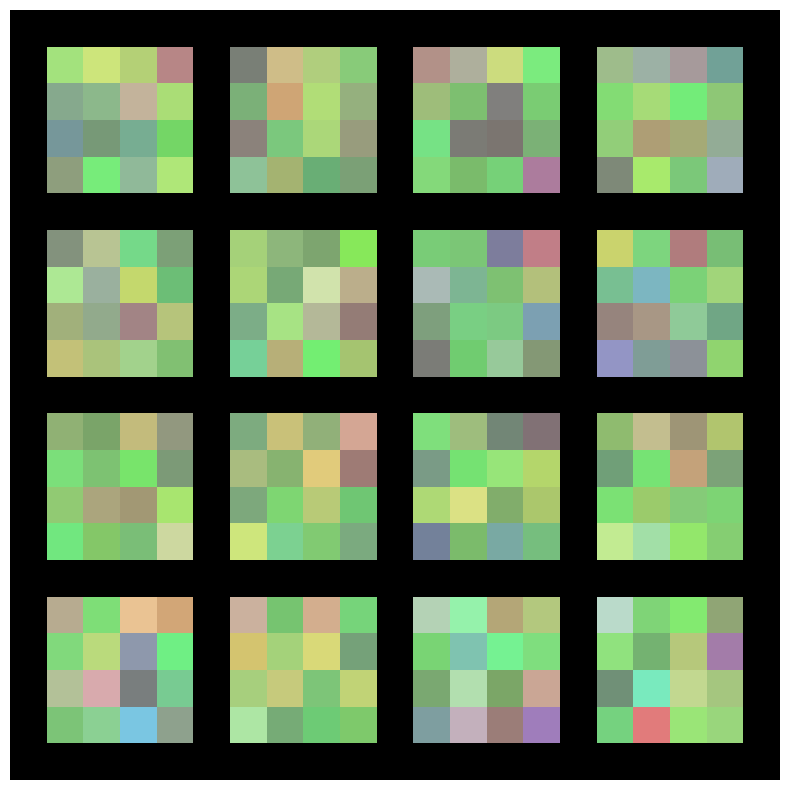

Layer 2: Loss_D: 1.0905835628509521, Loss_G: -1.0168441534042358


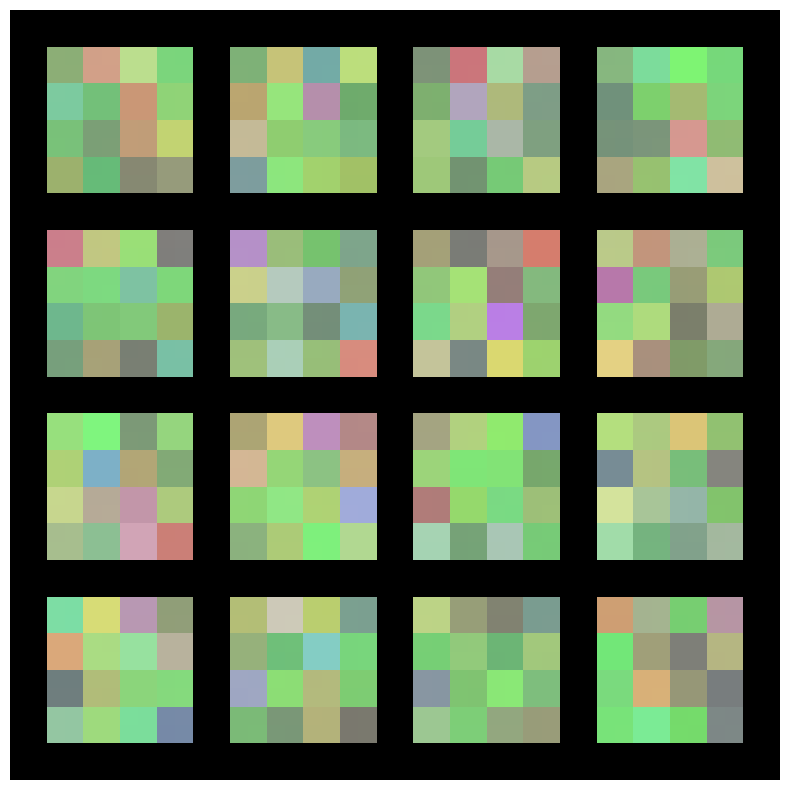

Layer 2: Loss_D: 2.417320728302002, Loss_G: -0.1153743714094162


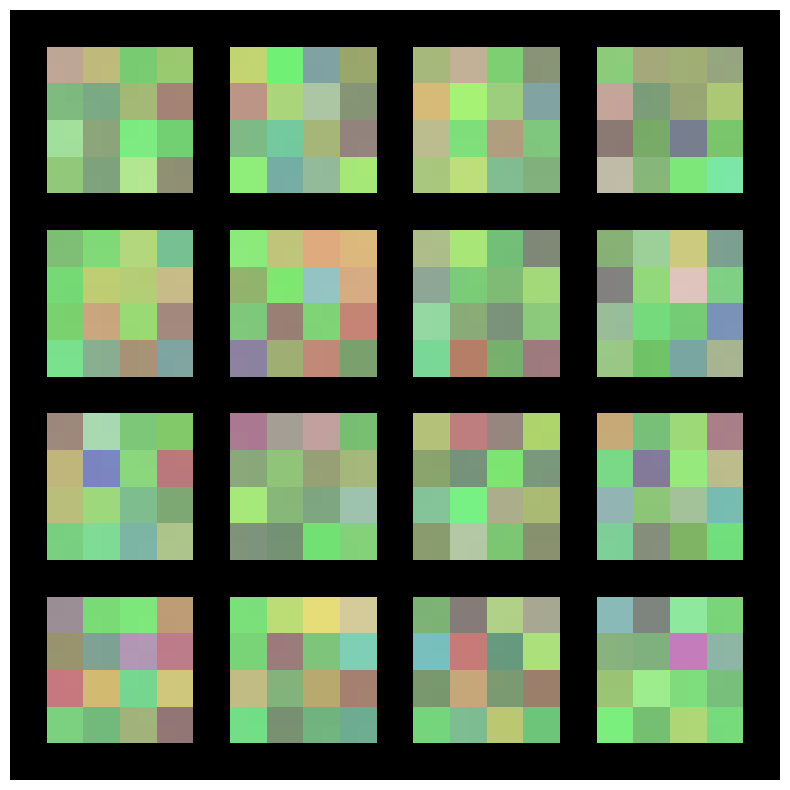

Layer 2: Loss_D: 1.441420078277588, Loss_G: -1.909163236618042


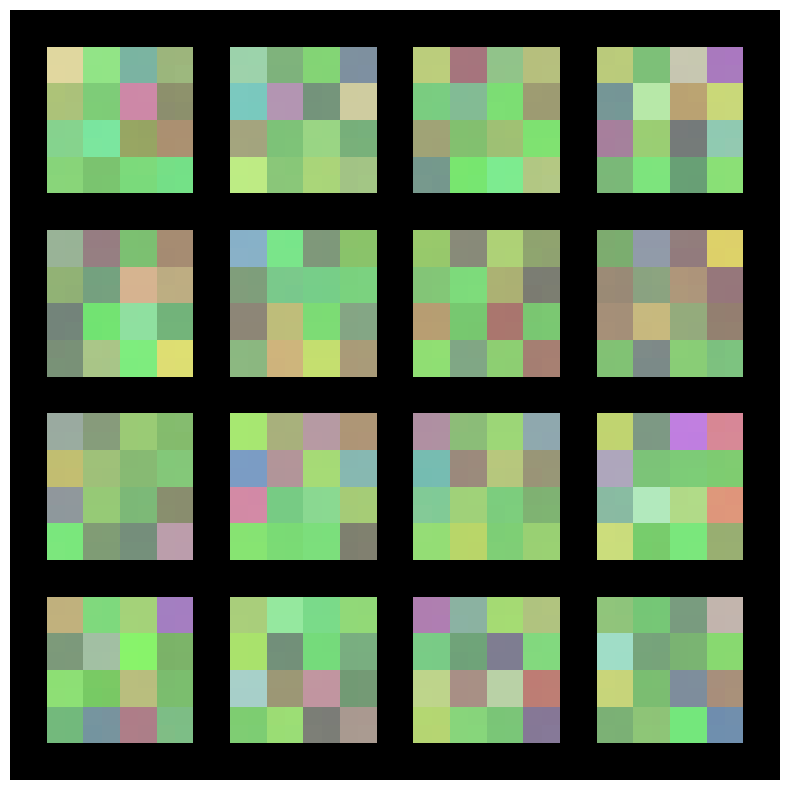

Layer 2: Loss_D: -2.7809455394744873, Loss_G: -0.021327145397663116


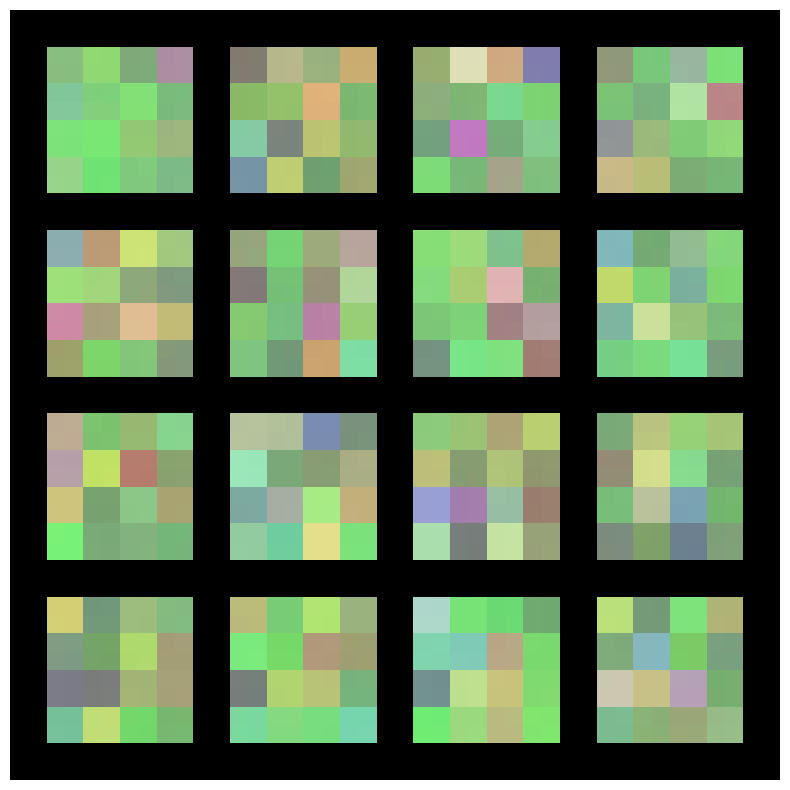

Layer 2: Loss_D: 2.9498798847198486, Loss_G: -0.05603357404470444


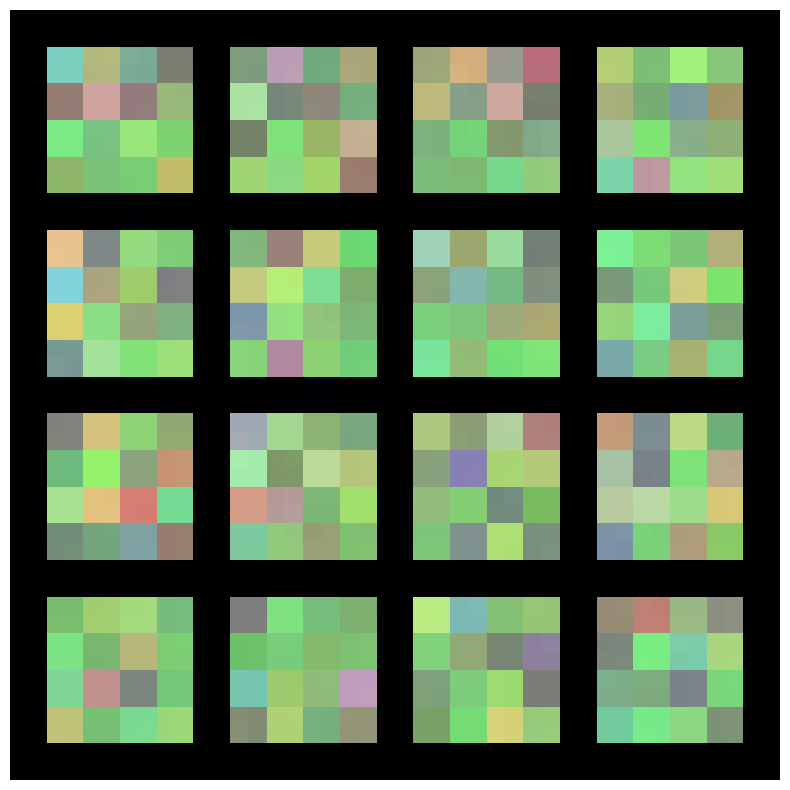

Layer 2: Loss_D: 3.6389293670654297, Loss_G: -3.39774227142334


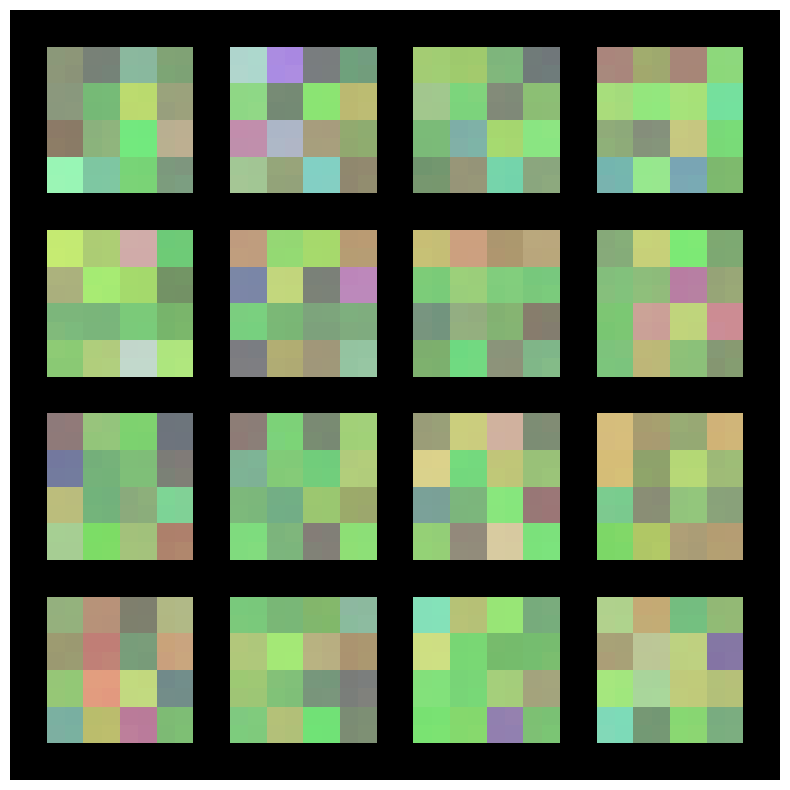

Layer 2: Loss_D: 1.5758031606674194, Loss_G: -2.0200271606445312


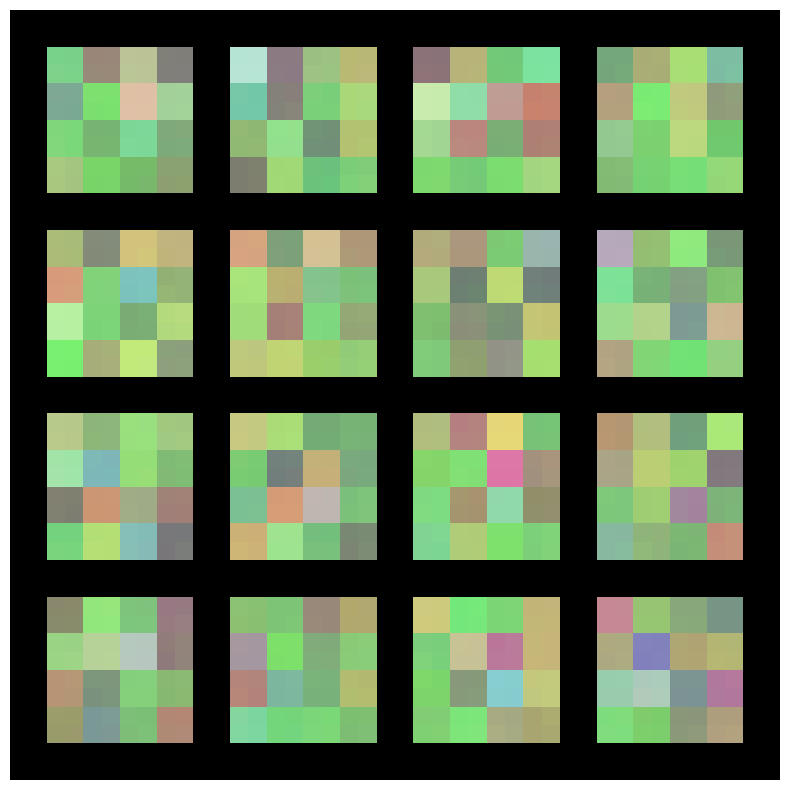

Layer 2: Loss_D: 2.567248821258545, Loss_G: -4.723295211791992


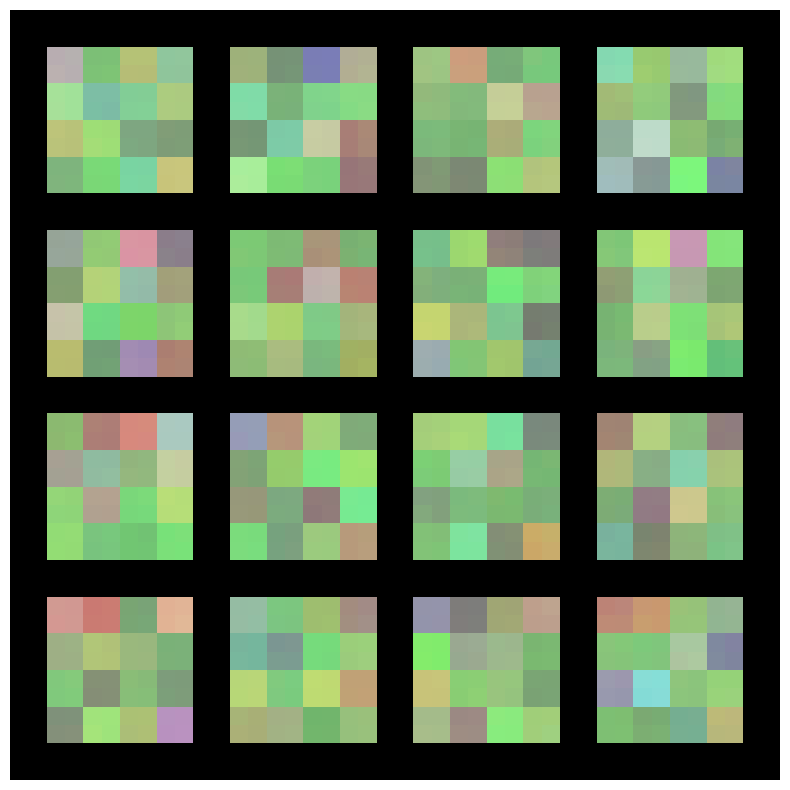

Layer 2: Loss_D: -0.248321995139122, Loss_G: -2.4628472328186035


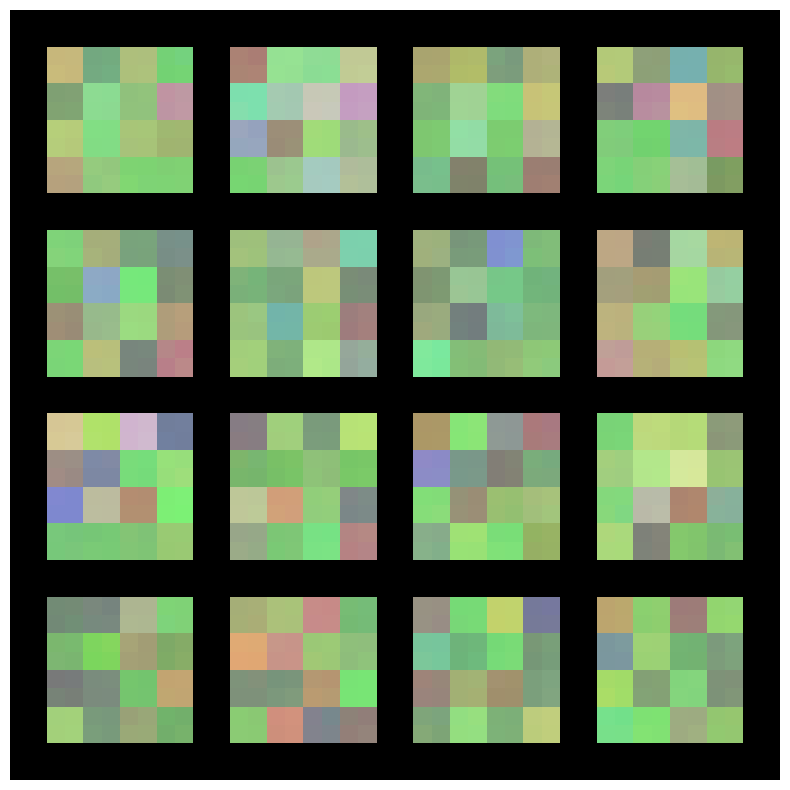

Layer 2: Loss_D: -6.636668682098389, Loss_G: 1.8207314014434814


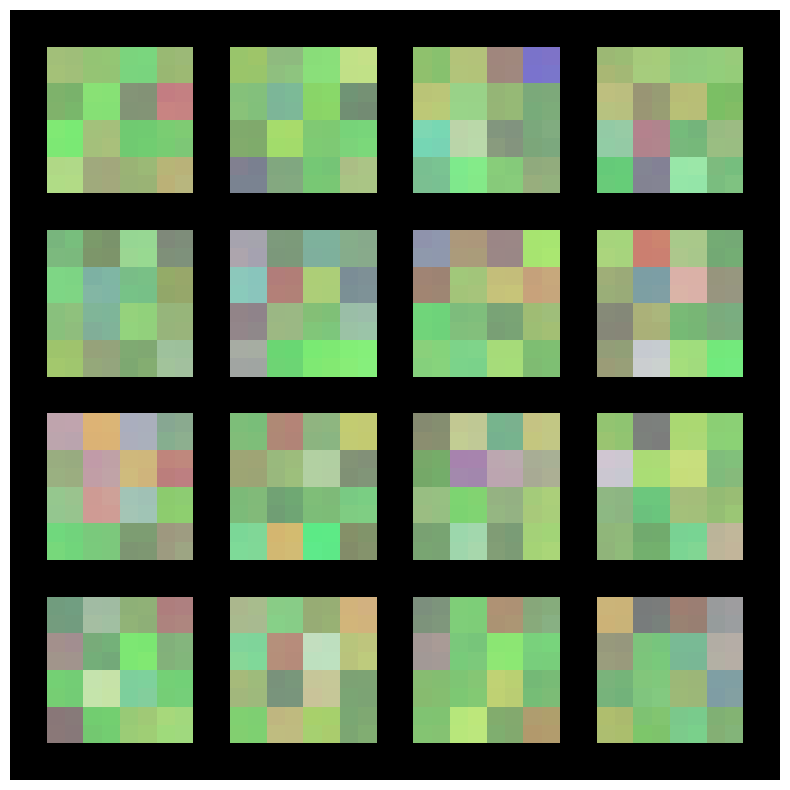

Layer 2: Loss_D: 7.7064619064331055, Loss_G: 3.8750500679016113


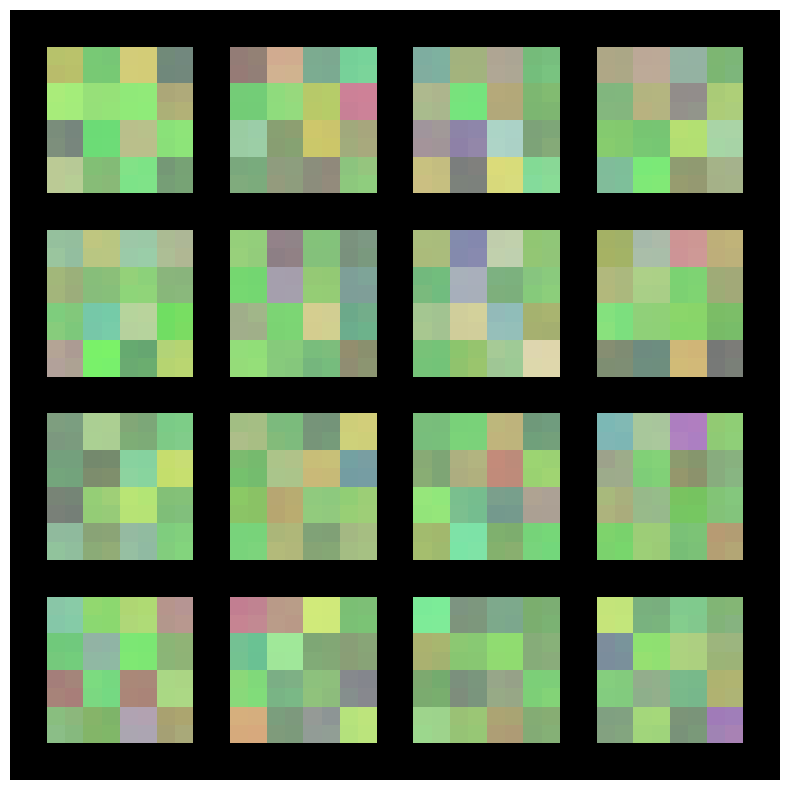

Layer 2: Loss_D: -0.32052624225616455, Loss_G: 3.747800827026367


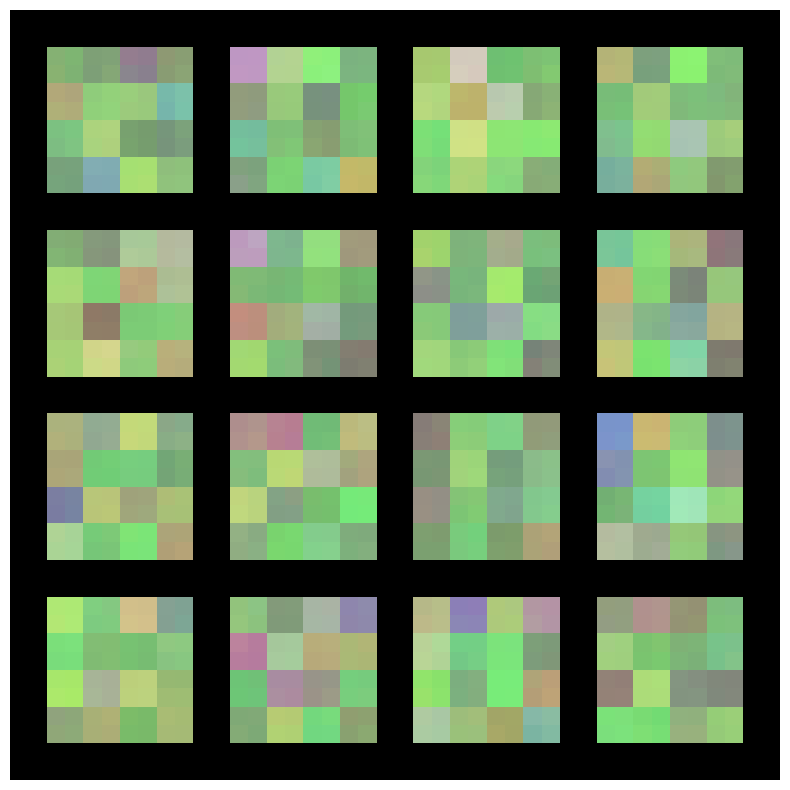

Layer 2: Loss_D: 2.4908792972564697, Loss_G: -1.6949186325073242


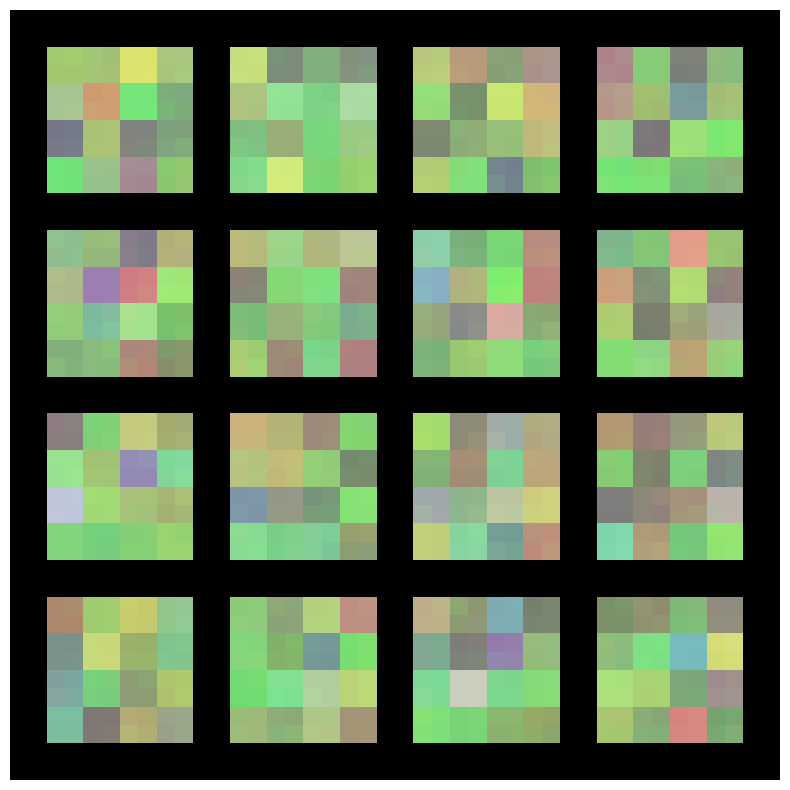

Layer 2: Loss_D: -0.18578074872493744, Loss_G: -1.6378246545791626


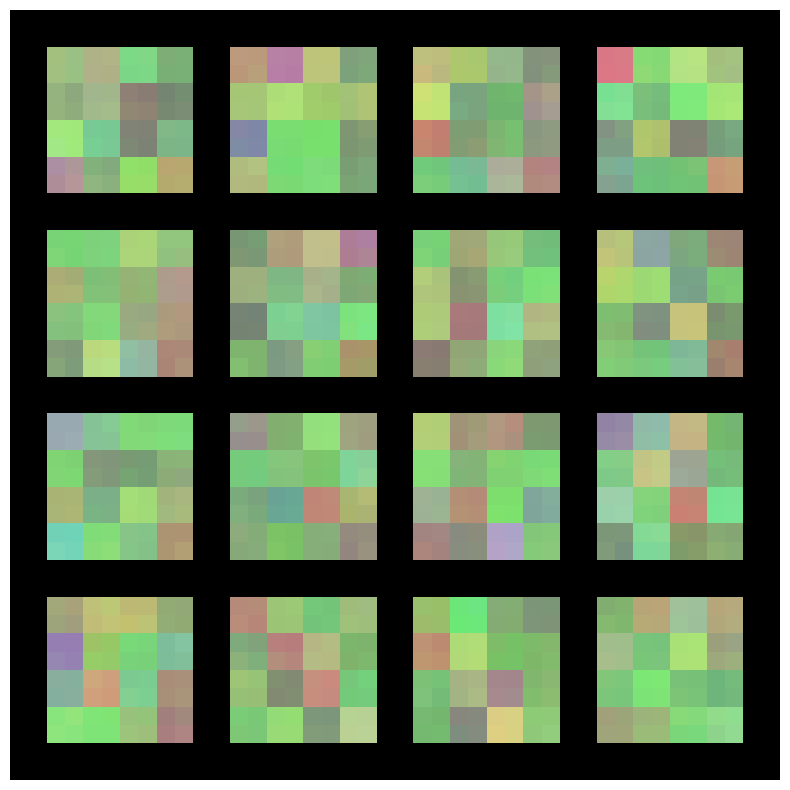

Layer 2: Loss_D: 1.0263398885726929, Loss_G: -2.226306438446045


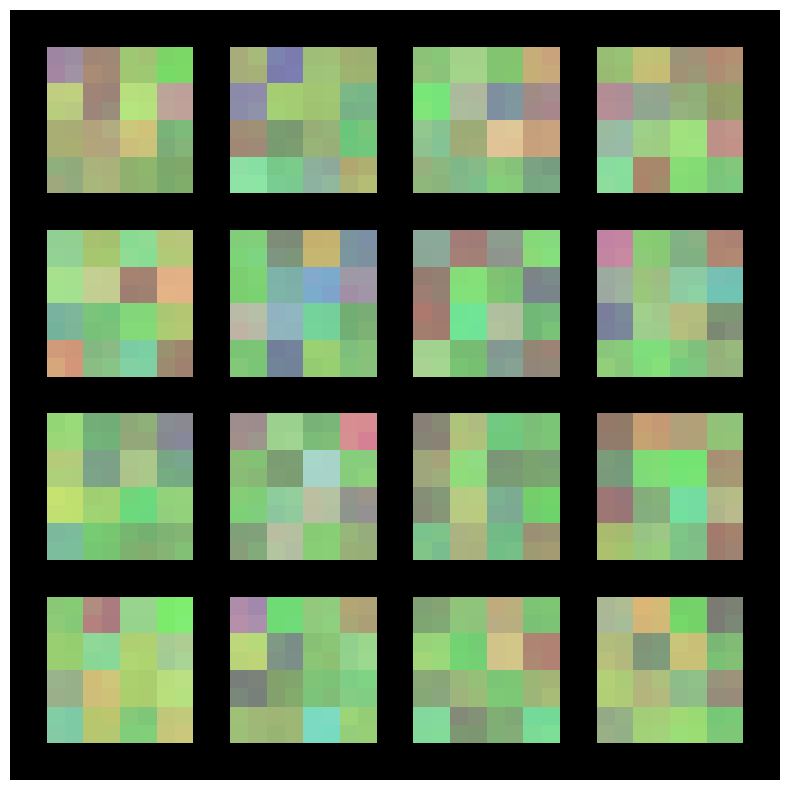

Layer 2: Loss_D: 1.262410283088684, Loss_G: -1.4444712400436401


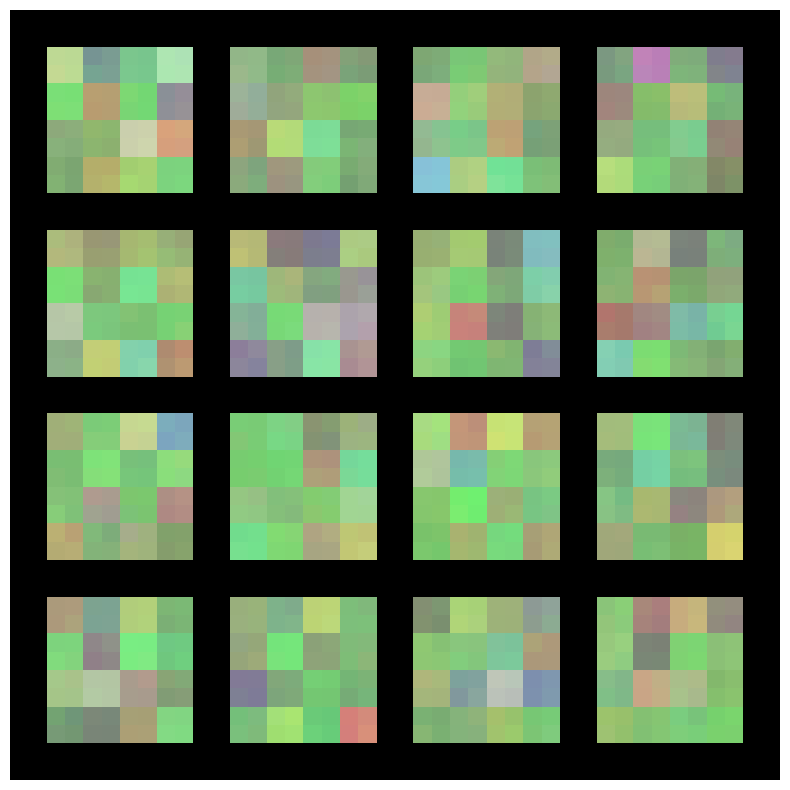

Layer 2: Loss_D: -0.16488294303417206, Loss_G: -0.5926526784896851


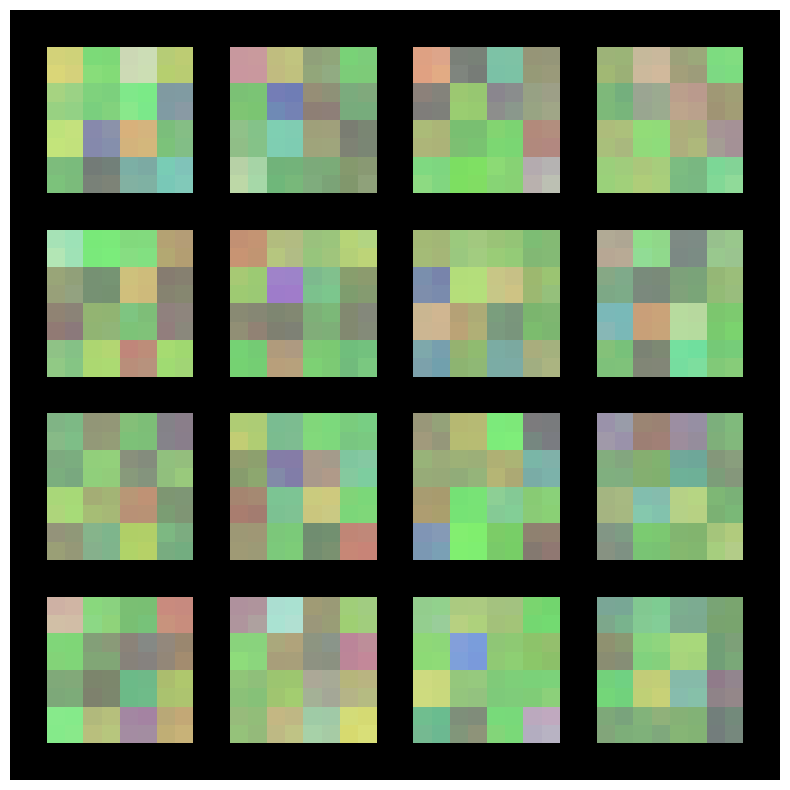

Layer 2: Loss_D: -5.1847028732299805, Loss_G: -3.683598279953003


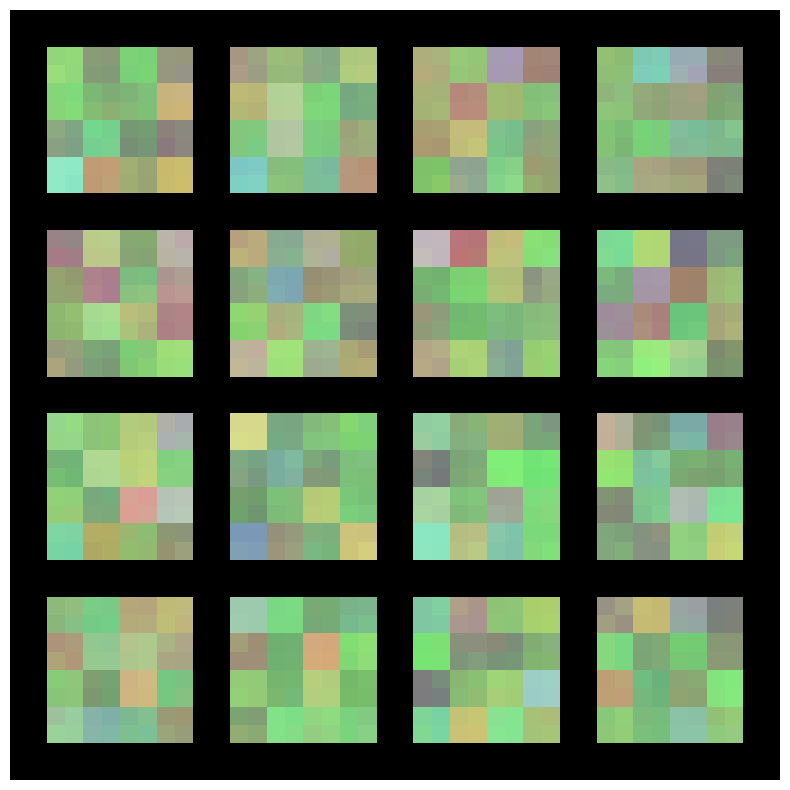

Layer 2: Loss_D: -2.492985248565674, Loss_G: -5.331395149230957


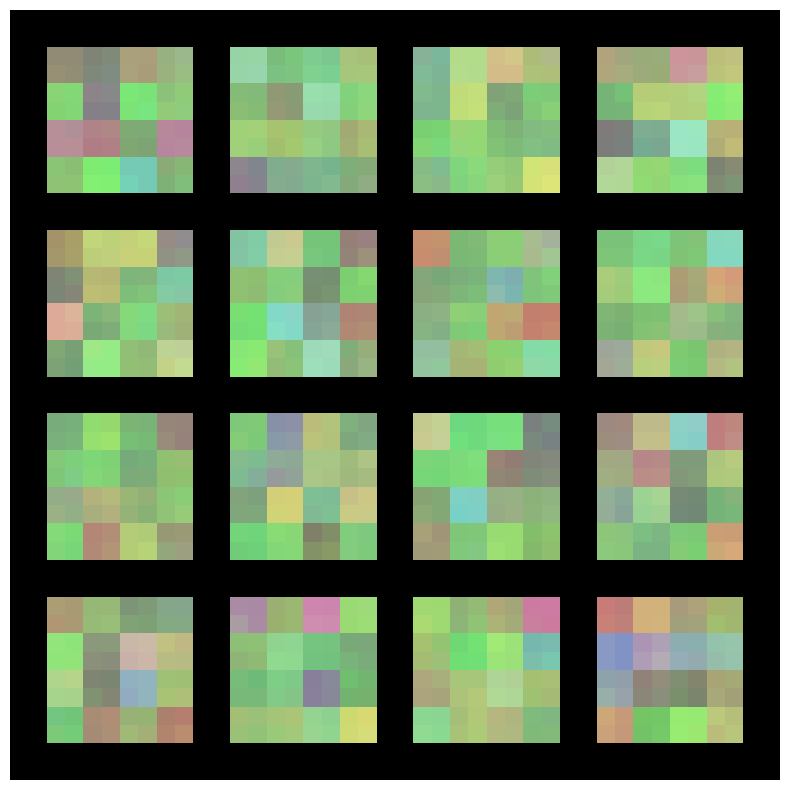

Layer 2: Loss_D: -1.5855594873428345, Loss_G: 1.426875352859497


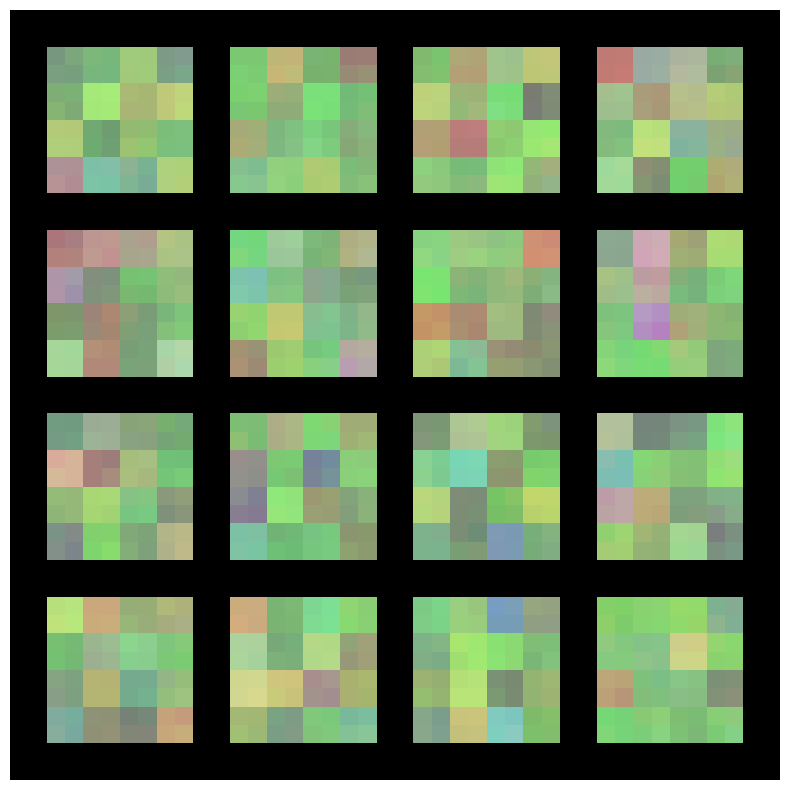

Layer 2: Loss_D: -7.278094291687012, Loss_G: 2.6007447242736816


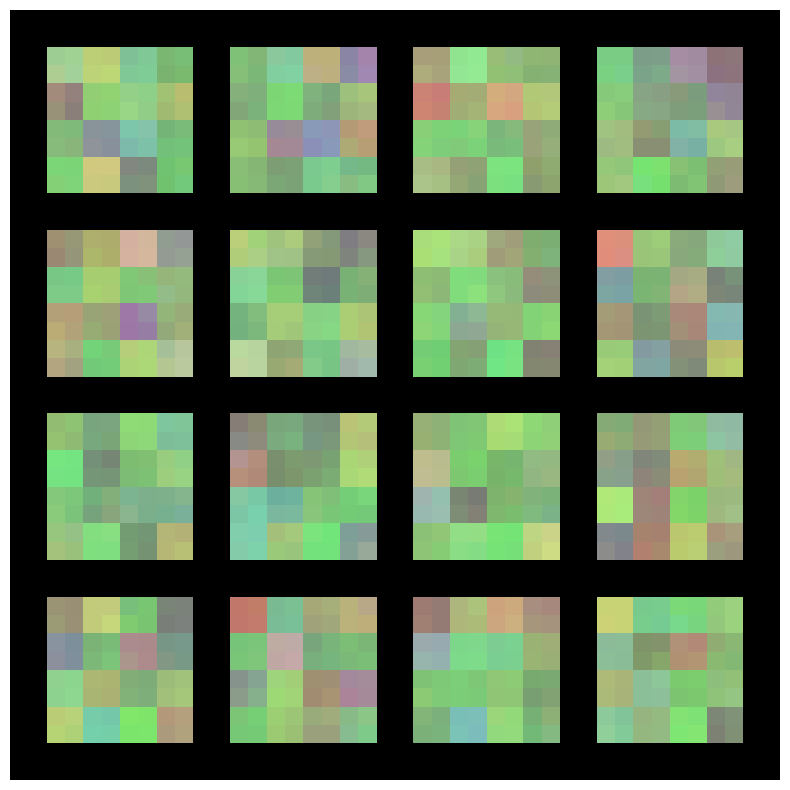

Layer 2: Loss_D: 6.308109283447266, Loss_G: 3.137450695037842


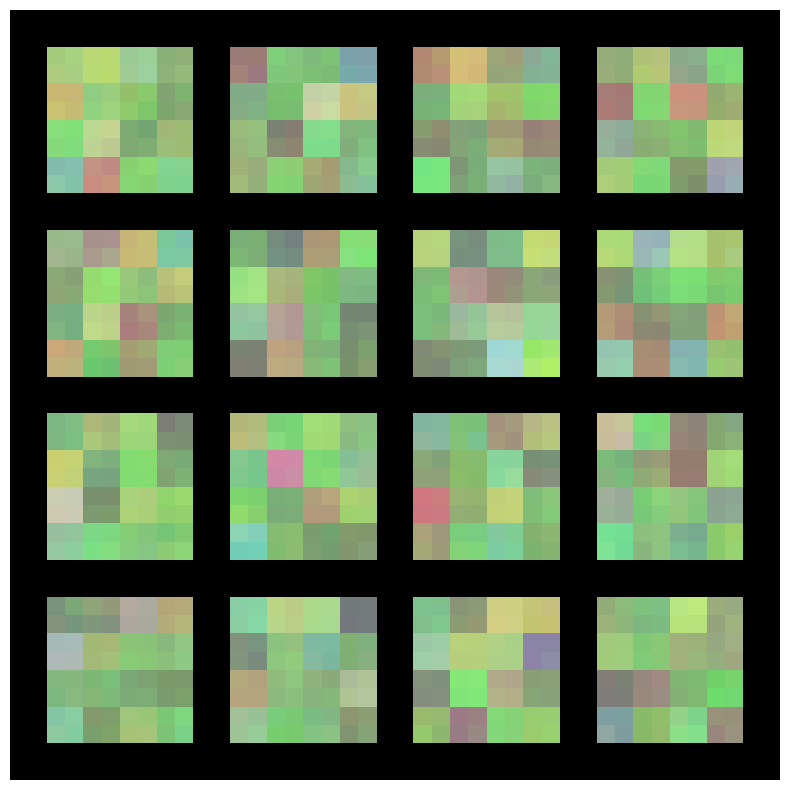

Layer 2: Loss_D: -4.024279594421387, Loss_G: -3.6503067016601562


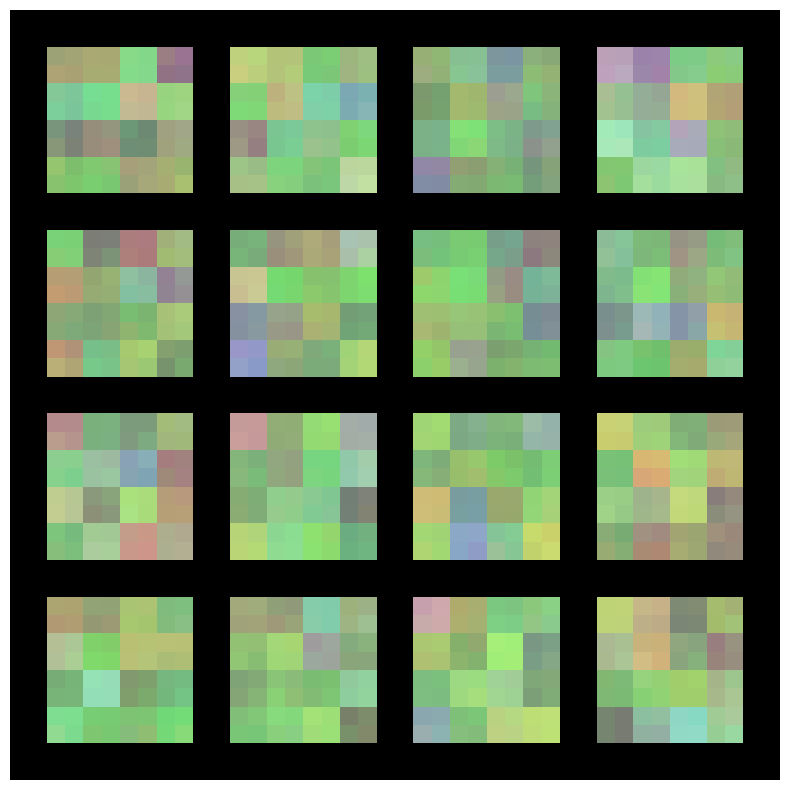

Layer 2: Loss_D: 9.769758224487305, Loss_G: 0.8011735081672668


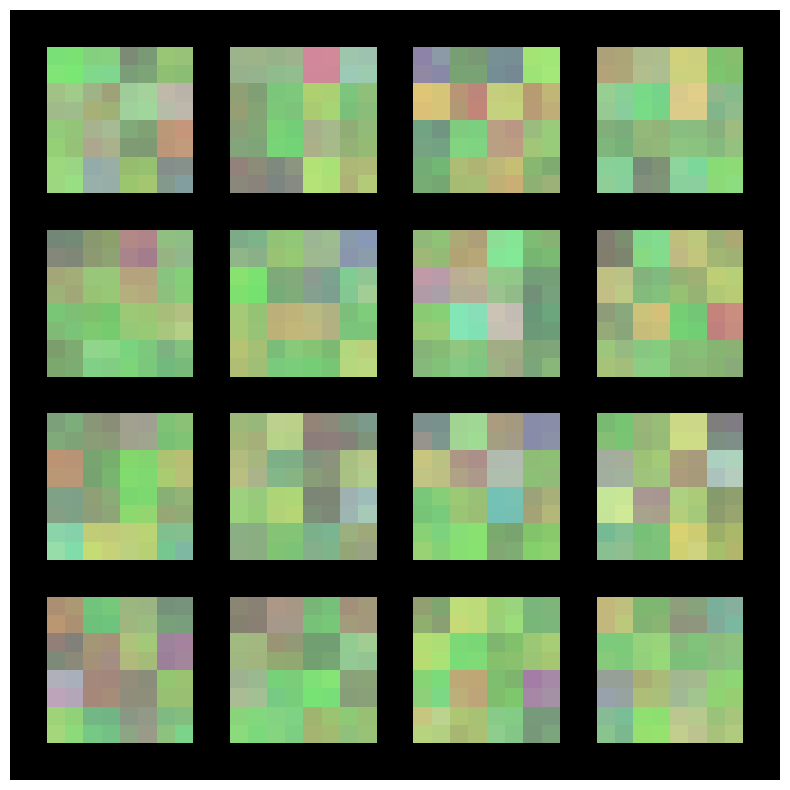

Layer 2: Loss_D: -11.027581214904785, Loss_G: 0.3535769581794739


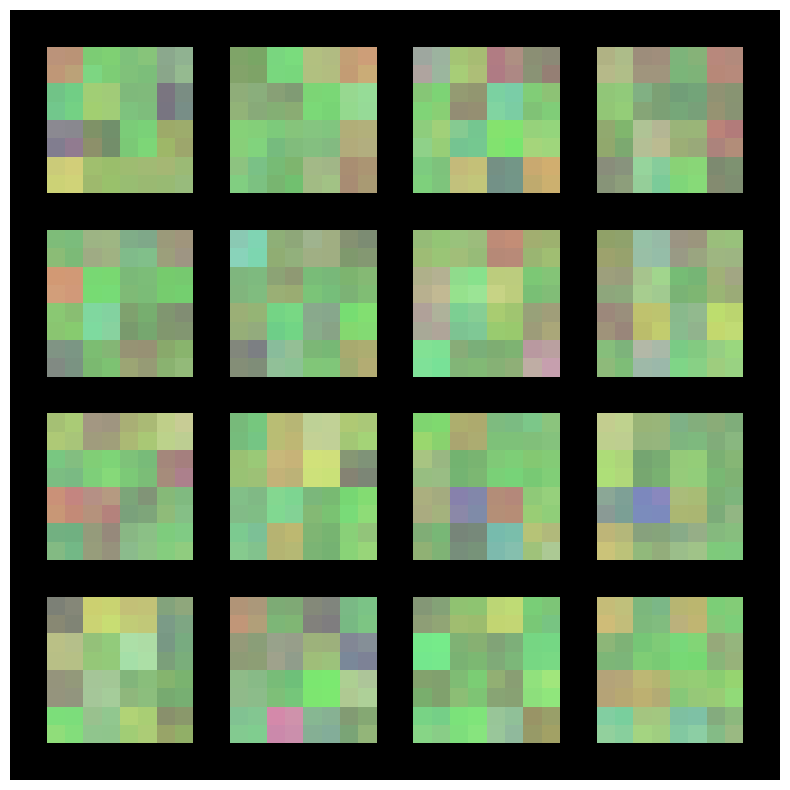

Layer 2: Loss_D: 2.3631210327148438, Loss_G: 1.9445189237594604


KeyboardInterrupt: 

In [121]:
for layer in range(1,5):
    print(f'Training layer: {layer}')
    alpha = 0
    
    for epoch_grow in range(100):
        for i, data in enumerate(dataloader):
            real_images, _ = data
            real_images = real_images.to(device)
        
            noise_tensor = torch.randn(latent_dim, device=device)

            with torch.no_grad():
                gen_images = g_32(noise_tensor, alpha=alpha, layer_num=layer)
            
            real_images = F.interpolate(real_images, size=gen_images.shape[2:])
                        
            #gen_labels = torch.zeros((batch_size, 1)).to(device)
            #real_labels = torch.ones((batch_size, 1)).to(device)

            #combined_images = torch.cat((real_images, gen_images))
            #combined_labels = torch.cat((real_labels, gen_labels))
            
            # First update the D model
            d_32.zero_grad()
            #d_outputs_combined = d_32(combined_images, alpha=alpha, layer_num=layer)
            #loss_d = criterion(d_outputs_combined, combined_labels)
            loss_d, _ = criterion(d_32, real_images, gen_images, alpha, layer)
            loss_d.backward()
            optim_D.step()
            
            # Generate new images for updating G
            noise_tensor = torch.randn(latent_dim, device=device)

            # Next update the G model, 
            g_32.zero_grad()
            #gen_images = g_32(noise_tensor, alpha=alpha, layer_num=layer)
            #d_outputs_generated = d_32(gen_images, alpha=alpha, layer_num=layer)
            #loss_g = criterion(d_outputs_generated, real_labels)
            _, loss_g = criterion(d_32, real_images, gen_images, alpha, layer)
            loss_g.backward()
            optim_G.step()
            
        #imshow(torchvision.utils.make_grid(gen_images.cpu()))
        show_images(gen_images)
        print(f'Layer {layer}: Loss_D: {loss_d.item()}, Loss_G: {loss_g.item()}')
        
        alpha += 1/100
        alpha = round(alpha, 2)
        
    print(f'Alpha after grow: {alpha}')
    for epoch_train in range(50):
        for i, data in enumerate(dataloader):
            real_images, _ = data
            real_images = real_images.to(device)

            noise_tensor = torch.randn(latent_dim, device=device)

            with torch.no_grad():
                gen_images = g_32(noise_tensor, alpha=alpha, layer_num=layer)

            real_images = F.interpolate(real_images, size=gen_images.shape[2:])

            #gen_labels = torch.zeros((batch_size, 1)).to(device)
            #real_labels = torch.ones((batch_size, 1)).to(device)

            #combined_images = torch.cat((real_images, gen_images))
            #combined_labels = torch.cat((real_labels, gen_labels))
            
            # First update the D model
            d_32.zero_grad()   
            #d_outputs_combined = d_32(combined_images, alpha=alpha, layer_num=layer)
            #loss_d = criterion(d_outputs_combined, combined_labels)
            loss_d, _ = criterion(d_32, real_images, gen_images, alpha, layer)
            loss_d.backward()
            optim_D.step()
            
            # Generate new images for updating G
            noise_tensor = torch.randn(latent_dim, device=device)

            # Next update the G model, 
            g_32.zero_grad()
            #gen_images = g_32(noise_tensor, alpha=alpha, layer_num=layer)
            #d_outputs_generated = d_32(gen_images, alpha=alpha, layer_num=layer)
            #loss_g = criterion(d_outputs_generated, real_labels)
            _, loss_g = criterion(d_32, real_images, gen_images, alpha, layer)
            loss_g.backward()
            optim_G.step()
            
    
    print(f'FINAL | Layer {layer}: Loss_D: {loss_d.item()}, Loss_G: {loss_g.item()}')
    #imshow(torchvision.utils.make_grid(real_images.cpu()))
    #imshow(torchvision.utils.make_grid(gen_images.cpu()))
    show_images(real_images)
    show_images(gen_images)
    

In [117]:
class Discriminator_32(nn.Module):
    def __init__(self):
        super().__init__()
        
        '''self.block9 = d_conv_block(in_channels=16, out_channels=32, kernel_size1=(3,3)).to(device)
        self.block8 = d_conv_block(in_channels=32, out_channels=64, kernel_size1=(3,3)).to(device)
        self.block7 = d_conv_block(in_channels=64, out_channels=128, kernel_size1=(3,3)).to(device)
        self.block6 = d_conv_block(in_channels=128, out_channels=256, kernel_size1=(3,3)).to(device)
        self.block5 = d_conv_block(in_channels=256, out_channels=512, kernel_size1=(3,3)).to(device)'''
        self.block4 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3)).to(device)
        self.block3 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3)).to(device)
        self.block2 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3)).to(device)
        self.block1 = d_conv_block(in_channels=513, out_channels=512, kernel_size1=(3,3), kernel_size2=(4,4)).to(device)
        
        self.down = nn.AvgPool2d(kernel_size=(2,2), stride=2).to(device)  # This isnt used for the layers but the res connection
        
        '''self.from_rgb9 = from_to_RGB(in_channels=3, out_channels=16).to(device)
        self.from_rgb8 = from_to_RGB(in_channels=3, out_channels=32).to(device)
        self.from_rgb7 = from_to_RGB(in_channels=3, out_channels=64).to(device)
        self.from_rgb6 = from_to_RGB(in_channels=3, out_channels=128).to(device)
        self.from_rgb5 = from_to_RGB(in_channels=3, out_channels=256).to(device)'''
        self.from_rgb4 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        self.from_rgb3 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        self.from_rgb2 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        self.from_rgb1 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        
        self.FC1 = nn.Identity()
        
        '''self.blocks = [
            self.block1, self.block2, self.block3, self.block4, 
            self.block5, self.block6, self.block7, self.block8, self.block9,
        ]
        self.from_rgbs = [
            self.from_rgb1, self.from_rgb2, self.from_rgb3, self.from_rgb4,
            self.from_rgb5, self.from_rgb6, self.from_rgb7, self.from_rgb8, self.from_rgb9,
        ]'''
        
        self.blocks = [
            self.block1, self.block2, self.block3, self.block4,
            #self.block5, self.block6, self.block7,
        ]
        self.from_rgbs = [
            self.from_rgb1, self.from_rgb2, self.from_rgb3, self.from_rgb4,
            #self.from_rgb5, self.from_rgb6, self.from_rgb7,
        ]
    
    def forward(self, x, alpha=1, layer_num=0):
        in_x = torch.clone(x)
        x = self.from_rgbs[layer_num-1](x)
        
        for i in reversed(range(layer_num)):
            #print(f'Layer_num: {i}')
            #print(f'x before block: {x.shape}')
            #print(self.blocks[i])
            x = self.blocks[i](x)
            #print(f'x after block: {x.shape}')
            if i == layer_num-1 and alpha < 1 and layer_num > 1:
                # Fade in the new layer
                downscaled = self.down(in_x)
                from_rgb = self.from_rgbs[layer_num-2](downscaled)
                x = (alpha * x) + ((1 - alpha) * from_rgb)
        
        # Last FC layer
        x = x.view(x.size(0), -1) # Reshape the output, i.e. flatten it 
        self.FC1 = d_output_layer(x.size(1)).to(x.device)
        x = self.FC1(x)
        
        return x
        
d_32 = Discriminator_32() 
d_32 = d_32.to(device)

In [118]:
d_32

Discriminator_32(
  (block4): Sequential(
    (0): EqualLRConv2d()
    (1): LeakyReLU(negative_slope=0.2)
    (2): EqualLRConv2d()
    (3): LeakyReLU(negative_slope=0.2)
    (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (block3): Sequential(
    (0): EqualLRConv2d()
    (1): LeakyReLU(negative_slope=0.2)
    (2): EqualLRConv2d()
    (3): LeakyReLU(negative_slope=0.2)
    (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (block2): Sequential(
    (0): EqualLRConv2d()
    (1): LeakyReLU(negative_slope=0.2)
    (2): EqualLRConv2d()
    (3): LeakyReLU(negative_slope=0.2)
    (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (block1): Sequential(
    (0): Mbatch_stddev()
    (1): EqualLRConv2d()
    (2): LeakyReLU(negative_slope=0.2)
    (3): EqualLRConv2d()
    (4): LeakyReLU(negative_slope=0.2)
  )
  (down): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (from_rgb4): Sequential(
    (0): EqualLRConv2d()
    (1): LeakyReLU(negati

In [119]:
d_in = torch.randn(2, 3, 32, 32).to(device)

# For 4x4 resolution (first stage)
#out = d_32(d_in, alpha=0.5, layer_num=1)

# For 8x8 resolution with alpha=0.5
#out = d_32(d_in, alpha=0.5, layer_num=2)

# For 16x16 resolution
#out = d_32(d_in, alpha=0.5, layer_num=3)

# For  32x32 resolution
out = d_32(d_in, alpha=0.5, layer_num=4)

# For 256x256 res
#out = d_32(d_in, alpha=0.5, layer_num=7)

print(out)

tensor([[3.1987e-05],
        [2.5554e-05]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [55]:
del d_in
del out
torch.cuda.empty_cache()

In [116]:
class Generator_32(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(4,4), kernel_size2=(3,3)).to(device)
        #self.up1 = upsample(512).to(device)
        self.block2 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up2 = upsample(512).to(device)
        self.block3 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up3 = upsample(512).to(device)
        self.block4 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        # Lets leave out the last 5 layers for 32x32 generations
        '''self.up4 = upsample(512).to(device)
        self.block5 = g_conv_block(in_channels=512, out_channels=256, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up5 = upsample(256).to(device)
        self.block6 = g_conv_block(in_channels=256, out_channels=128, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up6 = upsample(128).to(device)
        self.block7 = g_conv_block(in_channels=128, out_channels=64, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up7 = upsample(64).to(device)
        self.block8 = g_conv_block(in_channels=64, out_channels=32, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up8 = upsample(32).to(device)
        self.block9 = g_conv_block(in_channels=32, out_channels=16, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)'''
                
        self.to_rgb1 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        self.to_rgb2 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        self.to_rgb3 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        self.to_rgb4 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        '''self.to_rgb5 = from_to_RGB(in_channels=256, out_channels=3).to(device)
        self.to_rgb6 = from_to_RGB(in_channels=128, out_channels=3).to(device)
        self.to_rgb7 = from_to_RGB(in_channels=64, out_channels=3).to(device)
        self.to_rgb8 = from_to_RGB(in_channels=32, out_channels=3).to(device)
        self.to_rgb9 = from_to_RGB(in_channels=16, out_channels=3).to(device)'''
        
        self.tanh = nn.Tanh()
        
        '''self.blocks = [
            self.block1, self.block2, self.block3, self.block4,
            self.block5, self.block6, self.block7, self.block8, self.block9
        ]
        self.ups = [
            self.up1, self.up2, self.up3, 
            self.up4, self.up5, self.up6,
            self.up7, self.up8,
        ]
        self.to_rgbs = [
            self.to_rgb1, self.to_rgb2, self.to_rgb3, self.to_rgb4,
            self.to_rgb5, self.to_rgb6, self.to_rgb7, self.to_rgb8, self.to_rgb9,
        ]'''
        
        self.blocks = [
            self.block1, self.block2, self.block3, self.block4,
            #self.block5, self.block6, self.block7
        ]
        #self.ups = [
        #    self.up1, self.up2, self.up3, 
            #self.up4, self.up5, self.up6,
        #]
        self.to_rgbs = [
            self.to_rgb1, self.to_rgb2, self.to_rgb3, self.to_rgb4,
            #self.to_rgb5, self.to_rgb6, self.to_rgb7
        ]
        
    def forward(self, x, alpha=1, layer_num=0):
        for i in range(layer_num):
            x = self.blocks[i](x)
            if i < layer_num - 1:
                #x = self.ups[i](x)
                x = F.interpolate(x, scale_factor=2, mode="nearest")
            if i == layer_num - 2:
                res_x = torch.clone(x)
            
        out = self.to_rgbs[layer_num-1](x)
        
        if layer_num > 1 and alpha < 1:
            prev_rgb = self.to_rgbs[layer_num-2](res_x)
            
            # Interpolate between the two outputs
            out = (1 - alpha) * prev_rgb + alpha * out
        
        out = self.tanh(out)
        
        return out
    
g_32 = Generator_32()
g_32 = g_32.to(device)

In [52]:
g_in = torch.randn((1, 512, 1, 1), device=device)

# For 4x4 resolution (first stage)
#out = g_32(g_in, alpha=0, layer_num=1)

# For 8x8 resolution with alpha=0.5
#out = g_32(g_in, alpha=0.5, layer_num=2)

# For 16x16 resolution
#out = g_32(g_in, alpha=0.5, layer_num=3)

# For full 32x32 resolution
out = g_32(g_in, alpha=0.5, layer_num=4)

#out = g_32(g_in, alpha=0.5, layer_num=7)

print(out.shape)

torch.Size([1, 3, 32, 32])


In [114]:
del g_in
del out
torch.cuda.empty_cache()

Lets make some tests to ensure the training is going smoothly, these come from https://github.com/soumith/ganhacks

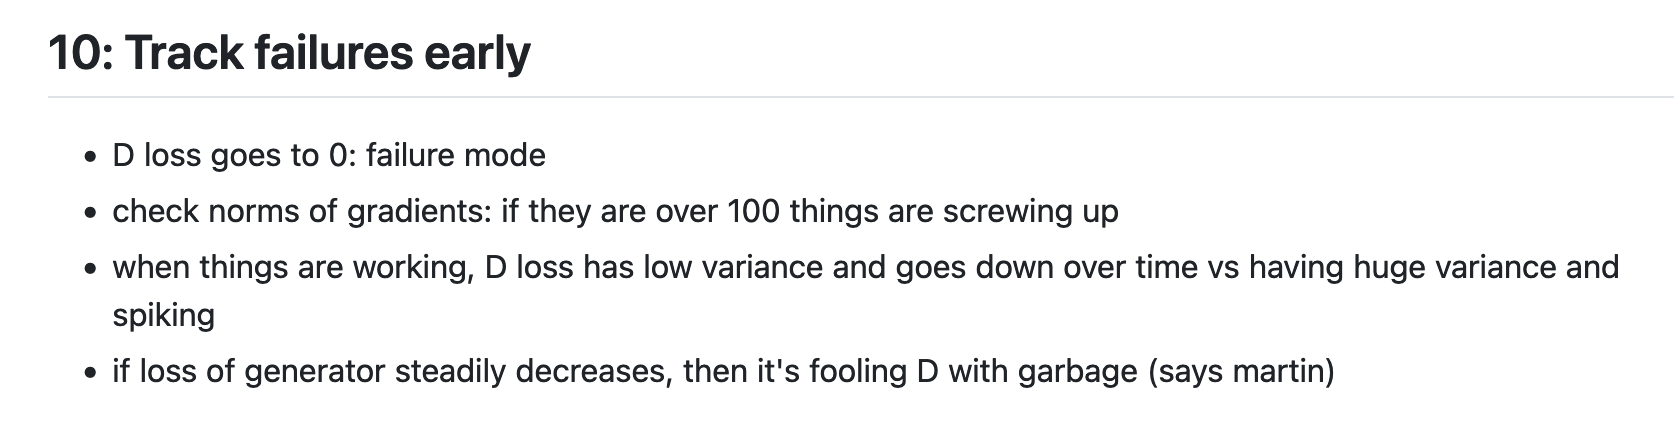